In [1]:
# define libraries to use
import pandas as pd
import numpy as np
#from pathlib import Path
import requests,json
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import scipy as sp
%matplotlib inline
import pickle
import seaborn as sns
from tabulate import tabulate

pd.options.display.max_columns = None
pd.options.display.max_rows = 50

def millions(x,pos=0):
    if x==0:
        return '0'
    else:
        return '%1.1fM' % (float(x) * 1e-6)


In [2]:
nydmvModelIDCat = pd.read_pickle("tmp/nydmv-vindecode-modelid-dict.pkl")

In [3]:
nydmvVinDecodeDf = pd.read_pickle("tmp/nydmv-vindecodedf.pkl")
nydmvVinDecodeDf.set_index("entry",inplace=True)
nydmvDf = pd.read_pickle("tmp/nydmvdf.pkl")
nydmvVinDecodeDf = pd.merge(nydmvDf,nydmvVinDecodeDf,left_index=True, right_index=True)
nydmvDf = None
nydmvVinDecodeDf.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11180719 entries, 33 to 12586465
Data columns (total 54 columns):
 #   Column                            Non-Null Count     Dtype         
---  ------                            --------------     -----         
 0   VIN                               11180719 non-null  object        
 1   Registration Class                11180719 non-null  category      
 2   City                              11180719 non-null  object        
 3   State                             11180719 non-null  category      
 4   Zip                               11180719 non-null  category      
 5   County                            11180719 non-null  object        
 6   Model Year                        11180719 non-null  Int64         
 7   Make                              11180719 non-null  category      
 8   Body Type                         11180719 non-null  category      
 9   Fuel Type                         11180719 non-null  category      
 10  Unl

In [4]:
farsVehVpicMergeDf = pd.read_pickle("tmp/fars-vehvpicmergedf.pkl")
farsAccidentDf = pd.read_pickle("tmp/fars-accidentdf.pkl")
# add STATE to farsVehVpicMergeDf
farsVehVpicMergeDf = pd.merge(farsVehVpicMergeDf,farsAccidentDf[["ST_CASE","STATE"]],on="ST_CASE")
farsVehVpicMergeDf.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51435 entries, 0 to 51434
Data columns (total 77 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   ST_CASE                           51435 non-null  int64  
 1   VEH_NO                            51435 non-null  int64  
 2   NUMOCCS                           51435 non-null  int64  
 3   MAKE                              51435 non-null  int64  
 4   MAK_MOD                           51435 non-null  int64  
 5   BODY_TYP                          51435 non-null  int64  
 6   MOD_YEAR                          51435 non-null  int64  
 7   VIN                               51435 non-null  object 
 8   TOW_VEH                           51435 non-null  int64  
 9   TRAV_SP                           51435 non-null  int64  
 10  ROLLOVER                          51435 non-null  int64  
 11  IMPACT1                           51435 non-null  int64  
 12  M_HA

In [5]:
farsPersonDf = pd.read_pickle("tmp/fars-persondf.pkl")
# keep drivers only
#farsPersonDf.info(show_counts=True)
farsPersonDf = farsPersonDf[farsPersonDf["PER_NO"]==1][["ST_CASE","VEH_NO","SEX","AGE"]]
farsPersonDf["SEX"] = farsPersonDf["SEX"].astype("int64")
farsPersonDf["AGE"] = farsPersonDf["AGE"].astype("int64")
farsPersonDf.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61911 entries, 0 to 85883
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   ST_CASE  61911 non-null  int64
 1   VEH_NO   61911 non-null  int64
 2   SEX      61911 non-null  int64
 3   AGE      61911 non-null  int64
dtypes: int64(4)
memory usage: 2.4 MB


In [6]:
# top 20 vehicle models involved in crashes
farsTopModels = pd.read_pickle("tmp/fars-topmodels.pkl")
farsTopModels.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   ModelId  20 non-null     int64
dtypes: int64(1)
memory usage: 288.0 bytes


In [7]:
f = open("tmp/fars-categories.pkl","rb")
farsCategories = pickle.load(f)
f.close()

In [8]:
farsCategories.keys()

dict_keys(['STATE', 'MONTH', 'DAY_WEEK', 'ROUTE', 'RUR_URB', 'FUNC_SYS', 'HARM_EV', 'MAN_COLL', 'LGT_COND', 'WEATHER', 'NUMOCCS', 'MAKE', 'MAK_MOD', 'BODY_TYP', 'TOW_VEH', 'TRAV_SP', 'ROLLOVER', 'IMPACT1', 'M_HARM', 'DR_PRES', 'L_STATUS', 'L_TYPE', 'PREV_ACC', 'PREV_DWI', 'PREV_SPD', 'PREV_OTH', 'SPEEDREL', 'VSURCOND', 'P_CRASH2', 'ACC_TYPE', 'DR_DRINK', 'VPICMAKE', 'VPICMODEL', 'VPICBODYCLASS', 'GVWR_FROM', 'GVWR_TO', 'SEX', 'PER_TYP', 'INJ_SEV', 'SEAT_POS', 'REST_USE', 'AIR_BAG', 'EJECTION', 'LOCATION', 'PNUMOCCS', 'PTYPE', 'PMAKE', 'PMAK_MOD', 'PTRAILER', 'PM_HARM', 'PBPTYPE', 'PBAGE', 'PBSEX', 'AOI1', 'AOI2', 'CRASHRF', 'DRIVERRF', 'DRDISTRACT', 'DRIMPAIR', 'VEHICLECC', 'VISION', 'NMCC', 'VehicleTypeId', 'ManufacturerFullNameId', 'MakeId', 'ModelId', 'BodyClassId', 'GrossVehicleWeightRatingFromId', 'GrossVehicleWeightRatingToId', 'ForwardCollisionWarningId', 'DynamicBrakeSupportId', 'CrashImminentBrakingID', 'PedestrianAutoEmergencyBrakingId', 'BlindSpotWarningId', 'BlindSpotInterv

In [9]:
farsCategories["GVWR_FROM"]

{11: 'Class 1: 6,000 lbs. or less (2,722 kg or less)',
 12: 'Class 2: 6,001 - 10,000 lbs. (2,722 - 4,536 kg)',
 18: 'Class 8: 33,001 lbs. and above (14,969 kg and above)',
 15: 'Class 5: 16,001 - 19,500 lbs. (7,258 - 8,845 kg)',
 17: 'Class 7: 26,001 - 33,000 lbs. (11,794 - 14,969 kg)',
 13: 'Class 3: 10,001 - 14,000 lbs. (4,536 - 6,350 kg)',
 99: 'Reported as Unknown',
 16: 'Class 6: 19,501 - 26,000 lbs. (8,845 - 11,794 kg)',
 14: 'Class 4: 14,001 - 16,000 lbs. (6,350 - 7,258 kg)',
 98: 'Not Reported'}

In [10]:
farsCategories["GrossVehicleWeightRatingFromId"]

{nan: nan,
 14.0: 'Class 2E: 6,001 - 7,000 lb (2,722 - 3,175 kg)',
 9.0: 'Class 8: 33,001 lb and above (14,969 kg and above)',
 15.0: 'Class 2F: 7,001 - 8,000 lb (3,175 - 3,629 kg)',
 13.0: 'Class 1D: 5,001 - 6,000 lb (2,268 - 2,722 kg)',
 11.0: 'Class 1B: 3,001 - 4,000 lb (1,360 - 1,814 kg)',
 6.0: 'Class 5: 16,001 - 19,500 lb (7,258 - 8,845 kg)',
 17.0: 'Class 2H: 9,001 - 10,000 lb (4,082 - 4,536 kg)',
 12.0: 'Class 1C: 4,001 - 5,000 lb (1,814 - 2,268 kg)',
 8.0: 'Class 7: 26,001 - 33,000 lb (11,794 - 14,969 kg)',
 16.0: 'Class 2G: 8,001 - 9,000 lb (3,629 - 4,082 kg)',
 10.0: 'Class 1A: 3,000 lb or less (1,360 kg or less)',
 4.0: 'Class 3: 10,001 - 14,000 lb (4,536 - 6,350 kg)',
 1.0: 'Class 1: 6,000 lb or less (2,722 kg or less)',
 7.0: 'Class 6: 19,501 - 26,000 lb (8,845 - 11,794 kg)',
 2.0: 'Class 2: 6,001 - 10,000 lb (2,722 - 4,536 kg)',
 5.0: 'Class 4: 14,001 - 16,000 lb (6,350 - 7,258 kg)'}

## Eliminate Motorcycles, Buses, Off-Road Vehicles, Low-Speed Vehicles, Others

In [11]:
vpicBodyToRemove = [
    16, 68, 73, # Buses
    6, 12, 80, 81, 82, 83, 85, 87, 90, 94, 98, 100, 103, 104, 109, 110, 114, 125, 996, # Motorcycles
    69, 84, 86, 88, 97, 105, 113, 124, 126, 127, # off-road vehicles
    4, # low-speed vehiches
    108, 117, # Other
    61, # Trailers
    62, 63, 64, 65, 67, 70, 71, 72, 74, 75, 76, 77, 78, 107, 112, # Incomplete Body class (unfinished)
]

In [12]:
farsVehVpicMergeDf = farsVehVpicMergeDf[~farsVehVpicMergeDf["VPICBODYCLASS"].isin(vpicBodyToRemove)]
farsVehVpicMergeDf.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44922 entries, 0 to 51434
Data columns (total 77 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   ST_CASE                           44922 non-null  int64  
 1   VEH_NO                            44922 non-null  int64  
 2   NUMOCCS                           44922 non-null  int64  
 3   MAKE                              44922 non-null  int64  
 4   MAK_MOD                           44922 non-null  int64  
 5   BODY_TYP                          44922 non-null  int64  
 6   MOD_YEAR                          44922 non-null  int64  
 7   VIN                               44922 non-null  object 
 8   TOW_VEH                           44922 non-null  int64  
 9   TRAV_SP                           44922 non-null  int64  
 10  ROLLOVER                          44922 non-null  int64  
 11  IMPACT1                           44922 non-null  int64  
 12  M_HA

In [13]:
nydmvVinDecodeDf
nydmvVinDecodeDf = nydmvVinDecodeDf[~nydmvVinDecodeDf["BodyClassId"].isin(vpicBodyToRemove)]
nydmvVinDecodeDf.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10533510 entries, 33 to 12586465
Data columns (total 54 columns):
 #   Column                            Non-Null Count     Dtype         
---  ------                            --------------     -----         
 0   VIN                               10533510 non-null  object        
 1   Registration Class                10533510 non-null  category      
 2   City                              10533510 non-null  object        
 3   State                             10533510 non-null  category      
 4   Zip                               10533510 non-null  category      
 5   County                            10533510 non-null  object        
 6   Model Year                        10533510 non-null  Int64         
 7   Make                              10533510 non-null  category      
 8   Body Type                         10533510 non-null  category      
 9   Fuel Type                         10533510 non-null  category      
 10  Unl

Next steps:
1) FARS vpicdecode, see if GVWR_FROM can be infered from Model/Year/Trim/Series... from NYSDMV values
2) get vehicle grouping finalized

## FARS vpicdecode, see if GVWR_FROM can be infered from Model/Year/Trim/Series... from NYSDMV values

In [14]:
# check if model numbers are unique across makes
tmp1 = nydmvVinDecodeDf[["MakeID","ModelID"]].dropna().drop_duplicates()
if (tmp1["ModelID"].value_counts() > 1).sum() == 0:
    print("VPIC ModelIDs are Unique Across Manufacturers")
else:
    print("***************************************************************************")
    print("VPIC ModelIDs are NOT Unique Across Manufacturers!!!!!!!!!!!!!!!!!!!!!!!!!!")
    print("***************************************************************************")


VPIC ModelIDs are Unique Across Manufacturers


In [15]:
# check how many vehicles have missing GVWR_FROM in all states
farsVehNATMissingGVWRCnt = farsVehVpicMergeDf["GrossVehicleWeightRatingFromId"].isna().sum()
farsVehNYSMissingGVWRCnt = (farsVehVpicMergeDf["GrossVehicleWeightRatingFromId"].isna() & (farsVehVpicMergeDf["STATE"] == 36)).sum()
print("FARS Vehicles missing GVWR (NAT): ", farsVehNATMissingGVWRCnt)
print("FARS Vehicles missing GVWR (NYS): ", farsVehNYSMissingGVWRCnt)
print("FARS Cases with Vehicles missing GVWR (NAT): ", farsVehVpicMergeDf[farsVehVpicMergeDf["GrossVehicleWeightRatingFromId"].isna()][["ST_CASE"]].drop_duplicates().count().values[0])

FARS Vehicles missing GVWR (NAT):  15987
FARS Vehicles missing GVWR (NYS):  398
FARS Cases with Vehicles missing GVWR (NAT):  14123


In [16]:
# check how many vehicles have missing GVWR_FROM in NY state
print("FARS NYS Vehicles missing GVWR:",farsVehVpicMergeDf[farsVehVpicMergeDf["GrossVehicleWeightRatingFromId"].isna() & (farsVehVpicMergeDf["STATE"] == 36)][["STATE"]].value_counts().values[0])
print("FARS NYS Cases with Vehicles missing GVWR: ",farsVehVpicMergeDf[farsVehVpicMergeDf["GrossVehicleWeightRatingFromId"].isna() & (farsVehVpicMergeDf["STATE"] == 36)][["ST_CASE"]].drop_duplicates().count().values[0])

FARS NYS Vehicles missing GVWR: 398
FARS NYS Cases with Vehicles missing GVWR:  353


In [17]:
print("FARS Models missing GVWR\n",farsVehVpicMergeDf[farsVehVpicMergeDf["GrossVehicleWeightRatingFromId"].isna()][["VPICMODEL"]].value_counts().sort_values(ascending=False))
print("FARS Total Models missing GVWR = ",farsVehVpicMergeDf[farsVehVpicMergeDf["GrossVehicleWeightRatingFromId"].isna()][["VPICMODEL"]].drop_duplicates().count().values[0])

FARS Models missing GVWR
 VPICMODEL
2469         1013
2208          734
1904          697
1833          575
1834          548
             ... 
14216           1
14185           1
23521           1
20813           1
28077           1
Length: 459, dtype: int64
FARS Total Models missing GVWR =  459


In [18]:
print("NYSDMV Model IDs found:\n",nydmvVinDecodeDf[~nydmvVinDecodeDf["GrossVehicleWeightRatingFromId"].isna()][["ModelID"]].value_counts().sort_values(ascending=False))

NYSDMV Model IDs found:
 ModelID
1865.0     317149
1850.0     267285
2217.0     254554
1861.0     249782
1863.0     221255
            ...  
9737.0          1
29235.0         1
9736.0          1
16043.0         1
2637.0          1
Length: 1317, dtype: int64


In [19]:
# fars Vehicles with no weight
#farsModelsNoWeight = farsVehVpicMergeDf[farsVehVpicMergeDf["GrossVehicleWeightRatingFromId"].isna()][["VPICMODEL","VPICBODYCLASS"]].drop_duplicates().dropna()
farsModelsNoWeight = farsVehVpicMergeDf[farsVehVpicMergeDf["GrossVehicleWeightRatingFromId"].isna()][["VPICMODEL","Trim"]].drop_duplicates().dropna()
farsModelsNoWeight

VPICMODEL                 Trim
0           2475                  300
124         1895               Police
137         2735              SE Base
166         2208      L/LE/SE/XLE/XSE
188         2053                 200C
...          ...                  ...
50249       6093                    L
50400       2232  Premium + M/R + CWP
50449       6495             H Series
50468      14553      Royale Brougham
50575       1877                  JXi

[666 rows x 2 columns]

In [20]:
# nydmv models that have 1:1 mapping to GVWRF
# NOTE: after trial/error trim/series do not help in comin up with 1:1 mappings 
#
#tmp1 = nydmvVinDecodeDf[~nydmvVinDecodeDf["GrossVehicleWeightRatingFromId"].isna()][["ModelID","Trim","GrossVehicleWeightRatingFromId"]].drop_duplicates()[["ModelID","Trim"]].value_counts()
#tmp1 = nydmvVinDecodeDf[~nydmvVinDecodeDf["GrossVehicleWeightRatingFromId"].isna()][["MakeID","ModelID","BodyClassId","GrossVehicleWeightRatingFromId"]].drop_duplicates()
tmp1 = nydmvVinDecodeDf[~nydmvVinDecodeDf["GrossVehicleWeightRatingFromId"].isna()][["MakeID","ModelID","BodyClassId","GrossVehicleWeightRatingFromId"]].drop_duplicates().dropna()[["ModelID","BodyClassId","GrossVehicleWeightRatingFromId"]]
tmp1["ModelID"] = tmp1["ModelID"].astype("int64")
tmp1["BodyClassId"] = tmp1["BodyClassId"].astype("int64")
tmp1["GrossVehicleWeightRatingFromId"] = tmp1["GrossVehicleWeightRatingFromId"].astype("int64")
tmp2 = tmp1[["ModelID","BodyClassId"]].value_counts()
#tmp1["Trim"] = tmp1["Trim"].fillna("")
#print(tmp1[tmp1["ModelID"]==1938])
#tmp1[["MakeID","ModelID","BodyClassId","Trim"]].value_counts()
#tmp1[["MakeID","ModelID","BodyClassId"]].value_counts()
#tmp1.index[tmp1 == 1].astype("int64")
tmp3 = tmp1.set_index(["ModelID","BodyClassId"])
nydmvModelWeight = tmp3.loc[tmp2.index[tmp2 == 1]]
nydmvModelWeight

GrossVehicleWeightRatingFromId
ModelID BodyClassId                                
16075   11                                        9
28967   60                                       13
12955   7                                        11
16098   66                                        8
28983   7                                        13
...                                             ...
5264    95                                       13
        2                                        13
5258    2                                        13
5195    13                                       12
30718   66                                        9

[978 rows x 1 columns]

In [21]:
#farsVehVpicMergeDf["set_VPICMODEL_GVWR"] = farsVehVpicMergeDf[["VPICMODEL","GrossVehicleWeightRatingFromId"]].apply(tuple,axis=1)
farsVehVpicMergeDf["set_VPICMODEL_BODYCLASS"] = farsVehVpicMergeDf[["VPICMODEL","VPICBODYCLASS"]].apply(lambda row: (np.int64(row["VPICMODEL"]) if ~np.isnan(row["VPICMODEL"]) else np.nan, np.int64(row["VPICBODYCLASS"]) if ~np.isnan(row["VPICBODYCLASS"]) else np.nan),axis=1)
farsVehNATCanBefixedIdx = farsVehVpicMergeDf[farsVehVpicMergeDf["set_VPICMODEL_BODYCLASS"].isin(set(nydmvModelWeight.index)) & farsVehVpicMergeDf["GrossVehicleWeightRatingFromId"].isna()].index
farsVehNYSCanBefixedIdx = farsVehVpicMergeDf[farsVehVpicMergeDf["set_VPICMODEL_BODYCLASS"].isin(set(nydmvModelWeight.index)) & farsVehVpicMergeDf["GrossVehicleWeightRatingFromId"].isna() & (farsVehVpicMergeDf["STATE"]==36)].index
farsVehNATCanBefixedCnt = len(farsVehNATCanBefixedIdx)
farsVehNYSCanBefixedCnt = len(farsVehNYSCanBefixedIdx)

print("NAT: GVWR Can be inputed for",farsVehNATCanBefixedCnt,"vehicles our of",farsVehNATMissingGVWRCnt,"(",farsVehNATCanBefixedCnt/farsVehNATMissingGVWRCnt*100,"%)")
print("NYS: GVWR Can be inputed for",farsVehNYSCanBefixedCnt,"vehicles our of",farsVehNYSMissingGVWRCnt,"(",farsVehNYSCanBefixedCnt/farsVehNYSMissingGVWRCnt*100,"%)")


NAT: GVWR Can be inputed for 1782 vehicles our of 15987 ( 11.14655657721899 %)
NYS: GVWR Can be inputed for 33 vehicles our of 398 ( 8.291457286432161 %)


In [22]:
farsVehVpicMergeDf.drop(columns=["set_VPICMODEL_BODYCLASS"],inplace=True)

So only about <b>10%</b> vehicles can have the more granular GrossVehicleWeightRatingFromId inputed in FARS it <b>won't</b> be done, the less granular GVWR metric will be used instead

## Vehicle Weight Ratings Mapings (VPIC to FARS/CRSS groups

GrossVehicleWeightRatingFromId/ToId (VPIC) --> GVWR_FROM/TO (FARS/CRSS)

In [23]:
nydmvNumVehicles = len(nydmvVinDecodeDf)
farsNumVehicles = len(farsVehVpicMergeDf)

In [24]:
farsCategories["GVWR_FROM"]

{11: 'Class 1: 6,000 lbs. or less (2,722 kg or less)',
 12: 'Class 2: 6,001 - 10,000 lbs. (2,722 - 4,536 kg)',
 18: 'Class 8: 33,001 lbs. and above (14,969 kg and above)',
 15: 'Class 5: 16,001 - 19,500 lbs. (7,258 - 8,845 kg)',
 17: 'Class 7: 26,001 - 33,000 lbs. (11,794 - 14,969 kg)',
 13: 'Class 3: 10,001 - 14,000 lbs. (4,536 - 6,350 kg)',
 99: 'Reported as Unknown',
 16: 'Class 6: 19,501 - 26,000 lbs. (8,845 - 11,794 kg)',
 14: 'Class 4: 14,001 - 16,000 lbs. (6,350 - 7,258 kg)',
 98: 'Not Reported'}

In [25]:
vpicDecodeCat = {}
vpicDecodeCat["GrossVehicleWeightRatingFromId"] = {
    1: 'Class 1: 6,000 lb or less (2,722 kg or less)',
    10: 'Class 1A: 3,000 lb or less (1,360 kg or less)',
    11: 'Class 1B: 3,001 - 4,000 lb (1,360 - 1,814 kg)',
    12: 'Class 1C: 4,001 - 5,000 lb (1,814 - 2,268 kg)',
    13: 'Class 1D: 5,001 - 6,000 lb (2,268 - 2,722 kg)',
    2: 'Class 2: 6,001 - 10,000 lb (2,722 - 4,536 kg)',
    14: 'Class 2E: 6,001 - 7,000 lb (2,722 - 3,175 kg)',
    15: 'Class 2F: 7,001 - 8,000 lb (3,175 - 3,629 kg)',
    16: 'Class 2G: 8,001 - 9,000 lb (3,629 - 4,082 kg)',
    17: 'Class 2H: 9,001 - 10,000 lb (4,082 - 4,536 kg)',
    4: 'Class 3: 10,001 - 14,000 lb (4,536 - 6,350 kg)',
    5: 'Class 4: 14,001 - 16,000 lb (6,350 - 7,258 kg)',
    6: 'Class 5: 16,001 - 19,500 lb (7,258 - 8,845 kg)',
    7: 'Class 6: 19,501 - 26,000 lb (8,845 - 11,794 kg)',
    8: 'Class 7: 26,001 - 33,000 lb (11,794 - 14,969 kg)',
    9: 'Class 8: 33,001 lb and above (14,969 kg and above)',
}
vpicDecodeCat["GrossVehicleWeightRatingToId"] = vpicDecodeCat["GrossVehicleWeightRatingFromId"]

vpicGVWR2farsGVWR = {
    1  : 11,
    10 : 11,
    11 : 11,
    12 : 11,
    13 : 11,
    2  : 12,
    14 : 12,
    15 : 12,
    16 : 12,
    17 : 12,
    4  : 13,
    5  : 14,
    6  : 15,
    7  : 16,
    8  : 17,
    9  : 18,
}

vehicleGroupCat = {
    1 : "Passenger Car",
    2 : "Light Trucks",
    3 : "Light Utility Vehicles",
    4 : "Light Pickups/Trucks",
    5 : "Light Vans",
    6 : "Large Trucks",
    7 : "Medium-Duty Trucks",
    8 : "Heavy-Duty Trucks",
    99 : "Unknown",
}

vehicleGroupLabels = lambda x: [vehicleGroupCat[i] for i in x]


In [26]:
nydmvVinDecodeDf["GVWR_FROM"] = nydmvVinDecodeDf["GrossVehicleWeightRatingFromId"].map(vpicGVWR2farsGVWR)
nydmvVinDecodeDf["GVWR_TO"] = nydmvVinDecodeDf["GrossVehicleWeightRatingToId"].map(vpicGVWR2farsGVWR)

In [27]:
nydmvVinDecodeDf[["GrossVehicleWeightRatingFromId","GrossVehicleWeightRatingToId","GVWR_FROM","GVWR_TO"]].dropna(subset=["GrossVehicleWeightRatingFromId"]).count()

GrossVehicleWeightRatingFromId    7628547
GrossVehicleWeightRatingToId         3384
GVWR_FROM                         7628547
GVWR_TO                              3384
dtype: int64

## Vehicle Groupings

In [28]:
# return:
#   1 - Passenger Car
#   2 - Light Trucks
#   3 - Light Utility Vehicles
#   4 - Light Pickups/Trucks
#   5 - Light Vans
#   6 - Large Trucks
#   7 - Meidum-Duty Trucks
#   8 - Heavy-Duty Trucks

def vehicleGroupMapping(vpicBodyClass, vpicGvwr, vpicGvwrTo): 
    if np.isnan(vpicGvwrTo):
        vpicGvwrTo = vpicGvwr
    
    #if np.isnan(vpicGvwr):
    #    vpicGvwr = 11
    #    vpicGvwrTo = 11
    
    if vpicBodyClass in [1, 3, 5, 10, 13, 15]:
        return 1 #   1 - Passenger Car
    elif vpicBodyClass in [2, 7, 8, 9, 11, 60, 95, 111, 119] and vpicGvwr in [11,12] and vpicGvwrTo in [11,12]:
        return 2 #   2 - Light Trucks
    elif vpicBodyClass in [7,8] and vpicGvwr in [11,12] and vpicGvwrTo in [11,12]:
        return 3 #   3 - Light Utility Vehicles
    elif vpicBodyClass in [11, 60, 119] and vpicGvwr in [11,12] and vpicGvwrTo in [11,12]:
        return 4 #   4 - Light Pickups/Trucks
    elif vpicBodyClass in [2, 9, 95, 111] and vpicGvwr in [11,12] and vpicGvwrTo in [11,12]:
        return 5 #   5 - Light Vans
    elif vpicBodyClass in [7, 8, 9, 11, 60, 66, 95, 111, 119] and vpicGvwr in [13,14,15,16] and vpicGvwrTo in [13,14,15,16]:
        return 7 #   7 - Medium-Duty Trucks
    elif vpicBodyClass in [7, 8, 9, 11, 60, 66, 95, 111, 119] and vpicGvwr in [17,18] and vpicGvwrTo in [17,18]:
        return 8 #   8 - Heavy-Duty Trucks
    elif vpicBodyClass in [7, 8, 9, 11, 60, 66, 95, 111, 119] and vpicGvwr in [13,14,15,16,16,17,18]  and vpicGvwrTo in [13,14,15,16,16,17,18,98,99]:
        return 6 #   6 - Large Trucks

    
    return 99 # Unknown


In [29]:
farsVehVpicMergeDf["VehicleGroup"] = farsVehVpicMergeDf.apply(lambda row: vehicleGroupMapping(row["BodyClassId"],row["GVWR_FROM"],row["GVWR_TO"]),axis=1)
nydmvVinDecodeDf["VehicleGroup"] = nydmvVinDecodeDf.apply(lambda row: vehicleGroupMapping(row["BodyClassId"],row["GVWR_FROM"],row["GVWR_TO"]),axis=1)

Light Trucks          21990
Passenger Car         18800
Heavy-Duty Trucks      3342
Medium-Duty Trucks      790
Name: VehicleGroup, dtype: int64

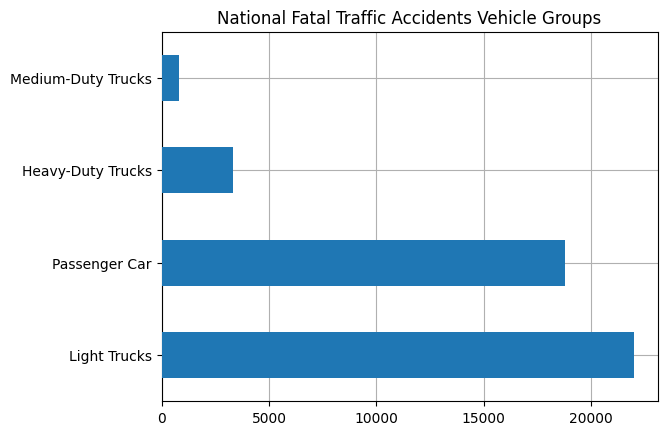

In [30]:
ax = farsVehVpicMergeDf["VehicleGroup"].value_counts().rename(vehicleGroupCat).plot.barh(title="National Fatal Traffic Accidents Vehicle Groups",zorder=3)
ax.grid(zorder=0)
farsVehVpicMergeDf["VehicleGroup"].value_counts().rename(vehicleGroupCat)

Light Trucks          529
Passenger Car         489
Heavy-Duty Trucks      80
Medium-Duty Trucks     17
Name: VehicleGroup, dtype: int64

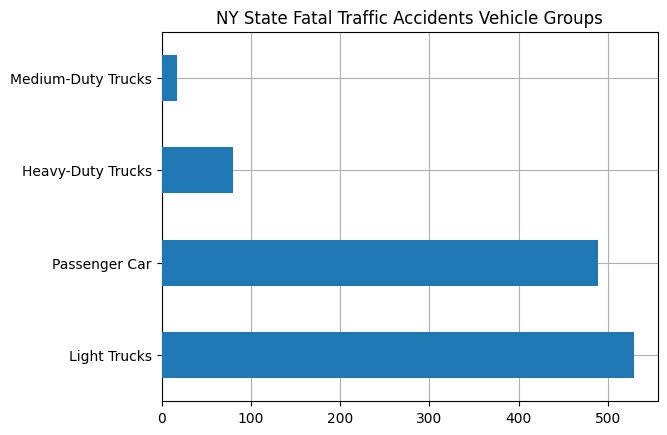

In [31]:
ax = farsVehVpicMergeDf[farsVehVpicMergeDf["STATE"]==36]["VehicleGroup"].value_counts().rename(vehicleGroupCat).plot.barh(title="NY State Fatal Traffic Accidents Vehicle Groups",zorder=3)
ax.grid(zorder=0)
farsVehVpicMergeDf[farsVehVpicMergeDf["STATE"]==36]["VehicleGroup"].value_counts().rename(vehicleGroupCat)

Light Trucks          6641135
Passenger Car         3576399
Medium-Duty Trucks     133028
Heavy-Duty Trucks      126918
Unknown                 56028
Large Trucks                2
Name: VehicleGroup, dtype: int64

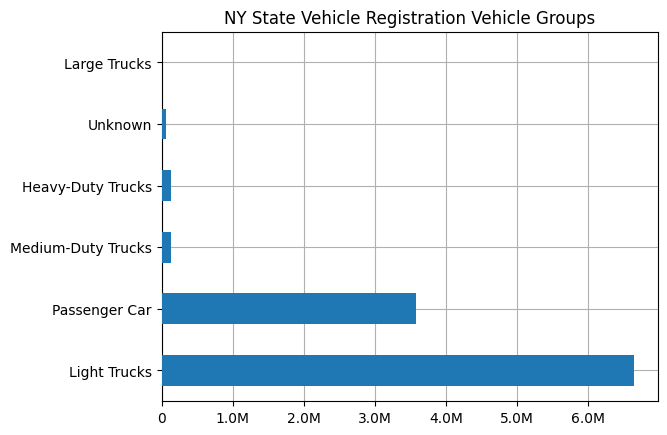

In [32]:
ax = nydmvVinDecodeDf["VehicleGroup"].value_counts().rename(vehicleGroupCat).plot.barh(title="NY State Vehicle Registration Vehicle Groups",zorder=3)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(millions))
ax.grid(zorder=0)
nydmvVinDecodeDf["VehicleGroup"].value_counts().rename(vehicleGroupCat)

In [33]:
unknownGroupQty = (nydmvVinDecodeDf["VehicleGroup"]==99).sum()
print("NYSDMV vehicles witthout grouping = ",unknownGroupQty,"(",unknownGroupQty/nydmvNumVehicles*100,"%)")

NYSDMV vehicles witthout grouping =  56028 ( 0.5319024712560201 %)


In [34]:
print("Body Types for Vehicles with Unknown Groups")
print(nydmvVinDecodeDf[nydmvVinDecodeDf["VehicleGroup"]==99]["Body Type"].value_counts())
print()

Body Types for Vehicles with Unknown Groups
ATV     11183
P/SH     9032
MCY      5607
TRLR     5286
RBM      3363
        ...  
POLE        0
AMBU        0
DCOM        0
RPLC        0
LOCO        0
Name: Body Type, Length: 57, dtype: int64



Vehicles in Unknown Group Type failed VIN API query (invalid VIN)

Remove some unknown types

Body Code | Body Style Description
--- | ---
MCY | MOTORCYCLE
ATV | ALL TERRAIN VEHICLE
P/SH | POWER SHOVEL
TRLR | TRAILER
RBM | ROAD BUILDING MACHINE
LTRL | LIGHT TRAILER
TRAC | TRACTOR
RD/S | ROAD SWEEPER
H/WH | HOUSE ON WHEELS
BUS | BUS(OMNIBUS)
MOPD | MOPED
T/CR | TRACTOR CRANE
FIRE | FIRE TRUCK
EMVR | EARTH MOVER
S/SP | SAND OR AGRICULTRAL SPREADER/SPRAYER
LSV | LOW SPEED VEHICLE
W/DR | WELL DRILLER
LSVT | LOW SPEED VEHICLE - TRUCK
W/SR | WELL SERVICING RIG
H/TR | HOUSE TRAILER
REFG | REFRIGERATOR TRAILER
FPM | FEED PROCESSING MACHINE
MCC | MOBILE CAR CRUSHER


In [35]:
# remove some of the non-applicable unknown types

nydmvIndRemoveIdx = nydmvVinDecodeDf[(nydmvVinDecodeDf["VehicleGroup"]==99) & 
    nydmvVinDecodeDf["Body Type"].isin(["MCY","ATV","P/SH","TRLR","RBM","LTRL","TRAC","RD/S","H/WH","BUS","MOPD","T/CR","FIRE","EMVR","S/SP","LSV","W/DR","LSVT","W/SR","H/TR","REFG","FPM","MCC"]
        )].index

print("Total to remove: ",len(nydmvIndRemoveIdx))


Total to remove:  42214


In [36]:
# remove selected body tyopes
nydmvVinDecodeDf.drop(index=nydmvIndRemoveIdx,inplace=True)

In [37]:
print("Body Types for Vehicles with Unknown Groups")
print(nydmvVinDecodeDf[nydmvVinDecodeDf["VehicleGroup"]==99]["Body Type"].value_counts())
print()
unknownGroupQty = (nydmvVinDecodeDf["VehicleGroup"]==99).sum()
print("NYSDMS vehicles witthout grouping = ",unknownGroupQty,"(",unknownGroupQty/nydmvNumVehicles*100,"%)")

Body Types for Vehicles with Unknown Groups
SUBN    3058
2DSD    2566
4DSD    1909
CONV    1318
SEMI     684
        ... 
MCC        0
MCY        0
P/SH       0
POLE       0
W/SR       0
Name: Body Type, Length: 57, dtype: int64

NYSDMS vehicles witthout grouping =  13814 ( 0.13114337006372995 %)


In [38]:
print("Body Types for Vehicles with Unknown Groups")
print(nydmvVinDecodeDf[nydmvVinDecodeDf["VehicleGroup"]==99]["Body Type"].value_counts())
print()

Body Types for Vehicles with Unknown Groups
SUBN    3058
2DSD    2566
4DSD    1909
CONV    1318
SEMI     684
        ... 
MCC        0
MCY        0
P/SH       0
POLE       0
W/SR       0
Name: Body Type, Length: 57, dtype: int64



In [39]:
unknownGroupQty = (nydmvVinDecodeDf["VehicleGroup"]==99).sum()
print("NYSDMS vehicles witthout grouping = ",unknownGroupQty,"(",unknownGroupQty/nydmvNumVehicles*100,"%)")
nydmvVinDecodeDf["VehicleGroup"].value_counts().rename(vehicleGroupCat)

NYSDMS vehicles witthout grouping =  13814 ( 0.13114337006372995 %)


Light Trucks          6641135
Passenger Car         3576399
Medium-Duty Trucks     133028
Heavy-Duty Trucks      126918
Unknown                 13814
Large Trucks                2
Name: VehicleGroup, dtype: int64

In [40]:
print("Unknown passenger veh          = ",len(nydmvVinDecodeDf[(nydmvVinDecodeDf["VehicleGroup"]==99) & nydmvVinDecodeDf["Body Type"].isin(["2DSD","4DSD","CONV","SEDN"])]))
print("Unknown passenger light trucks = ",len(nydmvVinDecodeDf[(nydmvVinDecodeDf["VehicleGroup"]==99) & nydmvVinDecodeDf["Body Type"].isin(["UTIL","SUBN","VAN"])]))

Unknown passenger veh          =  5846
Unknown passenger light trucks =  3952


Given that the unknown vehciles without VIN decode would fall under either Passenger Car or Large Truck, and they're < 0.13% of registrations they will be removed

In [41]:
# remove unknown vehicle groups and 
nydmvVinDecodeDf = nydmvVinDecodeDf[~nydmvVinDecodeDf["VehicleGroup"].isin([99,6])]

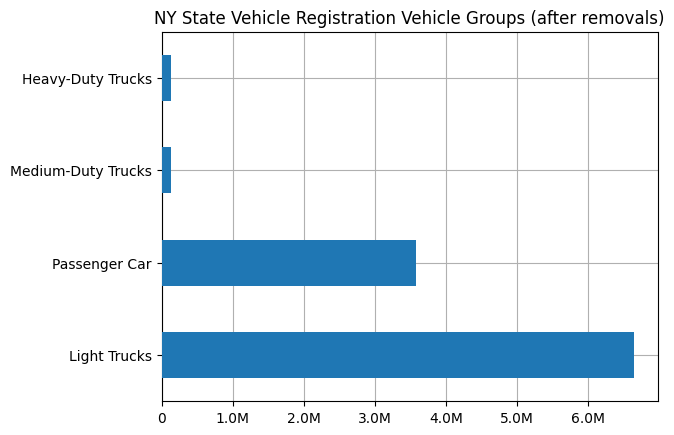

In [42]:
ax = nydmvVinDecodeDf["VehicleGroup"].value_counts().rename(vehicleGroupCat).plot.barh(title="NY State Vehicle Registration Vehicle Groups (after removals)",zorder=3)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(millions))
ax.grid(zorder=0)

In [43]:
# remove NAs
print((nydmvVinDecodeDf["ModelID"].isna()).sum()/len(nydmvVinDecodeDf)*100,"% of records removed from NYSDMV registration due to missing ModelId")
nydmvVinDecodeDf.dropna(subset=["ModelID"],inplace=True)
nydmvVinDecodeDf["ModelID"] = nydmvVinDecodeDf["ModelID"].astype("int64")
print("Remaining records = ",len(nydmvVinDecodeDf))

0.009105242863742044 % of records removed from NYSDMV registration due to missing ModelId
Remaining records =  10476526


## Update Safety Feature Indicators

Present safety Features as Boolean Columns (True/False) as follows:

| Original Feature Name | Boolean Feature Name | True Mapping[^1] 
| --- | --- | --- |
AdaptiveCruiseControlId | AdaptiveCruiseControl | 1:'Standard'
AdaptiveDrivingBeamId | AdaptiveDrivingBeam | 1:'Standard'
AntilockBrakeSystemId | AntilockBrakeSystem | 1:'Standard'
AutoPedestrianAlertingSoundId | AutoPedestrianAlertingSound | 1:'Standard'
BackupCameraId | BackupCamera |  1:'Standard'
BlindSpotInterventionId | BlindSpotIntervention | 1:'Standard'
BlindSpotWarningId | BlindSpotWarning | 1:'Standard'
CrashImminentBrakingID | CrashImminentBraking | 1:'Standard'
DaytimeRunningLightId | DaytimeRunningLight | 1:'Standard'
DynamicBrakeSupportId | DynamicBrakeSupport | 1:'Standard'
ElectronicStabilityControlId | ElectronicStabilityControl | 1:'Standard'
ForwardCollisionWarningId | ForwardCollisionWarning | 1:'Standard'
LaneCenteringAssistanceId | LaneCenteringAssistance | 1:'Standard'
LaneDepartureWarningId | LaneDepartureWarning |  1:'Standard'
LaneKeepingAssistanceId | LaneKeepingAssistance | 1:'Standard'
ParkAssistId | ParkAssist |  1:'Standard'
PedestrianAutoEmergencyBrakingId | PedestrianAutoEmergencyBraking | 1:'Standard'
RearAutomaticEmergencyBrakingId | RearAutomaticEmergencyBraking |  1:'Standard'
RearCrossTrafficAlertId | RearCrossTrafficAlert |  1:'Standard'
SemiAutoHeadlampBeamSwitchingId | SemiAutoHeadlampBeamSwitching | 1:'Standard'
TPMSId | TPMS | 1:'Direct', 2:'Indirect'
TractionControlId | TractionControl |  1:'Standard'

[^1]: Features marked as optional are assumed not present, NA are taken to mean feature not present

In [44]:
safetyColMap = {
    'AntilockBrakeSystemId' : 'AntilockBrakeSystem',
    'AdaptiveCruiseControlId' : 'AdaptiveCruiseControl',
    'AdaptiveDrivingBeamId' : 'AdaptiveDrivingBeam',
    'AutoPedestrianAlertingSoundId' : 'AutoPedestrianAlertingSound',
    'BlindSpotInterventionId' : 'BlindSpotIntervention',
    'BlindSpotWarningId' : 'BlindSpotWarning',
    'CrashImminentBrakingID' : 'CrashImminentBraking',
    'DaytimeRunningLightId' : 'DaytimeRunningLight',
    'DynamicBrakeSupportId' : 'DynamicBrakeSupport',
    'ElectronicStabilityControlId' : 'ElectronicStabilityControl',
    'ForwardCollisionWarningId' : 'ForwardCollisionWarning',
    'LaneCenteringAssistanceId' : 'LaneCenteringAssistance',
    'LaneDepartureWarningId' : 'LaneDepartureWarning',
    'LaneKeepingAssistanceId' : 'LaneKeepingAssistance',
    'ParkAssistId' : 'ParkAssist',
    'PedestrianAutoEmergencyBrakingId' : 'PedestrianAutoEmergencyBraking',
    'RearAutomaticEmergencyBrakingId' : 'RearAutomaticEmergencyBraking',
    'RearCrossTrafficAlertId' : 'RearCrossTrafficAlert',
    'SemiAutoHeadlampBeamSwitchingId' : 'SemiAutoHeadlampBeamSwitching',
    'TPMSId' : 'TPMS',
    'TractionControlId' : 'TractionControl',
}

def mapSafetyMostToFlag(x):
    if x == 1:
        return True
    return False

def mapSafetyTPMSToFlag(x):
    if x==1 or x==2:
        return True
    return False


In [45]:
# update Safety Features for Fars
for col in safetyColMap.keys():
    # new column name
    newCol = safetyColMap[col]
    if col == "TPMSId":
        farsVehVpicMergeDf[newCol] = farsVehVpicMergeDf[col].map(mapSafetyTPMSToFlag)
    else:
        farsVehVpicMergeDf[newCol] = farsVehVpicMergeDf[col].map(mapSafetyMostToFlag)

farsVehVpicMergeDf.drop(columns=safetyColMap.keys(),inplace=True)

farsVehVpicMergeDf.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44922 entries, 0 to 51434
Data columns (total 78 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ST_CASE                         44922 non-null  int64  
 1   VEH_NO                          44922 non-null  int64  
 2   NUMOCCS                         44922 non-null  int64  
 3   MAKE                            44922 non-null  int64  
 4   MAK_MOD                         44922 non-null  int64  
 5   BODY_TYP                        44922 non-null  int64  
 6   MOD_YEAR                        44922 non-null  int64  
 7   VIN                             44922 non-null  object 
 8   TOW_VEH                         44922 non-null  int64  
 9   TRAV_SP                         44922 non-null  int64  
 10  ROLLOVER                        44922 non-null  int64  
 11  IMPACT1                         44922 non-null  int64  
 12  M_HARM                          

In [46]:
farsVehVpicMergeDf[safetyColMap.values()].sum()

AntilockBrakeSystem                6399
AdaptiveCruiseControl              1061
AdaptiveDrivingBeam                1098
AutoPedestrianAlertingSound         179
BlindSpotIntervention                 0
BlindSpotWarning                   1154
CrashImminentBraking               1647
DaytimeRunningLight                4345
DynamicBrakeSupport                4858
ElectronicStabilityControl         5311
ForwardCollisionWarning            1699
LaneCenteringAssistance               5
LaneDepartureWarning               1420
LaneKeepingAssistance              1244
ParkAssist                          191
PedestrianAutoEmergencyBraking      968
RearAutomaticEmergencyBraking         0
RearCrossTrafficAlert               135
SemiAutoHeadlampBeamSwitching      4511
TPMS                              19521
TractionControl                    5096
dtype: int64

In [47]:
# update Safety Features for Fars
for col in safetyColMap.keys():
    # new column name
    newCol = safetyColMap[col]
    if col == "TPMSId":
        nydmvVinDecodeDf[newCol] = nydmvVinDecodeDf[col].map(mapSafetyTPMSToFlag)
    else:
        nydmvVinDecodeDf[newCol] = nydmvVinDecodeDf[col].map(mapSafetyMostToFlag)

nydmvVinDecodeDf.drop(columns=safetyColMap.keys(),inplace=True)

nydmvVinDecodeDf.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10476526 entries, 7306 to 12396967
Data columns (total 57 columns):
 #   Column                          Non-Null Count     Dtype         
---  ------                          --------------     -----         
 0   VIN                             10476526 non-null  object        
 1   Registration Class              10476526 non-null  category      
 2   City                            10476526 non-null  object        
 3   State                           10476526 non-null  category      
 4   Zip                             10476526 non-null  category      
 5   County                          10476526 non-null  object        
 6   Model Year                      10476526 non-null  Int64         
 7   Make                            10476526 non-null  category      
 8   Body Type                       10476526 non-null  category      
 9   Fuel Type                       10476526 non-null  category      
 10  Unladen Weight           

In [48]:
nydmvVinDecodeDf[safetyColMap.values()].sum()

AntilockBrakeSystem               3966836
AdaptiveCruiseControl             1372224
AdaptiveDrivingBeam                897612
AutoPedestrianAlertingSound        190366
BlindSpotIntervention              110699
BlindSpotWarning                  1581518
CrashImminentBraking              1742612
DaytimeRunningLight               3410742
DynamicBrakeSupport               3040208
ElectronicStabilityControl        3672551
ForwardCollisionWarning           2081613
LaneCenteringAssistance            337621
LaneDepartureWarning              1893497
LaneKeepingAssistance             1658239
ParkAssist                         317136
PedestrianAutoEmergencyBraking    1209819
RearAutomaticEmergencyBraking      122882
RearCrossTrafficAlert              733509
SemiAutoHeadlampBeamSwitching     3307500
TPMS                              7803073
TractionControl                   3544278
dtype: int64

## Merge FARS Vehicle and Accident Tables

In [49]:
# merge fars accident with fars vehicle

farsAccVehMerge = pd.merge(farsAccidentDf,farsVehVpicMergeDf.drop(columns="STATE"), on="ST_CASE", how="right",validate="one_to_many")
farsAccVehMerge = pd.merge(farsAccVehMerge,farsPersonDf,on=["ST_CASE","VEH_NO"],how="left")
farsAccVehMerge.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44922 entries, 0 to 44921
Columns: 102 entries, STATE to AGE
dtypes: bool(23), float64(11), int64(61), object(7)
memory usage: 28.4+ MB


In [50]:
# accidents that involve vehicles of interest are kept
print(len(farsAccidentDf),len(farsAccVehMerge["ST_CASE"].unique()), len(farsVehVpicMergeDf),len(farsAccVehMerge[["VEH_NO","ST_CASE"]].drop_duplicates()))

34119 31186 44922 44922


## Tag Vehicles in FARS as per induced exposure model

Following Induced Exposure Model Approach from [1]: *"...the set of comparison crashes was defined to be all multivehicle crashes where the focus vehicle was impacted from the rear or to either side. Risk was assessed to be the odds of all other crash types (frontal impact multivehicle crashes or single-vehicle crashes) compared to the comparison crashes."* and similarly in [2] "the vehicles/drivers involved in ... crashes can be split into striking group and struck group respectively. This analysis method is based on Quasi-induced exposure concept. Here, the striking vehicles/drivers can be considered as the at-fault ones and the struck vehicles/drivers are not-at-fault ones."

The IMPACT1 variable indicates where impact ocurred

![IMPACT1](FARS-AREAOFIMPACT.jpg)

Front = 1,11,12

[1] Michael D. Keall & Stuart Newstead (2016) Development of a method to rate the primary safety of vehicles using linked New Zealand crash and vehicle licensing data, Traffic Injury Prevention, 17:2, 151-158, DOI: 10.1080/15389588.2015.1045064

[2] Xuedong Yan & Essam Radwan (2006) Analyses of Rear-End Crashes Based on Classification Tree Models, Traffic Injury Prevention, 7:3, 276-282, DOI: 10.1080/15389580600660062

In [51]:
farsAccVehMerge["IMPACT1"].value_counts().sort_index().rename(farsCategories["IMPACT1"])

Non-Collision                             1910
1 Clock Point                             1784
2 Clock Point                              554
3 Clock Point                             1626
4 Clock Point                              309
5 Clock Point                              381
6 Clock Point                             2884
7 Clock Point                              459
8 Clock Point                              343
9 Clock Point                             1909
10 Clock Point                             636
11 Clock Point                            1949
12 Clock Point                           25203
Top                                        115
Undercarriage                              458
Cargo/Vehicle Parts Set-In-Motion           21
Other Objects or Person Set-In-Motion       15
Left                                       718
Left-Front Side                            581
Left-Back Side                             239
Right                                      566
Right-Front S

In [52]:
# Find comparison crashes (i.e. vehicle not at fault) 
print("Multivehicle Crashes                  =",(farsAccVehMerge["VE_TOTAL"] > 1).sum())
print("Vehicles impacted to the side or rear =",(~farsAccVehMerge["IMPACT1"].isin([1,12,11])).sum())
print("Comparison crashes                    =",((farsAccVehMerge["VE_TOTAL"] > 1) & ~farsAccVehMerge["IMPACT1"].isin([1,11,12])).sum())

Multivehicle Crashes                  = 29065
Vehicles impacted to the side or rear = 15986
Comparison crashes                    = 10803


In [53]:
# remove unknown and not reported
print("Removing ",farsAccVehMerge["IMPACT1"].isin([98,99]).sum()," records ")
farsAccVehMerge = farsAccVehMerge[~farsAccVehMerge["IMPACT1"].isin([98,99])]

Removing  1582  records 


In [54]:
# Find comparison crashes (i.e. vehicle not at fault) 
print("Multivehicle Crashes                  =",(farsAccVehMerge["VE_TOTAL"] > 1).sum())
print("Vehicles impacted to the side or rear =",(~farsAccVehMerge["IMPACT1"].isin([1,12,11])).sum())
print("Comparison crashes                    =",((farsAccVehMerge["VE_TOTAL"] > 1) & ~farsAccVehMerge["IMPACT1"].isin([1,11,12])).sum())

Multivehicle Crashes                  = 28585
Vehicles impacted to the side or rear = 14404
Comparison crashes                    = 10323


In [55]:
# Mark vehicles as Fault = False, for comparison crashes (exposure)
# Mark vehicles as Fault = True, for where vehicle is potentially the cause of the accident
farsAccVehMerge["Fault"] = ~((farsAccVehMerge["VE_TOTAL"] > 1) & ~farsAccVehMerge["IMPACT1"].isin([1,11,12]))
# check fault tag counts
farsAccVehMerge["Fault"].value_counts()

True     33017
False    10323
Name: Fault, dtype: int64

Note see below, not able to differentiate between the 2 vehicles in teh crash so Fault will be remain as is for muti-fault crashes as it indicates exposure for both vehicles wiht the availabel information

In [56]:
def combine_values_asstr(xval):
    s = ""
    for x in xval:
        s = s + str(x) + ","
    return s
# find number of accidents with double faults
farsFaultsPerAcc = farsAccVehMerge[["ST_CASE","Fault"]].groupby("ST_CASE").sum()
mutiFaultCases = farsFaultsPerAcc[farsFaultsPerAcc["Fault"] > 1].index.values
print("Accidents with mutilple Veh as Fault = ",len(mutiFaultCases))
farsAccVehMutilFault =  farsAccVehMerge[farsAccVehMerge["ST_CASE"].isin(mutiFaultCases)][["ST_CASE","M_HARM_SIMP"]].groupby("ST_CASE").agg(combine_values_asstr)
print(farsAccVehMutilFault.value_counts())

Accidents with mutilple Veh as Fault =  4845
M_HARM_SIMP   
5,5,              3273
5,5,5,             735
5,5,5,5,           171
12,12,              89
14,5,               50
                  ... 
5,5,3,5,5,5,5,       1
5,5,3,5,             1
14,6,6,              1
14,8,                1
9,9,                 1
Length: 126, dtype: int64


## Additional prep work on FARS Accident / FARS Vehicle / FARS VPICdecode

In [57]:
# check missing model id
farsAccVehMerge[farsAccVehMerge["ModelId"].isna()]

STATE  ST_CASE  VE_TOTAL  VE_FORMS  PVH_INVL  PEDS  PERSONS  PERMVIT  \
15876     17   170857         2         2         0     0        3        3   

       PERNOTMVIT  DAY  MONTH  YEAR  DAY_WEEK  HOUR  MINUTE  ROUTE  RUR_URB  \
15876           0   25      9  2020         6    13      35      2        2   

       FUNC_SYS  HARM_EV  MAN_COLL  LGT_COND  WEATHER  FATALS  HARM_EV_SIMP  \
15876         3       12        11         1        1       2             5   

       VEH_NO  NUMOCCS  MAKE  MAK_MOD  BODY_TYP  MOD_YEAR           VIN  \
15876       1        1    86    86898        63      1994  1M2AM32C7RM0   

       TOW_VEH  TRAV_SP  ROLLOVER  IMPACT1  M_HARM  DR_PRES  L_STATUS  L_TYPE  \
15876        1      998         0        8      12        1         9       9   

       PREV_ACC  PREV_DWI  PREV_SPD  PREV_OTH  SPEEDREL  VNUM_LAN  VSPD_LIM  \
15876        99        99        99        99         0         2        55   

       VSURCOND  P_CRASH2  ACC_TYPE  DEATHS  DR_DRINK  VPICMAKE  VPICMODEL  \
15876         1        98        98       0         0       490      99999   

       VPICBODYCLASS  GVWR_FROM  GVWR_TO  M_HARM_SIMP  VehicleDescriptor  \
15876             11         18       18            5  1M2AM32C*RM******   

      VINDecodeError  VehicleTypeId  ManufacturerFullNameId  MakeId  ModelId  \
15876              0             10                    1027     490      NaN   

       ModelYear Series    Trim Series2 Trim2  BodyClassId  DoorsCount  \
15876       1994    NaN  RB688S     NaN   NaN         11.0         NaN   

       GrossVehicleWeightRatingFromId  GrossVehicleWeightRatingToId  \
15876                             9.0                           NaN   

       SeatsCount  EngineCylindersCount  BackupCameraId  \
15876         NaN                   NaN             NaN   

       HeadlampLightSourceId  AnySafetyFeature  GoodVPICDecode  VehicleGroup  \
15876                    NaN             False            True             8   

       AntilockBrakeSystem  AdaptiveCruiseControl  AdaptiveDrivingBeam  \
15876                False                  False                False   

       AutoPedestrianAlertingSound  BlindSpotIntervention  BlindSpotWarning  \
15876                        False                  False             False   

       CrashImminentBraking  DaytimeRunningLight  DynamicBrakeSupport  \
15876                 False                False                False   

       ElectronicStabilityControl  ForwardCollisionWarning  \
15876                       False                    False   

       LaneCenteringAssistance  LaneDepartureWarning  LaneKeepingAssistance  \
15876                    False                 False                  False   

       ParkAssist  PedestrianAutoEmergencyBraking  \
15876       False                           False   

       RearAutomaticEmergencyBraking  RearCrossTrafficAlert  \
15876                          False                  False   

       SemiAutoHeadlampBeamSwitching   TPMS  TractionControl  SEX   AGE  Fault  
15876                          False  False            False  1.0  69.0  False

In [58]:
# fix the one :-)
farsAccVehMerge.at[15876,"ModelId"] = farsAccVehMerge[(farsAccVehMerge["MakeId"] == 490) & (farsAccVehMerge["VehicleGroup"] == 8)]["ModelId"].value_counts().index[0]
farsAccVehMerge["ModelId"] = farsAccVehMerge["ModelId"].astype("int64")

In [59]:
# Missing age record
(farsAccVehMerge["AGE"] >= 998).sum()/len(farsAccVehMerge["AGE"])*100

0.6206737425011537

In [60]:
farsAccVehMerge[farsAccVehMerge["AGE"] < 998]["AGE"].describe()

count    42829.000000
mean        42.484835
std         18.233661
min          2.000000
25%         27.000000
50%         39.000000
75%         56.000000
max        102.000000
Name: AGE, dtype: float64

In [61]:
farsAccVehMerge["AGE"].isna().sum()

242

In [62]:
# impute age as median for 998, 999 (unknown, unfiled)
ageMedian = farsAccVehMerge[farsAccVehMerge["AGE"] < 998]["AGE"].median()
farsAccVehMerge["AGE"] = farsAccVehMerge["AGE"].replace([998,999],ageMedian).fillna(ageMedian).astype("int64")

In [63]:
# check out suspicious driver ages... leave or keep? will keep for now since we'll be using age group instead of actual age
farsAccVehMerge[farsAccVehMerge["AGE"] < 10]

STATE  ST_CASE  VE_TOTAL  VE_FORMS  PVH_INVL  PEDS  PERSONS  PERMVIT  \
5013       6    61664         2         2         0     2        4        4   
13476     13   130779         2         2         0     0        4        4   
19295     22   220221         1         1         0     2        1        1   
24228     29   290274         1         1         0     0        2        2   
27959     36   360771         2         2         0     1        3        3   
38260     48   480896         5         4         1     3        4        4   
38611     48   481178         2         2         0     0        3        3   

       PERNOTMVIT  DAY  MONTH  YEAR  DAY_WEEK  HOUR  MINUTE  ROUTE  RUR_URB  \
5013            2   16     10  2020         6    19      35      6        1   
13476           0   25      7  2020         7    12       0      3        2   
19295           2   16      5  2020         7    20      25      3        1   
24228           0   29      5  2020         6    16      20      4        1   
27959           1    8     11  2020         1    18      55      3        2   
38260           3   10      4  2020         6     1      36      1        2   
38611           0   24      5  2020         1     4      58      1        2   

       FUNC_SYS  HARM_EV  MAN_COLL  LGT_COND  WEATHER  FATALS  HARM_EV_SIMP  \
5013          4        8         0         2        1       1            12   
13476         7       12         6         1        1       2             5   
19295         5       10         0         3        2       1            13   
24228         5       58         0         1        1       2            10   
27959         2        8         0         2       10       1            12   
38260         1       12         6         3       10       2             5   
38611         1       12         1         2       10       2             5   

       VEH_NO  NUMOCCS  MAKE  MAK_MOD  BODY_TYP  MOD_YEAR           VIN  \
5013        2        2    20    20423        15      2014  1GNKRGKD6EJ1   
13476       1        3    41    41047         4      1998  JM1TA2215W14   
19295       1        1    20    20401        14      1997  1GNCS18W5VK1   
24228       1        2    18    18022         4      2007  2G4WC5821712   
27959       1        2    37    37441        20      2012  5FNRL5H61CB0   
38260       4        2    13    13421        15      1998  5LMPU28L3WLJ   
38611       1        2    24    24010         6      2008  5GZER23768J1   

       TOW_VEH  TRAV_SP  ROLLOVER  IMPACT1  M_HARM  DR_PRES  L_STATUS  L_TYPE  \
5013         0        0         0        3      12        0         7       6   
13476        0      998         0        3      12        1         6       1   
19295        0        0         0        2      10        0         7       6   
24228        0       35         1       14       1        0         7       6   
27959        0        0         0       11      12        0         7       6   
38260        0        0         0        6      12        0         7       6   
38611        0        0         0        6      12        0         7       6   

       PREV_ACC  PREV_DWI  PREV_SPD  PREV_OTH  SPEEDREL  VNUM_LAN  VSPD_LIM  \
5013        998       998       998       998         8         2        55   
13476         0         0         0         0         0         4        40   
19295       998       998       998       998         8         2        25   
24228       998       998       998       998         8         2        45   
27959       998       998       998       998         8         2        55   
38260       998       998       998       998         8         6        65   
38611       998       998       998       998         8         2        75   

       VSURCOND  P_CRASH2  ACC_TYPE  DEATHS  DR_DRINK  VPICMAKE  VPICMODEL  \
5013          1        98        98       0         0       467       1853   
13476         1        17        87       2         0       473      

In [64]:
# create age group ranges, and add a numeric variable representing this age to simplify correlation calculations
farsAccVehMerge["AGE_GRPNAME"] = pd.cut(farsAccVehMerge["AGE"],[0,14,24,34,44,54,64,200],labels=["<15","15-24","25-34","35-44","45-54","55-64",">65"])
farsAccVehMerge["AGE_GRP"] = pd.factorize(farsAccVehMerge["AGE_GRPNAME"])[0]
# create speed limit ranges, and add a numeric variable representing this age to simplify correlation calculations
print(farsAccVehMerge["AGE_GRPNAME"].value_counts(dropna=False)/len(farsAccVehMerge))
farsCategories["AGE_GRP"] = dict(np.array(farsAccVehMerge[["AGE_GRP","AGE_GRPNAME"]].drop_duplicates()))
farsAccVehMerge.drop(columns="AGE_GRPNAME",inplace=True)

25-34    0.223004
15-24    0.184610
35-44    0.180018
45-54    0.141924
>65      0.136940
55-64    0.132464
<15      0.001038
Name: AGE_GRPNAME, dtype: float64


In [65]:
# inpute SEX to 9 -> Female, Nan and 8 -> Male to maintain 70:30 proportion
farsAccVehMerge["SEX"] = farsAccVehMerge["SEX"].replace(9,2).replace(8,1).fillna(1).astype("int64")

In [66]:
farsAccVehMerge["SEX"].value_counts(dropna=False)/len(farsAccVehMerge)

1    0.716728
2    0.283272
Name: SEX, dtype: float64

In [67]:
# add column indicating if the accident impacted pedestrians
farsAccVehMerge["Pedestrian"] = farsAccVehMerge["PEDS"] > 0
# add column indicating is the vehicle had any safey feature
farsAccVehMerge["AnySafetyFeature"] = farsAccVehMerge[safetyColMap.values()].apply(lambda row: sum(row) > 0,axis=1)

In [68]:
# set speed limit for cases missing it (speed limit = 98 and 99 means missing values)
print(farsAccVehMerge["VSPD_LIM"].value_counts(dropna=False).sort_index()/len(farsAccVehMerge))
wAvgSpd = farsAccVehMerge[farsAccVehMerge["VSPD_LIM"]<98]["VSPD_LIM"].sum()/(farsAccVehMerge["VSPD_LIM"]<98).sum()
print("Median speed limit = ",farsAccVehMerge[farsAccVehMerge["VSPD_LIM"]<98]["VSPD_LIM"].median())
farsAccVehMerge["VSPD_LIM"] = farsAccVehMerge["VSPD_LIM"].replace([98,99],round(wAvgSpd/5)*5)
print(farsAccVehMerge["VSPD_LIM"].value_counts(dropna=False).sort_index()/len(farsAccVehMerge))


0     0.008976
5     0.000300
10    0.000554
15    0.001477
20    0.002238
25    0.040863
30    0.044209
35    0.101292
40    0.070235
45    0.158006
50    0.046262
55    0.256461
60    0.039986
65    0.094762
70    0.072473
75    0.021551
80    0.002884
85    0.000046
98    0.033272
99    0.004153
Name: VSPD_LIM, dtype: float64
Median speed limit =  55.0
0     0.008976
5     0.000300
10    0.000554
15    0.001477
20    0.002238
25    0.040863
30    0.044209
35    0.101292
40    0.070235
45    0.158006
50    0.083687
55    0.256461
60    0.039986
65    0.094762
70    0.072473
75    0.021551
80    0.002884
85    0.000046
Name: VSPD_LIM, dtype: float64


Reduce number of Speed Limit classes, but creating 4 groups
* < 20 Km/h
* 20-40
* 40-60
* 60-80
* \> 80 


In [69]:
# create speed limit ranges, and add a numeric variable representing this age to simplify correlation calculations
farsAccVehMerge["VSPD_LIM_GRPNAME"] = pd.cut(farsAccVehMerge["VSPD_LIM"],[0,20,40,60,80,200],labels=["<20","20-40","40-60","60-80",">80"],right=False)
farsAccVehMerge["VSPD_LIM_GRP"] = pd.factorize(farsAccVehMerge["VSPD_LIM_GRPNAME"])[0]
print(farsAccVehMerge["VSPD_LIM_GRPNAME"].value_counts(dropna=False).sort_index()/len(farsAccVehMerge))
farsCategories["VSPD_LIM_GRP"] = dict(np.array(farsAccVehMerge[["VSPD_LIM_GRP","VSPD_LIM_GRPNAME"]].drop_duplicates()))
farsAccVehMerge.drop(columns="VSPD_LIM_GRPNAME",inplace=True)

<20      0.011306
20-40    0.188602
40-60    0.568389
60-80    0.228772
>80      0.002930
Name: VSPD_LIM_GRPNAME, dtype: float64


In [70]:
# Check VNUM_LAN not reported or unknown
farsAccVehMerge["VNUM_LAN"].value_counts(dropna=False).sort_index()/len(farsAccVehMerge)

0    0.008076
1    0.013521
2    0.619128
3    0.132949
4    0.107476
5    0.081980
6    0.018528
7    0.011444
8    0.006691
9    0.000208
Name: VNUM_LAN, dtype: float64

In [71]:
# drop unknown/unreported number of lanes
farsAccVehMerge = farsAccVehMerge[farsAccVehMerge["VNUM_LAN"]<8]

In [72]:
# Check FUNC_SYS not reported or unknown
farsAccVehMerge["FUNC_SYS"].value_counts(dropna=False).sort_index()/len(farsAccVehMerge)

1     0.144095
2     0.044400
3     0.318603
4     0.221579
5     0.136800
6     0.026579
7     0.088195
96    0.001069
98    0.017820
99    0.000860
Name: FUNC_SYS, dtype: float64

In [73]:
# drop unknown/unreported number of lanes
farsAccVehMerge = farsAccVehMerge[farsAccVehMerge["FUNC_SYS"]<96]

In [74]:
farsAccVehMerge.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42191 entries, 0 to 44921
Columns: 106 entries, STATE to VSPD_LIM_GRP
dtypes: bool(25), float64(8), int64(66), object(7)
memory usage: 27.4+ MB


In [75]:
# Check any safety features that may be removed form the checks
farsTotSafetyFeat = farsAccVehMerge[safetyColMap.values()].sum()
farsTotSafetyFeat

AntilockBrakeSystem                6032
AdaptiveCruiseControl              1003
AdaptiveDrivingBeam                1027
AutoPedestrianAlertingSound         170
BlindSpotIntervention                 0
BlindSpotWarning                   1090
CrashImminentBraking               1549
DaytimeRunningLight                4098
DynamicBrakeSupport                4579
ElectronicStabilityControl         5003
ForwardCollisionWarning            1603
LaneCenteringAssistance               4
LaneDepartureWarning               1335
LaneKeepingAssistance              1167
ParkAssist                          177
PedestrianAutoEmergencyBraking      909
RearAutomaticEmergencyBraking         0
RearCrossTrafficAlert               127
SemiAutoHeadlampBeamSwitching      4252
TPMS                              18333
TractionControl                    4809
dtype: int64

In [76]:
# remove features present in less than 100 vehicles
# RearCrossTrafficAlert and ParkAssist features removed due to the way Fault is being defined
safetFeatureList = list(farsTotSafetyFeat[farsTotSafetyFeat >= 100].drop(["RearCrossTrafficAlert","ParkAssist"]).index.values)
safetFeatureList

['AntilockBrakeSystem',
 'AdaptiveCruiseControl',
 'AdaptiveDrivingBeam',
 'AutoPedestrianAlertingSound',
 'BlindSpotWarning',
 'CrashImminentBraking',
 'DaytimeRunningLight',
 'DynamicBrakeSupport',
 'ElectronicStabilityControl',
 'ForwardCollisionWarning',
 'LaneDepartureWarning',
 'LaneKeepingAssistance',
 'PedestrianAutoEmergencyBraking',
 'SemiAutoHeadlampBeamSwitching',
 'TPMS',
 'TractionControl']

In [77]:
# Redefine AnySafetyFeature to only includ features above
def AnyStdSafetyFeature(Row):
	"""Returns true if any of the safety features are marked standard for the vehicle checked 
	(vpicdecode columnnames are used)attribute value = 1 means standard
	"""
	
	stdFeatureFlag = False
	for feat in safetFeatureList:
		stdFeatureFlag = stdFeatureFlag | (Row[feat] == 1)
	return stdFeatureFlag

farsAccVehMerge["AnySafetyFeature"] = farsAccVehMerge.apply(lambda row: AnyStdSafetyFeature(row),axis=1)

## Features to Train Models

In [78]:
# Additional columns to keep for modeling 
columns2Keep = ['STATE', 'ST_CASE', 'VEH_NO', 'RUR_URB', 'FUNC_SYS', 'VNUM_LAN', 'LGT_COND', 'WEATHER', 
       'VSURCOND',  'DR_DRINK', # 'ACC_TYPE', 'IMPACT1', 'MAN_COLL', 'M_HARM_SIMP',  
       'VSPD_LIM_GRP', 'ModelId', 'ModelYear', 'Pedestrian',
       'VehicleGroup', 'AnySafetyFeature','SEX', 'AGE_GRP', 'Fault'] + safetFeatureList

In [79]:
farsAccVehMergeLight = farsAccVehMerge[columns2Keep].copy()
farsAccVehMergeLight.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42191 entries, 0 to 44921
Data columns (total 35 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   STATE                           42191 non-null  int64
 1   ST_CASE                         42191 non-null  int64
 2   VEH_NO                          42191 non-null  int64
 3   RUR_URB                         42191 non-null  int64
 4   FUNC_SYS                        42191 non-null  int64
 5   VNUM_LAN                        42191 non-null  int64
 6   LGT_COND                        42191 non-null  int64
 7   WEATHER                         42191 non-null  int64
 8   VSURCOND                        42191 non-null  int64
 9   DR_DRINK                        42191 non-null  int64
 10  VSPD_LIM_GRP                    42191 non-null  int64
 11  ModelId                         42191 non-null  int64
 12  ModelYear                       42191 non-null  int64
 13  P

In [80]:
# use this for most of the calculations
#farsAccVehMergeLighter = farsAccVehMergeLight.drop(columns=["STATE","ST_CASE","VEH_NO","HOUR","ModelId","ModelYear","AGE_GRP"]+list(safetyColMap.values()))
farsAccVehMergeLighter = farsAccVehMergeLight.drop(columns=["STATE","ST_CASE","VEH_NO"]+safetFeatureList)
corr1 = farsAccVehMergeLighter.corr(method = "spearman")
corr1

RUR_URB  FUNC_SYS  VNUM_LAN  LGT_COND   WEATHER  VSURCOND  \
RUR_URB           1.000000 -0.186726  0.409801  0.186419 -0.052114 -0.052892   
FUNC_SYS         -0.186726  1.000000 -0.294015 -0.077901  0.000655  0.000790   
VNUM_LAN          0.409801 -0.294015  1.000000  0.144192 -0.033391  0.005809   
LGT_COND          0.186419 -0.077901  0.144192  1.000000 -0.010331  0.034964   
WEATHER          -0.052114  0.000655 -0.033391 -0.010331  1.000000  0.383919   
VSURCOND         -0.052892  0.000790  0.005809  0.034964  0.383919  1.000000   
DR_DRINK         -0.042766  0.091524 -0.070419  0.169184 -0.005620 -0.003162   
VSPD_LIM_GRP      0.010941 -0.351945 -0.018150  0.033200  0.017817 -0.047493   
ModelId          -0.004905 -0.045202 -0.001519 -0.007955  0.010383  0.001468   
ModelYear         0.088232 -0.119053  0.091475  0.006632 -0.013419 -0.013634   
Pedestrian        0.207564 -0.037084  0.158038  0.213763 -0.039482 -0.028275   
VehicleGroup     -0.132047 -0.053867 -0.057260 -0.102168  0.013430  0.008232   
AnySafetyFeature  0.140529 -0.035956  0.098679  0.046737 -0.019515 -0.025304   
SEX               0.033162  0.010114  0.019081 -0.041999 -0.005509 -0.019222   
AGE_GRP          -0.041514 -0.017252 -0.024771 -0.111564  0.009199 -0.009355   
Fault            -0.080698  0.131648 -0.072900  0.084732  0.020329  0.028402   

                  DR_DRINK  VSPD_LIM_GRP   ModelId  ModelYear  Pedestrian  \
RUR_URB          -0.042766      0.010941 -0.004905   0.088232    0.207564   
FUNC_SYS          0.091524     -0.351945 -0.045202  -0.119053   -0.037084   
VNUM_LAN         -0.070419     -0.018150 -0.001519   0.091475    0.158038   
LGT_COND          0.169184      0.033200 -0.007955   0.006632    0.213763   
WEATHER          -0.005620      0.017817  0.010383  -0.013419   -0.039482   
VSURCOND         -0.003162     -0.047493  0.001468  -0.013634   -0.028275   
DR_DRINK          1.000000     -0.020891 -0.028316  -0.101213   -0.110109   
VSPD_LIM_GRP     -0.020891      1.000000  0.029301   0.055051    0.009384   
ModelId          -0.028316      0.029301  1.000000   0.016671   -0.017061   
ModelYear        -0.101213      0.055051  0.016671   1.000000    0.049540   
Pedestrian       -0.110109      0.009384 -0.017061   0.049540    1.000000   
VehicleGroup     -0.092968      0.063911  0.086198   0.050224   -0.016900   
AnySafetyFeature -0.036883     -0.009595 -0.080548   0.643114    0.060094   
SEX              -0.066732     -0.017167 -0.003393   0.080006    0.009917   
AGE_GRP          -0.081651     -0.002432  0.046790   0.025502   -0.015001   
Fault             0.144418     -0.052824 -0.041404  -0.040096    0.155661   

                  VehicleGroup  AnySafetyFeature       SEX   AGE_GRP     Fault  
RUR_URB              -0.132047          0.140529  0.033162 -0.041514 -0.080698  
FUNC_SYS             -0.053867         -0.035956  0.010114 -0.017252  0.131648  
VNUM_LAN             -0.057260          0.098679  0.019081 -0.024771 -0.072900  
LGT_COND             -0.102168          0.046737 -0.041999 -0.111564  0.084732  
WEATHER               0.013430         -0.019515 -0.005509  0.009199  0.020329  
VSURCOND              0.008232         -0.025304 -0.019222 -0.009355  0.028402  
DR_DRINK             -0.092968         -0.036883 -0.066732 -0.081651  0.144418  
VSPD_LIM_GRP          0.063911         -0.009595 -0.017167 -0.002432 -0.052824  
ModelId               0.086198         -0.080548 -0.003393  0.046790 -0.041404  
ModelYear             0.050224          0.643114  0.080006  0.025502 -0.040096  
Pedestrian           -0.016900          0.060094  0.009917 -0.015001  0.155661  
VehicleGroup          1.000000         -0.302750 -0.156478  0.185072 -0.003068  
AnySafetyFeature     -0.302750          1.000000  0.204782 -0.051607 -0.019648  
SEX                  -0.156478          0.204782  1.000000 -0.015719 -0.048706  
AGE_GRP               0.185072         -0.051607 -0.015719  1.000000 -0.057867  
Fault                -0.003068         -0.019648 -0.

<AxesSubplot: >

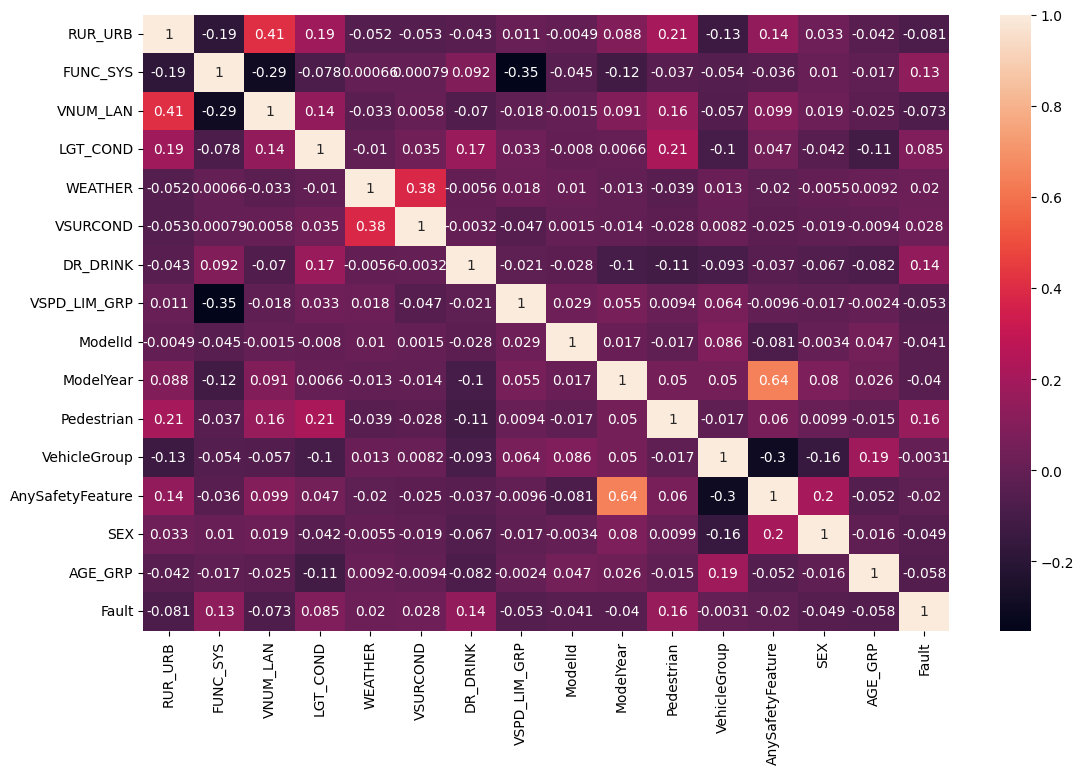

In [81]:
f, ax = plt.subplots(figsize=(13, 8))
sns.heatmap(corr1, annot=True, ax=ax)

## Prepare DataFrame with top 20 vehicle models only

In [82]:
farsAccVehMergeLightTopMod = farsAccVehMergeLight[farsAccVehMergeLight["ModelId"].isin(farsTopModels["ModelId"].values)]
farsAccVehMergeLightTopMod.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14278 entries, 2 to 44921
Data columns (total 35 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   STATE                           14278 non-null  int64
 1   ST_CASE                         14278 non-null  int64
 2   VEH_NO                          14278 non-null  int64
 3   RUR_URB                         14278 non-null  int64
 4   FUNC_SYS                        14278 non-null  int64
 5   VNUM_LAN                        14278 non-null  int64
 6   LGT_COND                        14278 non-null  int64
 7   WEATHER                         14278 non-null  int64
 8   VSURCOND                        14278 non-null  int64
 9   DR_DRINK                        14278 non-null  int64
 10  VSPD_LIM_GRP                    14278 non-null  int64
 11  ModelId                         14278 non-null  int64
 12  ModelYear                       14278 non-null  int64
 13  P

## Prepare Train and Test data (All Vehicles)

In [83]:
from sklearn.model_selection import train_test_split

featuresToTrain = [
    # all features
    [
        'ModelId', 'ModelYear', 'VehicleGroup', 
        'SEX', 'AGE_GRP', 'DR_DRINK',
        'RUR_URB', 'FUNC_SYS', 'VNUM_LAN', 'LGT_COND', 'WEATHER', 'VSURCOND', 'VSPD_LIM_GRP','Pedestrian',  
        #'AnySafetyFeature',
    ] + safetFeatureList,
    # removing vehicle model
    [
        'ModelYear', 'VehicleGroup', 
        'SEX', 'AGE_GRP', 'DR_DRINK',
        'RUR_URB', 'FUNC_SYS', 'VNUM_LAN', 'LGT_COND', 'WEATHER', 'VSURCOND', 'VSPD_LIM_GRP','Pedestrian',  
        #'AnySafetyFeature',
    ] + safetFeatureList,
    # only one safety feature
    [
        'ModelId', 'ModelYear', 'VehicleGroup', 
        'SEX', 'AGE_GRP', 'DR_DRINK',
        'RUR_URB', 'FUNC_SYS', 'VNUM_LAN', 'LGT_COND', 'WEATHER', 'VSURCOND', 'VSPD_LIM_GRP','Pedestrian',  
        #'AnySafetyFeature',
        'AntilockBrakeSystem'
    ],
    # removing driver factors
    [
        'ModelId', 'ModelYear', 'VehicleGroup', 
        #'SEX', 'AGE_GRP', 'DR_DRINK',
        'RUR_URB', 'FUNC_SYS', 'VNUM_LAN', 'LGT_COND', 'WEATHER', 'VSURCOND', 'VSPD_LIM_GRP','Pedestrian',  
        #'AnySafetyFeature',
    ] + safetFeatureList,
     # removing driver factors and detailed safety features
    [
        'ModelId', 'ModelYear', 'VehicleGroup', 
        #'SEX', 'AGE_GRP', 'DR_DRINK',
        'RUR_URB', 'FUNC_SYS', 'VNUM_LAN', 'LGT_COND', 'WEATHER', 'VSURCOND', 'VSPD_LIM_GRP','Pedestrian',  
        'AnySafetyFeature',
     ], #+ safetFeatureList,
 ]


In [84]:
# remove additional entried flagged as unknown, kept in the original dataframe for the overall Effectiveness check

F0 = farsAccVehMergeLight[~(farsAccVehMergeLight["RUR_URB"].isin([6,9,8]) | 
                            farsAccVehMergeLight["FUNC_SYS"].isin([96,98,99]) |
                            farsAccVehMergeLight["LGT_COND"].isin([7,8,9]) |
                            farsAccVehMergeLight["WEATHER"].isin([8,98,99]) |
                            farsAccVehMergeLight["VSURCOND"].isin([8,98,99]))]
X = []
#y = farsAccVehMergeLighter["Fault"]
y = F0["Fault"]
X_train = []
y_train = []
X_test = []
y_test = []
labelSet = []

for i in range(0,len(featuresToTrain)):
    X.append(None)
    #y.append(None)
    X_train.append(None)
    y_train.append(None)
    X_test.append(None)
    y_test.append(None)
    labelSet.append(None)
    #X[i] = farsAccVehMergeLight[featuresToTrain[i]]
    X[i] = F0[featuresToTrain[i]]
    X_train[i], X_test[i], y_train[i], y_test[i] = train_test_split(X[i], y, test_size=0.3, random_state=100)
    labelSet[i] = "Feat "+str(i)+"-"+str(len(X[i].columns))+"cols"
    print(labelSet[i])
    print(i,":",X_train[i].columns.values)


Feat 0-30cols
0 : ['ModelId' 'ModelYear' 'VehicleGroup' 'SEX' 'AGE_GRP' 'DR_DRINK' 'RUR_URB'
 'FUNC_SYS' 'VNUM_LAN' 'LGT_COND' 'WEATHER' 'VSURCOND' 'VSPD_LIM_GRP'
 'Pedestrian' 'AntilockBrakeSystem' 'AdaptiveCruiseControl'
 'AdaptiveDrivingBeam' 'AutoPedestrianAlertingSound' 'BlindSpotWarning'
 'CrashImminentBraking' 'DaytimeRunningLight' 'DynamicBrakeSupport'
 'ElectronicStabilityControl' 'ForwardCollisionWarning'
 'LaneDepartureWarning' 'LaneKeepingAssistance'
 'PedestrianAutoEmergencyBraking' 'SemiAutoHeadlampBeamSwitching' 'TPMS'
 'TractionControl']
Feat 1-29cols
1 : ['ModelYear' 'VehicleGroup' 'SEX' 'AGE_GRP' 'DR_DRINK' 'RUR_URB'
 'FUNC_SYS' 'VNUM_LAN' 'LGT_COND' 'WEATHER' 'VSURCOND' 'VSPD_LIM_GRP'
 'Pedestrian' 'AntilockBrakeSystem' 'AdaptiveCruiseControl'
 'AdaptiveDrivingBeam' 'AutoPedestrianAlertingSound' 'BlindSpotWarning'
 'CrashImminentBraking' 'DaytimeRunningLight' 'DynamicBrakeSupport'
 'ElectronicStabilityControl' 'ForwardCollisionWarning'
 'LaneDepartureWarning' 'LaneKe

# Machile Learning Arlgorithms to help Identify Key Features

In [94]:
from sklearn import tree
#from sklearn.model_selection import cross_val_score
#from sklearn.metrics import confusion_matrix
#from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
#from sklearn.model_selection import cross_val_score
#from sklearn.metrics import confusion_matrix
#from sklearn.metrics import classification_report

markers = ["+","o","v","^","<",">","0","1","2","3","4","5","6","7","8","9","10","11"]



## Decision Tree

In [87]:
#depth = []
deptha = []
depthp = []
depthr = []
depthf = []
optimum_depth = []
optimum_accurancy = []
clf = []
dt_y_pred = []
dt_confmat = []
dt_accuracy = np.zeros(len(featuresToTrain))
dt_precision = np.zeros((len(featuresToTrain),2))
dt_recall = np.zeros((len(featuresToTrain),2))
dt_fbeta  = np.zeros((len(featuresToTrain),2))
dt_featimportance = []
# Find the optimun DT depth for different Feature Sets
for fi in range(0,len(featuresToTrain)):
    deptha.append(None)
    depthp.append(None)
    depthr.append(None)
    depthf.append(None)
    optimum_depth.append(None)
    #optimum_accurancy.append(None)
    clf.append(None)
    dt_y_pred.append(None)
    dt_confmat.append(None)
    dt_featimportance.append(np.zeros(len(featuresToTrain)))
    #depth[fi] = []
    deptha[fi] = []
    depthp[fi] = []
    depthr[fi] = []
    depthf[fi] = []
    # find optimun tree length
    for i in range(3,20):
        clf[fi] = tree.DecisionTreeClassifier(criterion="gini",max_depth=i,random_state=255, max_features="sqrt")
        # Perform 7-fold cross validation 
        #scores = cross_val_score(estimator=clf[fi], X=X[fi], y=y, cv=10, n_jobs=3)
        scores = cross_validate(estimator=clf[fi], X=X[fi], y=y, cv=10, n_jobs=3, scoring=["accuracy","precision","recall","f1"])
        #depth[fi].append((i,scores.mean()))
        deptha[fi].append((i,scores['test_accuracy'].mean()))
        depthp[fi].append((i,scores['test_precision'].mean()))
        depthr[fi].append((i,scores['test_recall'].mean()))
        depthf[fi].append((i,scores['test_f1'].mean()))
    #depth[fi] = np.array(depth[fi])
    deptha[fi] = np.array(deptha[fi])
    depthp[fi] = np.array(depthp[fi])
    depthr[fi] = np.array(depthr[fi])
    depthf[fi] = np.array(depthf[fi])
    #print(depth[fi])
    _ndepth = np.argmax(deptha[fi][:,1],axis=0)
    optimum_depth[fi] = int(deptha[fi][_ndepth,0])
    #optimum_accurancy[fi] = np.amax(deptha[fi][:,1])
    # pre-set the DT to the optimum depth for later use
    clf[fi] = tree.DecisionTreeClassifier(criterion="gini",max_depth=optimum_depth[fi],random_state=255,max_features="sqrt")
    clf[fi] = clf[fi].fit(X_train[fi], y_train[fi])
    dt_y_pred[fi] = clf[fi].predict(X_test[fi])
    #dt_confmat[fi]=confusion_matrix(y_test[fi], dt_y_pred[fi])
    #dt_accuracy[fi]=optimum_accurancy[fi]
    dt_featimportance[fi] = clf[fi].feature_importances_
    #(dt_precision[fi], dt_recall[fi], dt_fbeta[fi], _)=precision_recall_fscore_support(y_test[fi], dt_y_pred[fi],zero_division=0)
    dt_accuracy[fi]=deptha[fi][_ndepth,1]
    dt_precision[fi]=depthp[fi][_ndepth,1]
    dt_recall[fi]=depthr[fi][_ndepth,1]
    dt_fbeta[fi]=depthf[fi][_ndepth,1]
    print(fi,"Opt Depth = ",optimum_depth[fi],"(cross val avg accuracy =",dt_accuracy[fi],"precision",dt_precision[fi],"recall",dt_recall[fi],"f-beta",dt_fbeta[fi])
    print( "              ",np.array_str(np.round(dt_featimportance[fi],2),max_line_width=np.inf))
    print( "              pred faults/total=",np.round(dt_y_pred[fi].sum()/len(dt_y_pred[fi]),3)," test faults/total=",np.round(y_test[fi].sum()/len(y_test[fi]),3))


0 Opt Depth =  5 (cross val avg accuracy = 0.7662894363907863 precision [0.76693883 0.76693883] recall [0.99678511 0.99678511] f-beta [0.86688451 0.86688451]
               [0.01 0.   0.01 0.   0.   0.27 0.02 0.11 0.   0.03 0.01 0.03 0.   0.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.   0.  ]
              pred faults/total= 0.998  test faults/total= 0.766
1 Opt Depth =  7 (cross val avg accuracy = 0.7651268325993923 precision [0.76858213 0.76858213] recall [0.9906599 0.9906599] f-beta [0.86559293 0.86559293]
               [0.02 0.06 0.02 0.06 0.09 0.02 0.09 0.17 0.07 0.01 0.05 0.02 0.29 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
              pred faults/total= 0.978  test faults/total= 0.766
2 Opt Depth =  6 (cross val avg accuracy = 0.7660567714476625 precision [0.76932284 0.76932284] recall [0.9906599 0.9906599] f-beta [0.8660481 0.8660481]
               [0.01 0.01 0.07 0.04 0.04 0.12 0.01 0.02 0.18 0.02 0.   0.

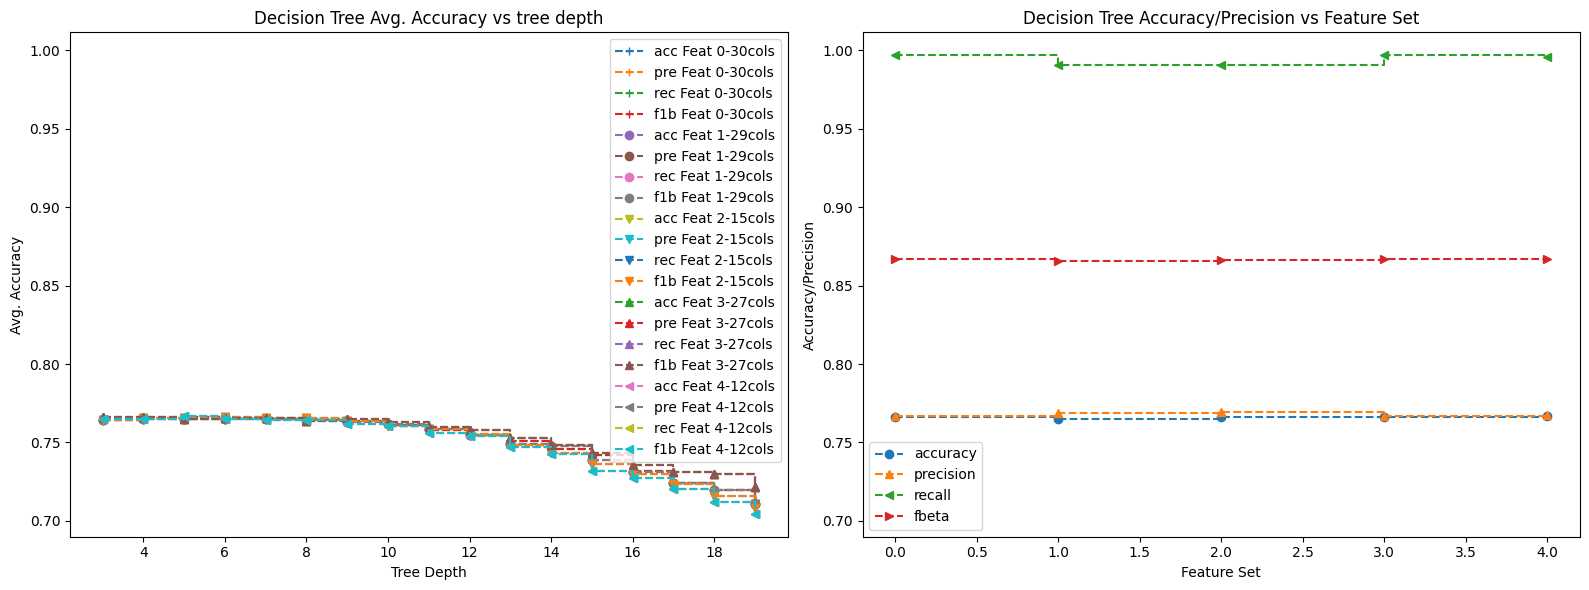

In [89]:

classifier = "Decision Tree"

#fig, ax = plt.subplots()
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

ax[0].set_xlabel("Tree Depth")
ax[0].set_ylabel("Avg. Accuracy")
ax[0].set_title(classifier + " Avg. Accuracy vs tree depth")
for fi in range(0,len(featuresToTrain)):
    ax[0].plot(deptha[fi][:,0], deptha[fi][:,1], linestyle = "--", marker=markers[fi], drawstyle="steps-post", label = "acc " + labelSet[fi])  
    ax[0].plot(depthp[fi][:,0], deptha[fi][:,1], linestyle = "--", marker=markers[fi], drawstyle="steps-post", label = "pre " + labelSet[fi])  
    ax[0].plot(depthr[fi][:,0], deptha[fi][:,1], linestyle = "--", marker=markers[fi], drawstyle="steps-post", label = "rec " + labelSet[fi])  
    ax[0].plot(depthf[fi][:,0], deptha[fi][:,1], linestyle = "--", marker=markers[fi], drawstyle="steps-post", label = "f1b " + labelSet[fi])  
ax[0].legend()
#ax[0].set_ylim(0,1)
ax[1].set_xlabel("Feature Set")
ax[1].set_ylabel("Accuracy/Precision")
ax[1].set_title(classifier + " Accuracy/Precision vs Feature Set")
#ax[1].plot(range(0,len(featuresToTrain)), optimum_accurancy, linestyle = "--", marker=markers[0], drawstyle="steps-post", label = "Cross Val avg acc") 
ax[1].plot(range(0,len(featuresToTrain)), dt_accuracy, linestyle = "--", marker=markers[1], drawstyle="steps-post", label = "accuracy")  
ax[1].plot(range(0,len(featuresToTrain)), dt_precision[:,1], linestyle = "--", marker=markers[3], drawstyle="steps-post", label = "precision")
ax[1].plot(range(0,len(featuresToTrain)), dt_recall[:,1], linestyle = "--", marker=markers[4], drawstyle="steps-post", label = "recall")
ax[1].plot(range(0,len(featuresToTrain)), dt_fbeta[:,1], linestyle = "--", marker=markers[5], drawstyle="steps-post", label = "fbeta")
#ax[1].plot(range(0,len(featuresToTrain)), dt_fbeta[:,0], linestyle = "--", marker=markers[6], drawstyle="steps-post", label = "fbeta(not-fault)")
ax[1].sharey(ax[0])
ax[1].legend()

plt.tight_layout()

plt.show()

## Logistic Regression Classification

In [90]:


#avg_accuracy = np.zeros(len(featuresToTrain))
pipe = []
lr_y_pred = []
lr_confmat = []
lr_accuracy = np.zeros(len(featuresToTrain))
lr_precision = np.zeros((len(featuresToTrain),2))
lr_recall = np.zeros((len(featuresToTrain),2))
lr_fbeta  = np.zeros((len(featuresToTrain),2))
lr_featimportance = []
for fi in range(0,len(featuresToTrain)):
    pipe.append(None)
    lr_y_pred.append(None)
    lr_confmat.append(None)
    lr_featimportance.append(np.zeros(len(featuresToTrain)))
    pipe[fi] = make_pipeline(StandardScaler(), LogisticRegression(multi_class="ovr",max_iter=200, class_weight={0:0.6,1:0.4}))
    #scores = cross_val_score(estimator=pipe[fi], X=X[fi], y=y, cv=10, n_jobs=3)
    scores = cross_validate(estimator=pipe[fi], X=X[fi], y=y, cv=10, n_jobs=3, scoring=["accuracy","precision","recall","f1"])
    #avg_accuracy[fi] = scores.mean()
    pipe[fi] = pipe[fi].fit(X_train[fi], y_train[fi])
    lr_y_pred[fi] = pipe[fi].predict(X_test[fi])
    #lr_confmat[fi]=confusion_matrix(y_test[fi], lr_y_pred[fi])
    #lr_accuracy[fi]=accuracy_score(y_test[fi], lr_y_pred[fi])
    lr_featimportance[fi] = pipe[fi][1].coef_[0]
    #(lr_precision[fi], lr_recall[fi], lr_fbeta[fi], _)=precision_recall_fscore_support(y_test[fi], lr_y_pred[fi],zero_division=0)
    lr_accuracy[fi]=scores['test_accuracy'].mean()
    lr_precision[fi]=scores['test_precision'].mean()
    lr_recall[fi]=scores['test_recall'].mean()
    lr_fbeta[fi]=scores['test_f1'].mean()
    print(fi,"Cross Val Avg accuracy =",lr_accuracy[fi],"precision",lr_precision[fi],"recall",lr_recall[fi],"f-beta",lr_fbeta[fi])
    print( "             ",np.array_str(np.round(lr_featimportance[fi],2),max_line_width=np.inf))
    print( "              faults/total=",np.round(lr_y_pred[fi].sum()/len(lr_y_pred[fi]),3)," test faults/total=",np.round(y_test[fi].sum()/len(y_test[fi]),3))


0 Cross Val Avg accuracy = 0.7506324307762552 precision [0.78688822 0.78688822] recall [0.92351946 0.92351946] f-beta [0.84970543 0.84970543]
              [-0.    0.07 -0.1  -0.11 -0.1   0.41 -0.22  0.25 -0.06  0.07  0.03  0.06 -0.06  0.6   0.05 -0.01  0.02 -0.03 -0.02 -0.02 -0.01  0.01 -0.08 -0.04  0.07 -0.04  0.03 -0.02 -0.07  0.04]
              faults/total= 0.895  test faults/total= 0.766
1 Cross Val Avg accuracy = 0.7509941278051795 precision [0.78705845 0.78705845] recall [0.92382403 0.92382403] f-beta [0.8499297 0.8499297]
              [ 0.07 -0.1  -0.11 -0.1   0.41 -0.22  0.25 -0.06  0.07  0.03  0.06 -0.06  0.6   0.05 -0.01  0.02 -0.03 -0.02 -0.02 -0.01  0.02 -0.08 -0.04  0.07 -0.04  0.03 -0.02 -0.07  0.04]
              faults/total= 0.895  test faults/total= 0.766
2 Cross Val Avg accuracy = 0.7502966069167339 precision [0.78613944 0.78613944] recall [0.92446701 0.92446701] f-beta [0.84966546 0.84966546]
              [-0.    0.02 -0.07 -0.12 -0.1   0.42 -0.23  0.25 -0.06  

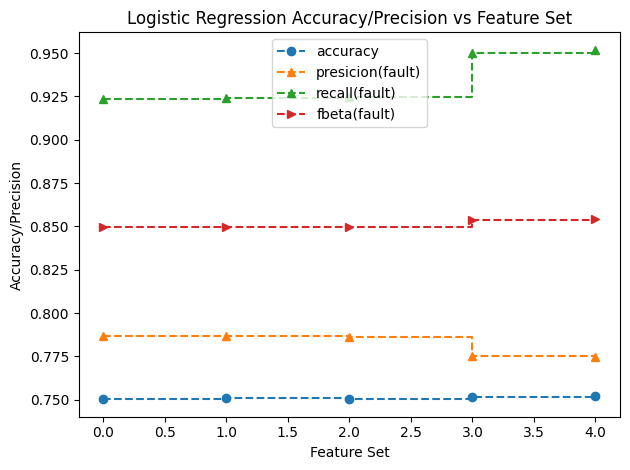

In [91]:

fig, ax = plt.subplots()
ax.set_xlabel("Feature Set")
ax.set_ylabel("Accuracy/Precision")
ax.set_title("Logistic Regression Accuracy/Precision vs Feature Set")
#ax.plot(range(0,len(featuresToTrain)), avg_accuracy, linestyle = "--", marker=markers[0], drawstyle="steps-post", label = "Cross Val avg acc")  
ax.plot(range(0,len(featuresToTrain)), lr_accuracy, linestyle = "--", marker=markers[1], drawstyle="steps-post", label = "accuracy")  
#ax.plot(range(0,len(featuresToTrain)), lr_precision[:,0], linestyle = "--", marker=markers[2], drawstyle="steps-post", label = "Test-set pres(not fault)")  
ax.plot(range(0,len(featuresToTrain)), lr_precision[:,1], linestyle = "--", marker=markers[3], drawstyle="steps-post", label = "presicion(fault)")
#ax.plot(range(0,len(featuresToTrain)), lr_recall[:,0], linestyle = "--", marker=markers[2], drawstyle="steps-post", label = "Test-set recall(not fault)")  
ax.plot(range(0,len(featuresToTrain)), lr_recall[:,1], linestyle = "--", marker=markers[3], drawstyle="steps-post", label = "recall(fault)")
ax.plot(range(0,len(featuresToTrain)), lr_fbeta[:,1], linestyle = "--", marker=markers[5], drawstyle="steps-post", label = "fbeta(fault)")
#ax.plot(range(0,len(featuresToTrain)), lr_fbeta[:,0], linestyle = "--", marker=markers[6], drawstyle="steps-post", label = "fbeta(not-fault)")
ax.legend()

plt.tight_layout()
plt.show()

## Random Forest Classifier

In [92]:
timeout=99999



#depth = []
rf_deptha = []
rf_depthp = []
rf_depthr = []
rf_depthf = []
rf_optimum_depth = []
#rf_optimum_accurancy = []
rf_clf = []
rf_y_pred = []
rf_confmat = []
rf_accuracy = np.zeros(len(featuresToTrain))
rf_precision = np.zeros((len(featuresToTrain),2))
rf_recall = np.zeros((len(featuresToTrain),2))
rf_fbeta  = np.zeros((len(featuresToTrain),2))
rf_featimportance = []
# Find the optimun DT rf_depth for different Feature Sets
for fi in range(0,len(featuresToTrain)):
    rf_deptha.append(None)
    rf_depthp.append(None)
    rf_depthr.append(None)
    rf_depthf.append(None)
    #rf_depth.append(None)
    rf_optimum_depth.append(None)
    #rf_optimum_accurancy.append(None)
    rf_clf.append(None)
    rf_y_pred.append(None)
    rf_confmat.append(None)
    rf_featimportance.append(np.zeros(len(featuresToTrain)))
    #rf_depth[fi] = []
    rf_deptha[fi] = []
    rf_depthp[fi] = []
    rf_depthr[fi] = []
    rf_depthf[fi] = []
    # find optimun tree length
    for i in range(3,20):
        rf_clf[fi] = RandomForestClassifier(criterion="gini",max_depth=i) #, n_estimators=100, max_features="sqrt")
        # Perform 7-fold cross validation 
        #scores = cross_val_score(estimator=rf_clf[fi], X=X[fi], y=y, cv=10, n_jobs=3)
        scores = cross_validate(estimator=rf_clf[fi], X=X[fi], y=y, cv=10, n_jobs=4,scoring=["accuracy","precision","recall","f1"])
        #rf_depth[fi].append((i,scores.mean()))
        rf_deptha[fi].append((i,scores['test_accuracy'].mean()))
        rf_depthp[fi].append((i,scores['test_precision'].mean()))
        rf_depthr[fi].append((i,scores['test_recall'].mean()))
        rf_depthf[fi].append((i,scores['test_f1'].mean()))
    #rf_depth[fi] = np.array(rf_depth[fi])
    rf_deptha[fi] = np.array(deptha[fi])
    rf_depthp[fi] = np.array(depthp[fi])
    rf_depthr[fi] = np.array(depthr[fi])
    rf_depthf[fi] = np.array(depthf[fi])
    #print(rf_depth[fi])
    _ndepth = np.argmax(rf_deptha[fi][:,1],axis=0)
    rf_optimum_depth[fi] = int(rf_deptha[fi][_ndepth,0])
    #rf_optimum_accurancy[fi] = np.amax(rf_depth[fi][:,1])
    # pre-set the DT to the optimum rf_depth for later use
    rf_clf[fi] = RandomForestClassifier(criterion="gini",max_depth=rf_optimum_depth[fi]) #, n_estimators=100, max_features="sqrt")
    rf_clf[fi] = rf_clf[fi].fit(X_train[fi], y_train[fi])
    rf_y_pred[fi] = rf_clf[fi].predict(X_test[fi])
    #rf_confmat[fi]=confusion_matrix(y_test[fi], rf_y_pred[fi])
    rf_accuracy[fi]=rf_deptha[fi][_ndepth,1]
    rf_precision[fi]=rf_depthp[fi][_ndepth,1]
    rf_recall[fi]=rf_depthr[fi][_ndepth,1]
    rf_fbeta[fi]=rf_depthf[fi][_ndepth,1]
    #rf_accuracy[fi]=accuracy_score(y_test[fi], rf_y_pred[fi])
    rf_featimportance[fi] = rf_clf[fi].feature_importances_
    #(rf_precision[fi], rf_recall[fi], _, _)=precision_recall_fscore_support(y_test[fi], rf_y_pred[fi],zero_division=0)
    print(fi,"Opt Depth = ",rf_optimum_depth[fi],"(cross val accuracy =",rf_accuracy[fi],"precision",rf_precision[fi],"recall",rf_recall[fi])
    print( "              ",np.array_str(np.round(rf_featimportance[fi],2),max_line_width=np.inf))
    print( "              faults/total=",np.round(rf_y_pred[fi].sum()/len(rf_y_pred[fi]),3)," test faults/total=",np.round(y_test[fi].sum()/len(y_test[fi]),3))

/Users/lucho/Library/Python/3.9/lib/python/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


0 Opt Depth =  5 (cross val accuracy = 0.7662894363907863 precision [0.76693883 0.76693883] recall [0.99678511 0.99678511]
               [0.02 0.01 0.04 0.01 0.03 0.18 0.04 0.13 0.09 0.1  0.01 0.06 0.04 0.23 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
              faults/total= 0.995  test faults/total= 0.766


/Users/lucho/Library/Python/3.9/lib/python/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


1 Opt Depth =  7 (cross val accuracy = 0.7651268325993923 precision [0.76858213 0.76858213] recall [0.9906599 0.9906599]
               [0.03 0.04 0.02 0.04 0.15 0.04 0.14 0.08 0.09 0.01 0.05 0.04 0.23 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.  ]
              faults/total= 0.994  test faults/total= 0.766
2 Opt Depth =  6 (cross val accuracy = 0.7660567714476625 precision [0.76932284 0.76932284] recall [0.9906599 0.9906599]
               [0.03 0.02 0.03 0.01 0.03 0.16 0.04 0.14 0.1  0.09 0.01 0.05 0.03 0.25 0.  ]
              faults/total= 0.994  test faults/total= 0.766


/Users/lucho/Library/Python/3.9/lib/python/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/lucho/Library/Python/3.9/lib/python/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


3 Opt Depth =  4 (cross val accuracy = 0.76623773677855 precision [0.76685816 0.76685816] recall [0.99688663 0.99688663]
               [0.02 0.01 0.04 0.05 0.17 0.11 0.16 0.   0.08 0.04 0.29 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
              faults/total= 0.995  test faults/total= 0.766


/Users/lucho/Library/Python/3.9/lib/python/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/lucho/Library/Python/3.9/lib/python/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


4 Opt Depth =  5 (cross val accuracy = 0.7667028530576199 precision [0.76764919 0.76764919] recall [0.99583756 0.99583756]
               [0.03 0.02 0.05 0.05 0.18 0.12 0.15 0.01 0.06 0.05 0.28 0.  ]
              faults/total= 0.994  test faults/total= 0.766


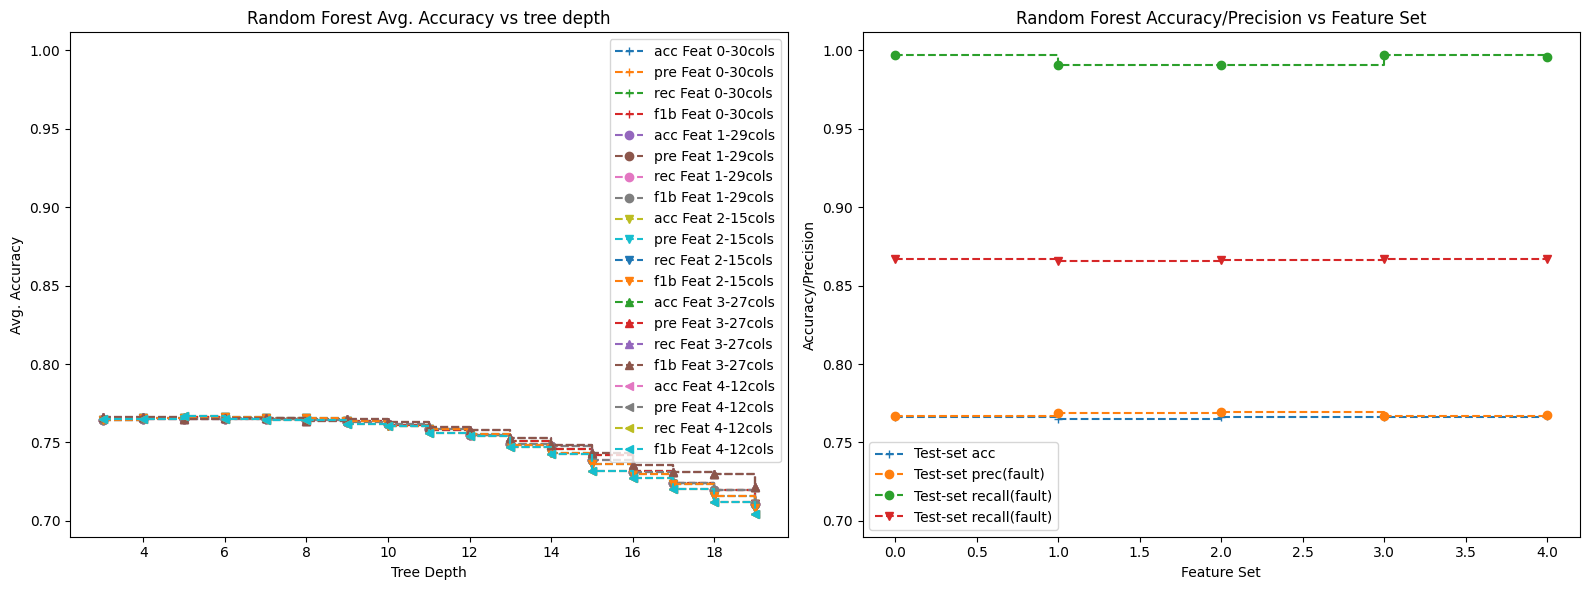

In [96]:

classifier = "Random Forest"

#fig, ax = plt.subplots()
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

ax[0].set_xlabel("Tree Depth")
ax[0].set_ylabel("Avg. Accuracy")
ax[0].set_title(classifier + " Avg. Accuracy vs tree depth")
for fi in range(0,len(featuresToTrain)):
    ax[0].plot(rf_deptha[fi][:,0], deptha[fi][:,1], linestyle = "--", marker=markers[fi], drawstyle="steps-post", label = "acc " + labelSet[fi])  
    ax[0].plot(rf_depthp[fi][:,0], deptha[fi][:,1], linestyle = "--", marker=markers[fi], drawstyle="steps-post", label = "pre " + labelSet[fi])  
    ax[0].plot(rf_depthr[fi][:,0], deptha[fi][:,1], linestyle = "--", marker=markers[fi], drawstyle="steps-post", label = "rec " + labelSet[fi])  
    ax[0].plot(rf_depthf[fi][:,0], deptha[fi][:,1], linestyle = "--", marker=markers[fi], drawstyle="steps-post", label = "f1b " + labelSet[fi])  
ax[0].legend()

ax[1].sharey(ax[0])
ax[1].set_xlabel("Feature Set")
ax[1].set_ylabel("Accuracy/Precision")
ax[1].set_title(classifier + " Accuracy/Precision vs Feature Set")
ax[1].plot(range(0,len(featuresToTrain)), rf_accuracy, linestyle = "--", marker=markers[0], drawstyle="steps-post", label = "Test-set acc")  
#ax[1].plot(range(0,len(featuresToTrain)), rf_precision[:,0], linestyle = "--", marker=markers[2], drawstyle="steps-post", label = "Test-set prec(not fault)")  
ax[1].plot(range(0,len(featuresToTrain)), rf_precision[:,1], linestyle = "--", marker=markers[1], drawstyle="steps-post", label = "Test-set prec(fault)")
#ax[1].plot(range(0,len(featuresToTrain)), rf_recall[:,0], linestyle = "--", marker=markers[2], drawstyle="steps-post", label = "Test-set recall(not fault)")  
ax[1].plot(range(0,len(featuresToTrain)), rf_recall[:,1], linestyle = "--", marker=markers[1], drawstyle="steps-post", label = "Test-set recall(fault)")
ax[1].plot(range(0,len(featuresToTrain)), rf_fbeta[:,1], linestyle = "--", marker=markers[2], drawstyle="steps-post", label = "Test-set recall(fault)")
ax[1].legend()

plt.tight_layout()

# Use NYS Registration to Identify Fatal Accident Rates for Most Popular Vehicles Models

Two cases
1. Use all records in FARS
2. Use "Fault" records in FARS

In [118]:
nydmvNumTopModels = 50

In [97]:
#Add nydmvModelIDCat to farsCategories["ModelId"]
print("FarsCategories before merge:",len(farsCategories["ModelId"]),"NYDM Model Categories:",len(nydmvModelIDCat))
farsCategories["ModelId"].update(nydmvModelIDCat)
print("FarsCategories after merge:",len(farsCategories["ModelId"]))

FarsCategories fore merge: 2172 NYDM Model Categories: 6429
FarsCategories after merge: 6522


In [98]:
# Get overall accident rate per 100,000 vehicles for all vehicle models
nysOverallRate = (farsAccVehMergeLight["STATE"]==36).sum()/len(nydmvVinDecodeDf) * 100000
nysOverallFaultRate= ((farsAccVehMergeLight["STATE"]==36) & farsAccVehMergeLight["Fault"]).sum()/len(nydmvVinDecodeDf) * 100000
print("NYS Overall Fatal accident rate per 100,000 vehicles =",round(nysOverallRate,2))
print("NYS Overall At Fault Fatal accident rate per 100,000 vehicles =",round(nysOverallFaultRate,2))

NYS Overall Fatal accident rate per 100,000 vehicles = 10.49
NYS Overall At Fault Fatal accident rate per 100,000 vehicles = 8.41


In [115]:
farsModelsNYS = pd.DataFrame()
farsModelsNYS["NYS_FARS_ALL"] = farsAccVehMergeLight[farsAccVehMergeLight["STATE"]==36]["ModelId"].value_counts()
farsModelsNYSFault = pd.DataFrame()
farsModelsNYSFault["NYS_FARS_FAULT"] = farsAccVehMergeLight[(farsAccVehMergeLight["STATE"]==36) & farsAccVehMergeLight["Fault"]]["ModelId"].value_counts()
nydmvModels = pd.DataFrame()
#nydmvModels["NYS_REG_ALL"] = nydmvVinDecodeDf["ModelID"].rename(index={"ModelID":"ModelId"}).value_counts()
nydmvModels["NYS_REG_ALL"] = nydmvVinDecodeDf["ModelID"].value_counts()


nysVehRates = pd.merge(left=nydmvModels,right=farsModelsNYS,left_index=True,right_index=True,how="outer").fillna(0)
nysVehRates = pd.merge(left=nysVehRates,right=farsModelsNYSFault,left_index=True,right_index=True,how="outer").fillna(0)
# calculate rate per 100,000 vehicles
nysVehRates["NYS_FARS_ALL_RATE"] = nysVehRates["NYS_FARS_ALL"] / nysVehRates["NYS_REG_ALL"] * 100000
nysVehRates["NYS_FARS_FAULT_RATE"] = nysVehRates["NYS_FARS_FAULT"] / nysVehRates["NYS_REG_ALL"] * 100000
nysVehRates.info(show_counts=True)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1979 entries, 1684 to 30718
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   NYS_REG_ALL          1979 non-null   float64
 1   NYS_FARS_ALL         1979 non-null   float64
 2   NYS_FARS_FAULT       1979 non-null   float64
 3   NYS_FARS_ALL_RATE    1979 non-null   float64
 4   NYS_FARS_FAULT_RATE  1979 non-null   float64
dtypes: float64(5)
memory usage: 92.8 KB


In [119]:
# Select most popular vehicle models
nysVehRates.sort_values(by="NYS_REG_ALL",ascending=False).head(nydmvNumTopModels).rename(index=farsCategories["ModelId"])

NYS_REG_ALL  NYS_FARS_ALL  NYS_FARS_FAULT  NYS_FARS_ALL_RATE  \
CR-V               317149.0          28.0            17.0           8.828658   
Silverado          267285.0          20.0            17.0           7.482650   
RAV4               254554.0          18.0            17.0           7.071191   
Accord             252798.0          38.0            32.0          15.031764   
Camry              242440.0          29.0            23.0          11.961722   
Civic              225324.0          28.0            22.0          12.426550   
Grand Cherokee     213600.0          23.0            22.0          10.767790   
Rogue              187063.0          19.0            17.0          10.157006   
F-150              181942.0          15.0            14.0           8.244386   
Forester           164563.0           5.0             5.0           3.038350   
Equinox            161863.0          10.0             6.0           6.178064   
Corolla            160036.0          15.0            11.0           9.372891   
Highlander         140006.0           6.0             5.0           4.285531   
1500               138902.0           9.0             8.0           6.479388   
Escape             138593.0          18.0            16.0          12.987669   
Pilot              132229.0           9.0             8.0           6.806374   
Altima             129101.0          16.0            14.0          12.393397   
Wrangler           117863.0          10.0            10.0           8.484427   
Sienna             116737.0          14.0             9.0          11.992770   
Explorer           113255.0           5.0             2.0           4.414816   
Outback            109933.0           3.0             3.0           2.728935   
Odyssey            102898.0           7.0             6.0           6.802853   
Elantra            100912.0          21.0            16.0          20.810211   
Cherokee            91938.0           8.0             7.0           8.701516   
Sierra              91731.0           6.0             5.0           6.540864   
Sonata              88081.0          10.0             8.0          11.353186   
Sentra              84244.0           5.0             4.0           5.935141   
RX                  81110.0           3.0             2.0           3.698681   
CX-5                77889.0           3.0             3.0           3.851635   
Tacoma              75553.0           3.0             2.0           3.970723   
Impreza             73406.0           7.0             7.0           9.536005   
Compass             73361.0           3.0             0.0           4.089366   
Tucson              73269.0           4.0             3.0           5.459335   
Malibu              71843.0          13.0            11.0          18.095013   
F-250               69644.0           7.0             7.0          10.051117   
Fusion              68381.0          10.0             9.0          14.623945   
Ram                 68145.0           9.0             8.0          13.207132   
Traverse            64233.0           2.0             2.0           3.113664   
Crosstrek           62843.0           1.0             0.0           1.591267   
Santa Fe            62483.0           4.0             4.0           6.401741   
Jetta               62088.0           2.0             2.0           3.221234   
Grand Caravan       61493.0           4.0             3.0           6.504805   
MDX                 61355.0           7.0             7.0          11.409013   
HR-V                61165.0           5.0             4.0           8.174610   
Impala              56296.0           7.0             5.0          12.434276   
Legacy              55793.0           7.0             5.0          12.546377   
Cruze               55077.0           6.0             6.0          10.893840   
Edge                54464.0           7.0             6.0          12.852526   
Pathfinder          52779.0           9.0             8.0          17.052237   
Focus           

In [120]:
# select most popular vehicle models
nysVehRates = nysVehRates.sort_values(by="NYS_REG_ALL",ascending=False).head(nydmvNumTopModels)


<AxesSubplot: title={'center': 'NYS Fatal Accidents in year 2020 - Top-50 Vehicle Models with highest Fatal accidents per 100,000 registered vehicles'}>

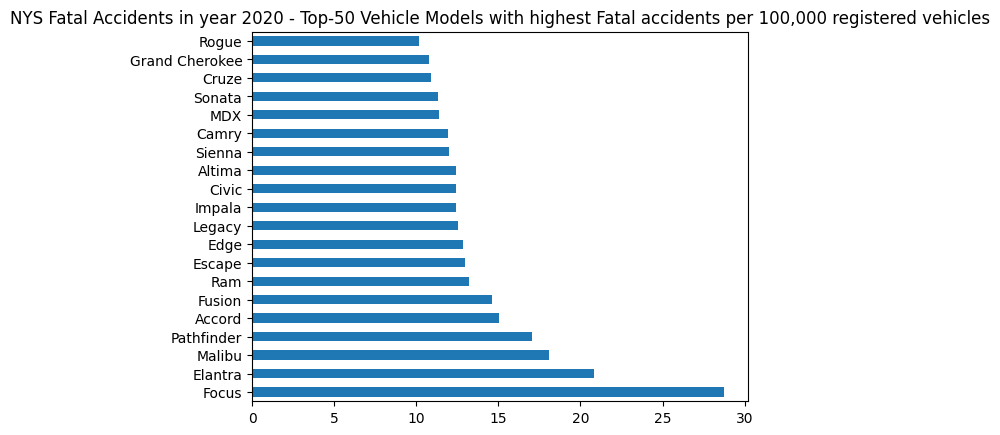

In [122]:
_serToPlot = nysVehRates["NYS_FARS_ALL_RATE"].sort_values(ascending=False).rename(farsCategories["ModelId"])
_serToPlot = _serToPlot.head(min(20,len(_serToPlot)))
#_serToPlot["Other"] = _theTotal - _serToPlot.sum()
_serToPlot.plot.barh(title = "NYS Fatal Accidents in year 2020 - Top-" + str(nydmvNumTopModels) + " Vehicle Models with highest Fatal accidents per 100,000 registered vehicles")

<AxesSubplot: title={'center': 'NYS Fatal Accidents in year 2020 - Top-50 Vehicle Models with lowest Fatal accidents per 100,000 registered vehicles'}>

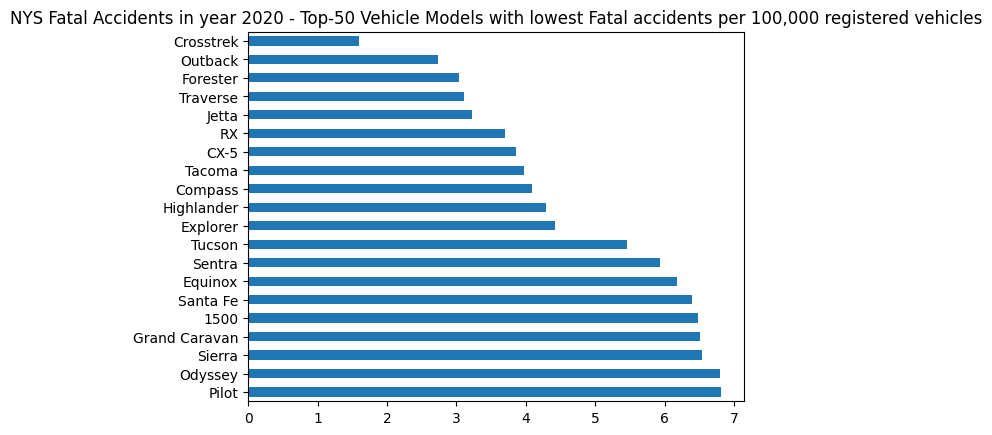

In [123]:
_serToPlot = nysVehRates["NYS_FARS_ALL_RATE"].sort_values(ascending=False).rename(farsCategories["ModelId"])
_serToPlot = _serToPlot.tail(min(20,len(_serToPlot)))
#_serToPlot["Other"] = _theTotal - _serToPlot.sum()
_serToPlot.plot.barh(title = "NYS Fatal Accidents in year 2020 - Top-" + str(nydmvNumTopModels) + " Vehicle Models with lowest Fatal accidents per 100,000 registered vehicles")

<AxesSubplot: title={'center': 'NYS Fatal Accidents in year 2020 - Top-50 Vehicle Models with highest Fatal At Fault accidents per 100,000 registered vehicles'}>

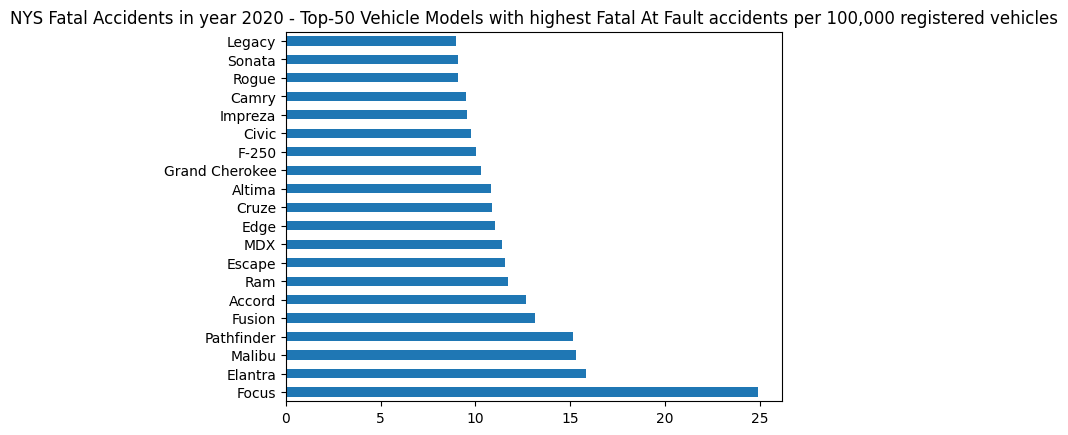

In [124]:
_serToPlot = nysVehRates["NYS_FARS_FAULT_RATE"].sort_values(ascending=False).rename(farsCategories["ModelId"])
_serToPlot = _serToPlot.head(min(20,len(_serToPlot)))
#_serToPlot["Other"] = _theTotal - _serToPlot.sum()
_serToPlot.plot.barh(title = "NYS Fatal Accidents in year 2020 - Top-" + str(nydmvNumTopModels) + " Vehicle Models with highest Fatal At Fault accidents per 100,000 registered vehicles")

<AxesSubplot: title={'center': 'NYS Fatal Accidents in year 2020 - Top-50 Vehicle Models with lowest At Fault Fatal accidents per 100,000 registered vehicles'}>

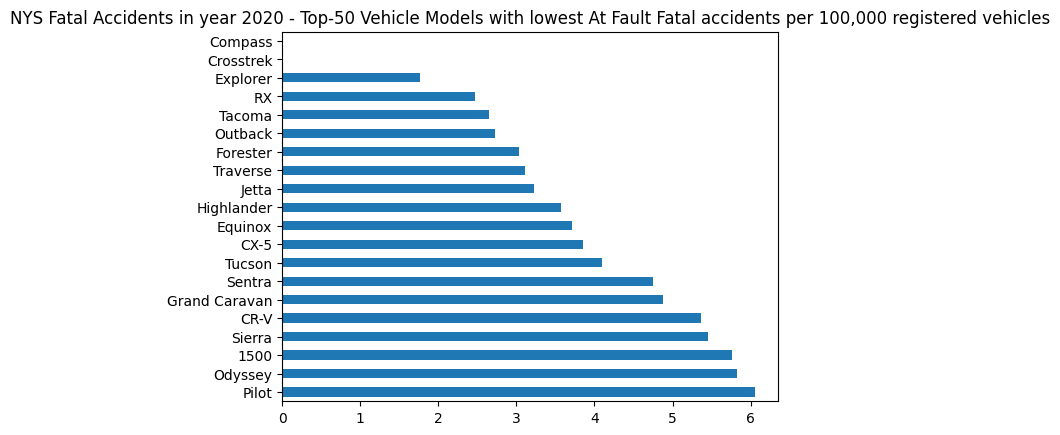

In [125]:
_serToPlot = nysVehRates["NYS_FARS_FAULT_RATE"].sort_values(ascending=False).rename(farsCategories["ModelId"])
_serToPlot = _serToPlot.tail(min(20,len(_serToPlot)))
#_serToPlot["Other"] = _theTotal - _serToPlot.sum()
_serToPlot.plot.barh(title = "NYS Fatal Accidents in year 2020 - Top-" + str(nydmvNumTopModels) + " Vehicle Models with lowest At Fault Fatal accidents per 100,000 registered vehicles")

## User NYS Registration to Identify Fatal Accident Rates for Different Vehicle Manufacture Years

Two cases
1. Use all records in FARS
2. Use "Fault" records in FARS

In [108]:
farsYearsNYS = pd.DataFrame()
farsYearsNYS["NYS_FARS_ALL"] = farsAccVehMergeLight[farsAccVehMergeLight["STATE"]==36]["ModelYear"].value_counts().sort_index()
farsYearsNYSFault = pd.DataFrame()
farsYearsNYSFault["NYS_FARS_FAULT"] = farsAccVehMergeLight[(farsAccVehMergeLight["STATE"]==36) & farsAccVehMergeLight["Fault"]]["ModelYear"].value_counts().sort_index()
nydmvYears = pd.DataFrame()
nydmvYears["NYS_REG_ALL"] = nydmvVinDecodeDf["ModelYear"].dropna().astype("int64").value_counts().sort_index()


nysVehYrRates = pd.merge(left=nydmvYears,right=farsYearsNYS,left_index=True,right_index=True,how="outer",sort=False).fillna(0)
nysVehYrRates = pd.merge(left=nysVehYrRates,right=farsYearsNYSFault,left_index=True,right_index=True,how="outer",sort=False).fillna(0)
#nysVehYrRates.index = nysVehYrRates.index.astype("int64")
# calculate rate per 100,000 vehicles
nysVehYrRates["NYS_FARS_ALL_RATE"] = nysVehYrRates["NYS_FARS_ALL"] / nysVehYrRates["NYS_REG_ALL"] * 100000
nysVehYrRates["NYS_FARS_FAULT_RATE"] = nysVehYrRates["NYS_FARS_FAULT"] / nysVehYrRates["NYS_REG_ALL"] * 100000
nysVehYrRates.info(show_counts=True)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 43 entries, 1981 to 2023
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   NYS_REG_ALL          43 non-null     int64  
 1   NYS_FARS_ALL         43 non-null     float64
 2   NYS_FARS_FAULT       43 non-null     float64
 3   NYS_FARS_ALL_RATE    43 non-null     float64
 4   NYS_FARS_FAULT_RATE  43 non-null     float64
dtypes: float64(4), int64(1)
memory usage: 2.0 KB


In [109]:
nysVehYrRates

NYS_REG_ALL  NYS_FARS_ALL  NYS_FARS_FAULT  NYS_FARS_ALL_RATE  \
1981         3370           0.0             0.0           0.000000   
1982         3142           0.0             0.0           0.000000   
1983         3560           0.0             0.0           0.000000   
1984         5958           0.0             0.0           0.000000   
1985         7591           0.0             0.0           0.000000   
1986         9118           1.0             0.0          10.967317   
1987        11279           0.0             0.0           0.000000   
1988        10051           0.0             0.0           0.000000   
1989        11176           2.0             1.0          17.895490   
1990        10937           0.0             0.0           0.000000   
1991        11389           1.0             1.0           8.780402   
1992        11246           1.0             1.0           8.892051   
1993        13885           0.0             0.0           0.000000   
1994        18574           3.0             2.0          16.151610   
1995        26328           3.0             2.0          11.394713   
1996        24282           5.0             4.0          20.591385   
1997        36415           5.0             2.0          13.730606   
1998        42291           7.0             6.0          16.551985   
1999        59397          10.0            10.0          16.835867   
2000        79508          21.0            18.0          26.412436   
2001        93425          19.0            17.0          20.337169   
2002       125457          27.0            21.0          21.521318   
2003       165951          40.0            28.0          24.103500   
2004       208606          32.0            26.0          15.339923   
2005       238468          53.0            43.0          22.225204   
2006       265628          52.0            45.0          19.576249   
2007       307829          43.0            41.0          13.968794   
2008       343162          55.0            44.0          16.027416   
2009       285697          44.0            37.0          15.400932   
2010       344651          42.0            33.0          12.186241   
2011       393485          50.0            42.0          12.706965   
2012       441197          60.0            54.0          13.599367   
2013       482742          50.0            34.0          10.357499   
2014       516683          52.0            41.0          10.064198   
2015       604048          68.0            54.0          11.257384   
2016       618171          71.0            55.0          11.485495   
2017       681635          65.0            46.0           9.535895   
2018       735607          69.0            58.0           9.380009   
2019       870966          84.0            65.0           9.644464   
2020       804021          62.0            49.0           7.711241   
2021       862076           2.0             1.0           0.231998   
2022       654212           0.0             0.0           0.000000   
2023        33234           0.0             0.0           0.000000   

      NYS_FARS_FAULT_RATE  
1981             0.000000  
1982             0.000000  
1983             0.000000  
1984             0.000000  
1985             0.000000  
1986             0.000000  
1987             0.000000  
1988             0.000000  
1989             8.947745  
1990             0.000000  
1991             8.780402  
1992             8.892051  
1993             0.000000  
1994            10.767740  
1995             7.596475  
1996            16.473108  
1997             5.492242  
1998            14.187416  
1999            16.835867  
2000            22.639231  
2001            18.196414  
2002            16.738803  
2003            16.872450  
2004            12.463688  
2005            18.031769  
2006            16.940985  
2007            13.319083  
2008            12.821932  
2009            12.950784  
2010             9.574903  
2011            10.673850  
2012            12.239430  
2

Text(0.5, 1.0, 'New York State Fata Accident Rate per 100,000 registered vehichles')

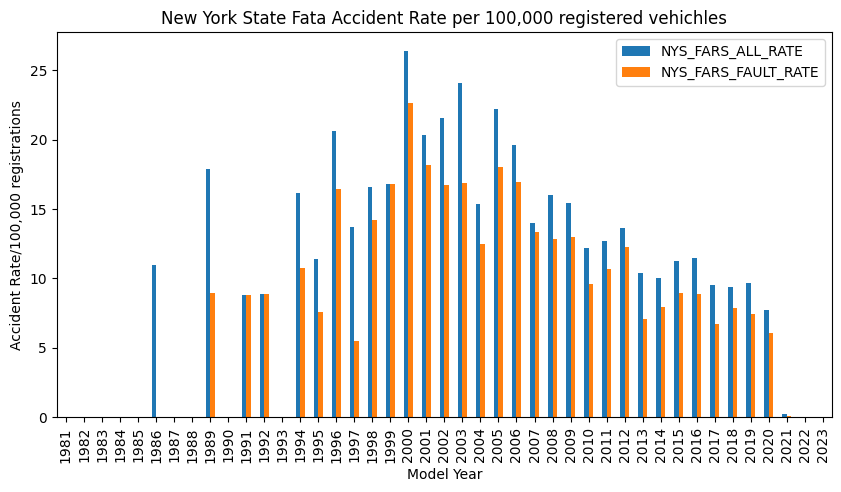

In [110]:
fig, ax = plt.subplots(figsize=(10,5))
nysVehYrRates[["NYS_FARS_ALL_RATE","NYS_FARS_FAULT_RATE"]].plot.bar(stacked=False,ax=ax)
ax.set_xlabel("Model Year")
ax.set_ylabel("Accident Rate/100,000 registrations")
ax.set_title("New York State Fata Accident Rate per 100,000 registered vehichles")

# Accident Risk Reduction based on Induced exposure metrics

Measure|Formula
-- | --
Risk |               $R = \frac{S_f}{S_n}/\frac{N_f}{N_n}$
Effectiveness (%) |  $E = (1 - R)$
Std Error in log odds ration | $\sigma_{ln(R)} = \sqrt{\frac{1}{S_f} + \frac{1}{S_n} + \frac{1}{N_f} + \frac{1}{N_n}}$
Effectiveness lower limit (95% cofidence) |  $E_{lower} = 1 - e^{(ln(R) + \sigma_{ln(R)})}$
Effectiveness upper limit (95% cofidence) | $E_{upper} = 1 - e^{(ln(R) - \sigma_{ln(R)})}$

* $S_f = $ Fault accidents with Safety Feature present
* $S_n = $ Not-fault accidents with Safety Feature present
* $N_f = $ Fault accidents without Feature present
* $N_n = $ Not-fault accidents without Safety Feature present


Based on 
* [3] LEONARD EVANS (1999) Antilock Brake Systems and Risk of Different Types of Crashes in Traffic, Traffic Injury Prevention, 1:1, 5-23, DOI: 10.1080/10286589908915737
* [4] Simon Sternlund, Johan Strandroth, Matteo Rizzi, Anders Lie & Claes Tingvall (2017) The effectiveness of lane departure warning systems—A reduction in real-world passenger car injury crashes, Traffic Injury Prevention, 18:2, 225-229, DOI: 10.1080/15389588.2016.1230672



In [111]:
safetFeatureListToCheck = ["AnySafetyFeature"] + safetFeatureList
roadConditionsToCheck = ["RUR_URB","FUNC_SYS", "VNUM_LAN","VSPD_LIM_GRP", "LGT_COND","WEATHER","VSURCOND"]
driverConditionsToCheck = ["DR_DRINK","SEX", "AGE_GRP"]

#farsAccVehMergeLight.info(show_counts=True)

In [112]:
import matplotlib.transforms as mtransforms

def CalculateEffectiveness(farsAccVehMergeSub, title = "", plotIt = True, minSamples = 100, minHits = 10, styFeatures = safetFeatureListToCheck):
    """
    Calculate Safety Feature effectivenes from Accident Dataframe
    minSample is used to only do the calculation with enough rows in the dataset
    minHits is used to skip calculation for specific fetures with a very low count for SN or SF whic resutls in large delta Error 
    """
    farsRiskGrpAgg = farsAccVehMergeSub[styFeatures+["Fault"]].groupby(["Fault"]).agg(["count","sum"]).rename(index={True:"Fault",False:"NotFault"})

    # S(f,n) = [*]["sum"]
    # N(f,n) = [*]["count"] - [*]["sum"]

    tot = farsRiskGrpAgg.swaplevel(axis=1)["count"].transpose()
    S = farsRiskGrpAgg.swaplevel(axis=1)["sum"].transpose()
    N = (tot - farsRiskGrpAgg.swaplevel(axis=1)["sum"].transpose())

    badfeaturesIdx = ((tot[(tot["Fault"] < minSamples) | (tot["NotFault"] < minSamples)])).index
    S = S.drop(index = badfeaturesIdx)
    N = N.drop(index = badfeaturesIdx)
    badfeaturesIdx = ((N[(S["Fault"] < minHits) | (S["NotFault"] < minHits) | (N["NotFault"] < minHits) | (N["Fault"] < minHits)])).index
    S = S.drop(index = badfeaturesIdx)
    N = N.drop(index = badfeaturesIdx)

    R = (S["Fault"]/S["NotFault"])/(N["Fault"]/N["NotFault"])
    E = (1 - R)*100
    # error
    sigmalnR = np.sqrt(1/S["Fault"] + 1/S["NotFault"] + 1/N["Fault"] + 1/N["NotFault"])
    DElow = (1-np.exp(np.log(R) - sigmalnR))*100 - E
    DEhigh = E - (1-np.exp(np.log(R) + sigmalnR))*100
    deltaE = pd.DataFrame([DElow,DEhigh])

    if plotIt and len(E) > 0:
        #fig, ax = plt.subplots(figsize=(8,8))
        fig, ax = plt.subplots()
        bars = ax.barh(E.index, E.values, xerr = deltaE.values, align='center', alpha=0.5, ecolor='black', capsize=5)
        ax.set_xlabel("Effectiveness (%)")
        ax.set_ylabel("Safety Feature")
        ax.set_title(title)
        trans_offset = mtransforms.offset_copy(ax.transData, fig=fig,x=0.05, y=+0.07, units='inches')
        ax.tick_params(labelsize="small")
        for i in range(len(E)):
            plt.text(x= E[i],y= i,s= np.round(E[i],1), c='b', transform=trans_offset)
        ax.xaxis.grid(True)
        plt.tight_layout()
        plt.show()
    
    return pd.DataFrame({"E" : E, "DElow": DElow, "DEhigh": DEhigh,  "R" : R, "SF" : S["Fault"], "SN" : S["NotFault"], "NF" : N["Fault"], "NN" : N["NotFault"]})




## Check safety feature effectiveness for Vehicles involved in fatal accidents

1. Any vehicle, any accident condition
2. Any vehicle, each accident condition
3. Any vehicle, each driver condition
4. Top vehicles, any accident condition

Overall Safety Feature Effectiveness --------------------


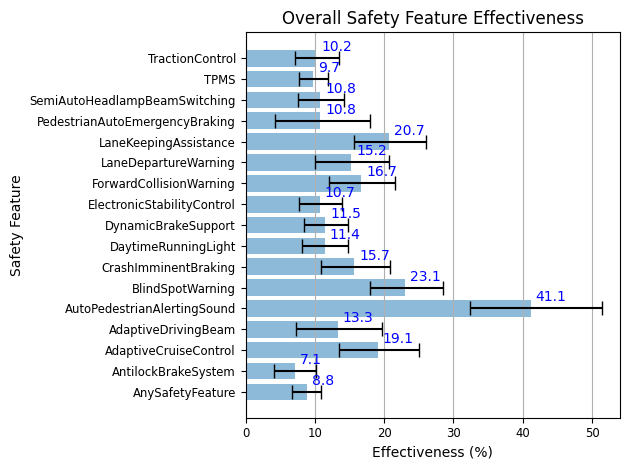

                                       E    DElow    DEhigh         R     SF    SN     NF     NN
------------------------------  --------  -------  --------  --------  -----  ----  -----  -----
AnySafetyFeature                 8.82433  2.06372   2.11151  0.911757  14439  4759  17680   5313
AntilockBrakeSystem              7.08904  2.9435    3.0398   0.92911    4522  1510  27597   8562
AdaptiveCruiseControl           19.0551   5.57873   5.99168  0.809449    724   279  31395   9793
AdaptiveDrivingBeam             13.2693   5.99751   6.44306  0.867307    755   272  31364   9800
AutoPedestrianAlertingSound     41.1459   8.7782   10.317    0.588541    111    59  32008  10013
BlindSpotWarning                23.06     5.04941   5.40407  0.7694      776   314  31343   9758
CrashImminentBraking            15.7053   4.78305   5.07078  0.842947   1131   418  30988   9654
DaytimeRunningLight             11.4349   3.27118   3.39664  0.885651   3036  1062  29083   9010
DynamicBrakeSupport           

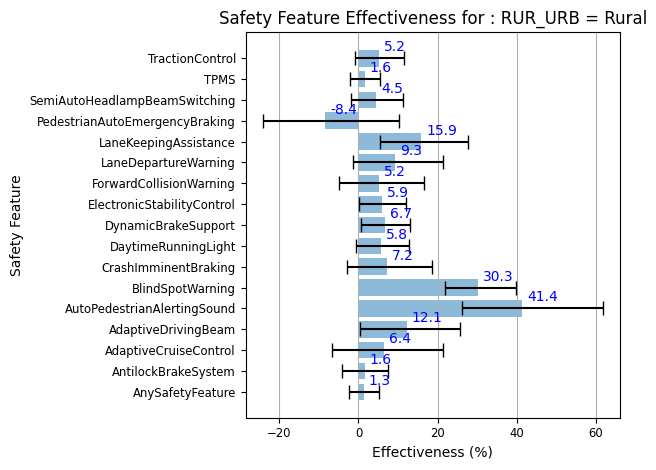

                                       E     DElow    DEhigh         R    SF    SN     NF    NN
------------------------------  --------  --------  --------  --------  ----  ----  -----  ----
AnySafetyFeature                 1.33788   3.76731   3.91687  0.986621  5288  1318   8922  2194
AntilockBrakeSystem              1.56038   5.59997   5.93775  0.984396  1648   413  12562  3099
AdaptiveCruiseControl            6.35183  12.9494   15.0273   0.936482   220    58  13990  3454
AdaptiveDrivingBeam             12.1478   11.6856   13.4784   0.878522   228    64  13982  3448
AutoPedestrianAlertingSound     41.4126   15.1247   20.388    0.585874    38    16  14172  3496
BlindSpotWarning                30.2696    8.48868   9.6653   0.697304   233    82  13977  3430
CrashImminentBraking             7.24541  10.1929   11.4513   0.927546   361    96  13849  3416
DaytimeRunningLight              5.77859   6.40393   6.87093  0.942214  1057   276  13153  3236
DynamicBrakeSupport              6.68218

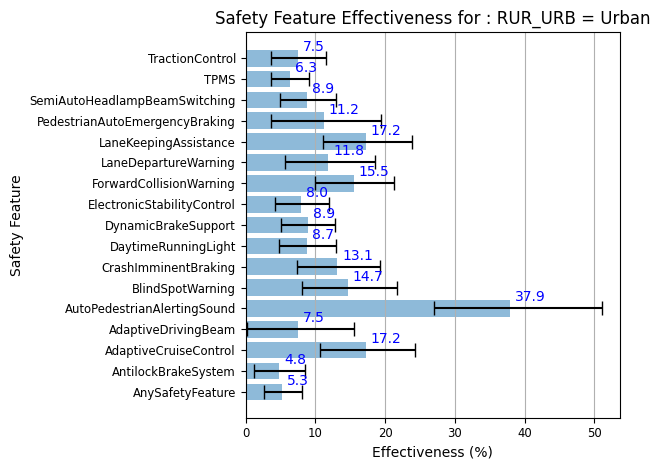

                                       E     DElow    DEhigh         R    SF    SN     NF    NN
------------------------------  --------  --------  --------  --------  ----  ----  -----  ----
AnySafetyFeature                 5.26242   2.69915   2.77831  0.947376  9138  3438   8745  3117
AntilockBrakeSystem              4.78246   3.62981   3.77367  0.952175  2870  1096  15013  5459
AdaptiveCruiseControl           17.222     6.52082   7.07842  0.82778    502   221  17381  6334
AdaptiveDrivingBeam              7.52672   7.38331   8.02397  0.924733   526   208  17357  6347
AutoPedestrianAlertingSound     37.9267   10.8837   13.1978   0.620733    73    43  17810  6512
BlindSpotWarning                14.6535    6.54587   7.08963  0.853465   543   232  17340  6323
CrashImminentBraking            13.1389    5.71173   6.11375  0.868611   768   322  17115  6233
DaytimeRunningLight              8.74479   4.0071    4.19114  0.912552  1975   785  15908  5770
DynamicBrakeSupport              8.87424

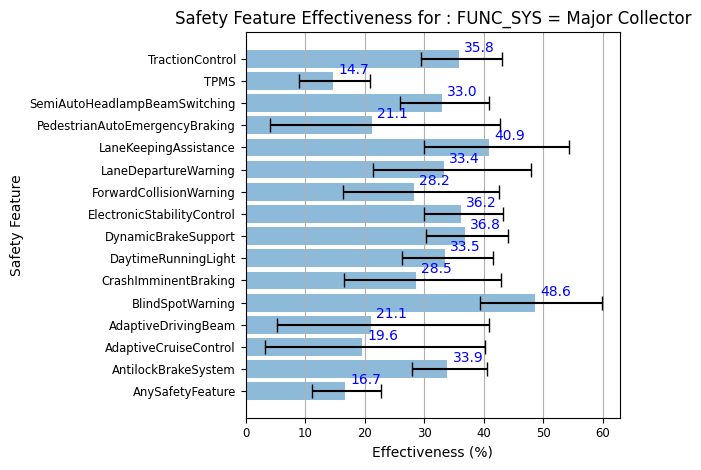

                                      E     DElow    DEhigh         R    SF    SN    NF    NN
------------------------------  -------  --------  --------  --------  ----  ----  ----  ----
AnySafetyFeature                16.6918   5.56744   5.96616  0.833082  1939   458  2917   574
AntilockBrakeSystem             33.9029   6.00154   6.60089  0.660971   560   170  4296   862
AdaptiveCruiseControl           19.6261  16.3505   20.5261   0.803739    95    25  4761  1007
AdaptiveDrivingBeam             21.1357  15.7986   19.7562   0.788643    97    26  4759  1006
BlindSpotWarning                48.643    9.22813  11.2495   0.51357     91    37  4765   995
CrashImminentBraking            28.5424  11.9636   14.3694   0.714576   136    40  4720   992
DaytimeRunningLight             33.4895   7.21856   8.0974   0.665105   357   110  4499   922
DynamicBrakeSupport             36.8208   6.44345   7.17523  0.631792   402   129  4454   903
ElectronicStabilityControl      36.1991   6.28445   6.97111 

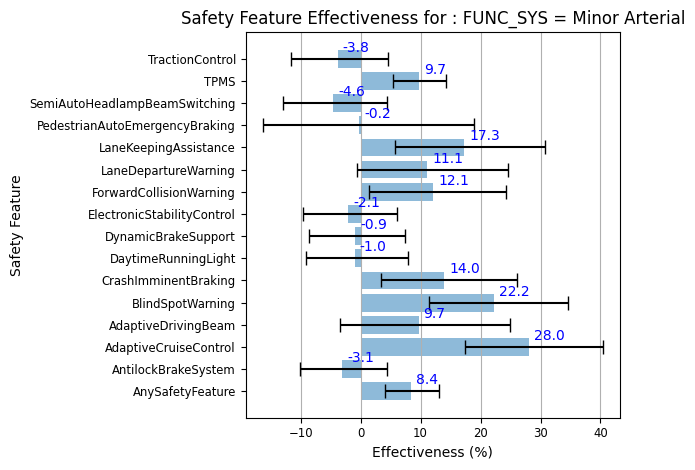

                                        E     DElow    DEhigh         R    SF    SN    NF    NN
------------------------------  ---------  --------  --------  --------  ----  ----  ----  ----
AnySafetyFeature                 8.4132     4.37727   4.59697  0.915868  3393  1042  3982  1120
AntilockBrakeSystem             -3.09431    7.01536   7.52759  1.03094   1054   301  6321  1861
AdaptiveCruiseControl           28.019     10.5754   12.3967   0.71981    141    57  7234  2105
AdaptiveDrivingBeam              9.66349   13.0272   15.2224   0.903365   173    56  7202  2106
BlindSpotWarning                22.1878    10.7463   12.4682   0.778122   171    64  7204  2098
CrashImminentBraking            13.9669    10.6198   12.1153   0.860331   236    80  7139  2082
DaytimeRunningLight             -0.97143    8.09694   8.80284  1.00971    702   204  6673  1958
DynamicBrakeSupport             -0.935601   7.66274   8.29226  1.00936    798   232  6577  1930
ElectronicStabilityControl      -2.08237

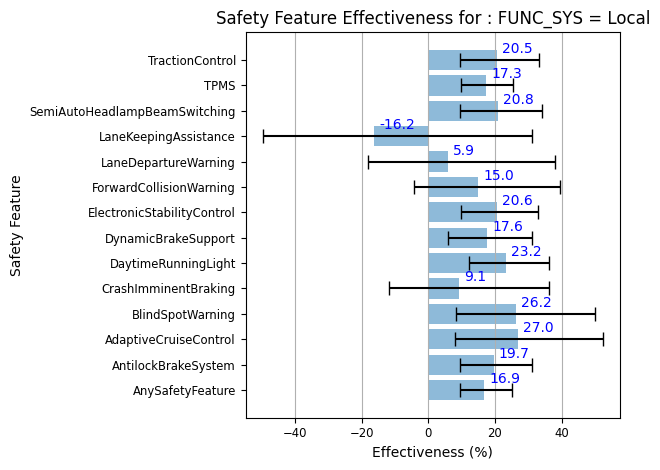

                                       E     DElow    DEhigh         R    SF    SN    NF    NN
-----------------------------  ---------  --------  --------  --------  ----  ----  ----  ----
AnySafetyFeature                16.8579    7.49031   8.23193  0.831421  1356   242  1914   284
AntilockBrakeSystem             19.654    10.1106   11.566    0.80346    396    77  2874   449
AdaptiveCruiseControl           26.994    18.8602   25.4297   0.73006     64    14  3206   512
BlindSpotWarning                26.1968   18.0127   23.8283   0.738032    74    16  3196   510
CrashImminentBraking             9.133    20.8097   26.991    0.90867    102    18  3168   508
DaytimeRunningLight             23.2383   11.0917   12.965    0.767617   269    55  3001   471
DynamicBrakeSupport             17.597    11.5992   13.4993   0.82403    303    58  2967   468
ElectronicStabilityControl      20.6085   10.7611   12.4484   0.793915   324    64  2946   462
ForwardCollisionWarning         14.9541   19.116  

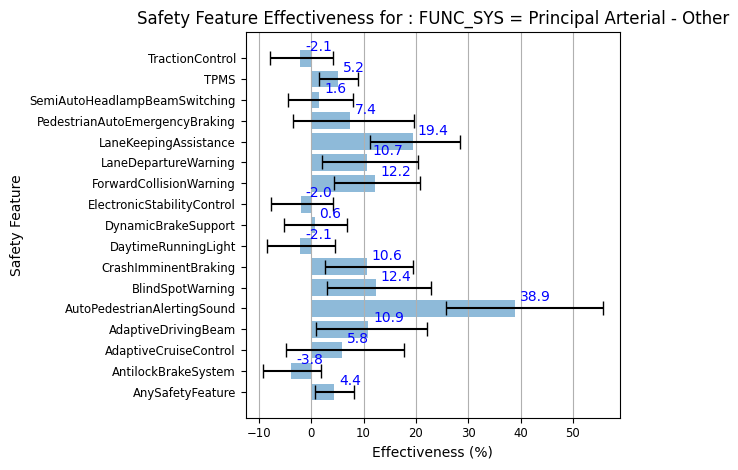

                                        E     DElow    DEhigh         R    SF    SN     NF    NN
------------------------------  ---------  --------  --------  --------  ----  ----  -----  ----
AnySafetyFeature                 4.35962    3.63302   3.77647  0.956404  4907  1805   5179  1822
AntilockBrakeSystem             -3.83002    5.44207   5.74309  1.0383    1576   549   8510  3078
AdaptiveCruiseControl            5.79996   10.5329   11.859    0.942      265   101   9821  3526
AdaptiveDrivingBeam             10.9036    10.0322   11.3051   0.890964   251   101   9835  3526
AutoPedestrianAlertingSound     38.911     13.1889   16.8204   0.61089     46    27  10040  3600
BlindSpotWarning                12.3604     9.4317   10.5691   0.876396   274   112   9812  3515
CrashImminentBraking            10.6377     8.08107   8.8845   0.893623   407   163   9679  3464
DaytimeRunningLight             -2.14638    6.28702   6.69936  1.02146   1060   374   9026  3253
DynamicBrakeSupport           

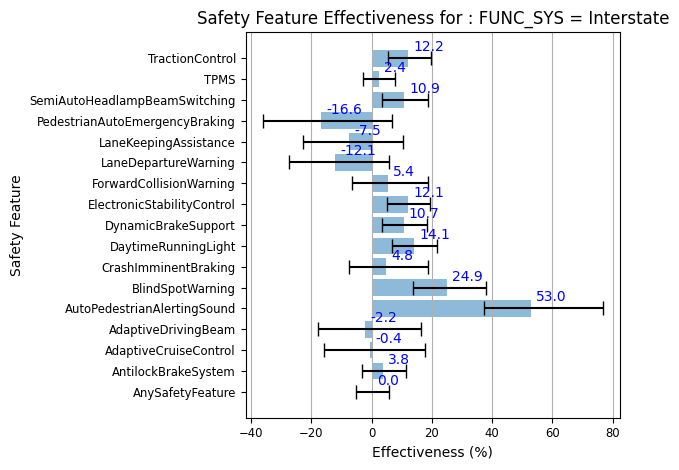

                                          E     DElow    DEhigh         R    SF    SN    NF    NN
------------------------------  -----------  --------  --------  --------  ----  ----  ----  ----
AnySafetyFeature                  0.0297628   5.34265   5.64429  0.999702  1824   860  2391  1127
AntilockBrakeSystem               3.76366     7.06374   7.62329  0.962363   618   301  3597  1686
AdaptiveCruiseControl            -0.404246   15.4642   18.2796   1.00404    115    54  4100  1933
AdaptiveDrivingBeam              -2.20026    15.7023   18.5529   1.022      117    54  4098  1933
AutoPedestrianAlertingSound      53.0098     15.7789   23.756    0.469902    12    12  4203  1975
BlindSpotWarning                 24.915      11.0515   12.9589   0.75085    106    66  4109  1921
CrashImminentBraking              4.78839    12.1263   13.8962   0.952116   170    84  4045  1903
DaytimeRunningLight              14.0607      7.11569   7.75805  0.859393   430   232  3785  1755
DynamicBrakeSupport 

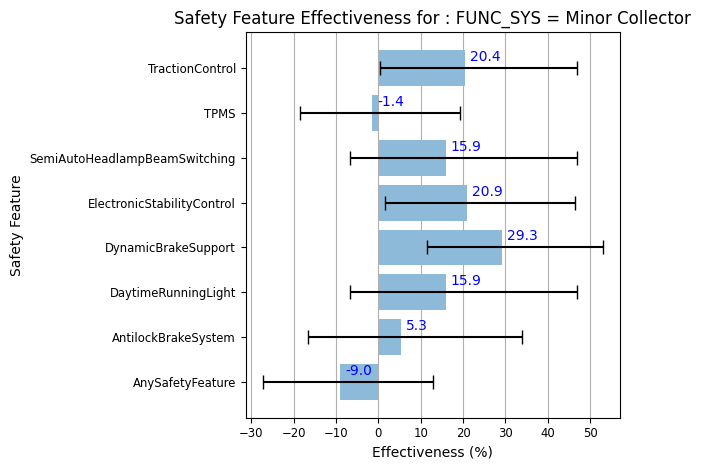

                                      E    DElow    DEhigh         R    SF    SN    NF    NN
-----------------------------  --------  -------  --------  --------  ----  ----  ----  ----
AnySafetyFeature               -9.01213  18.3213   22.0226  1.09012    367    52   628    97
AntilockBrakeSystem             5.2752   21.9837   28.6276  0.947248   121    19   874   130
DaytimeRunningLight            15.9442   22.6787   31.0585  0.840558    74    13   921   136
DynamicBrakeSupport            29.2939   17.7838   23.7597  0.707061    78    16   917   133
ElectronicStabilityControl     20.8911   19.3171   25.558   0.791089    92    17   903   132
SemiAutoHeadlampBeamSwitching  15.9442   22.6787   31.0585  0.840558    74    13   921   136
TPMS                           -1.40729  17.2097   20.7273  1.01407    337    50   658    99
TractionControl                20.3538   19.8963   26.5217  0.796462    87    16   908   133


FUNC_SYS 2 SIZE:  1911 --------------------


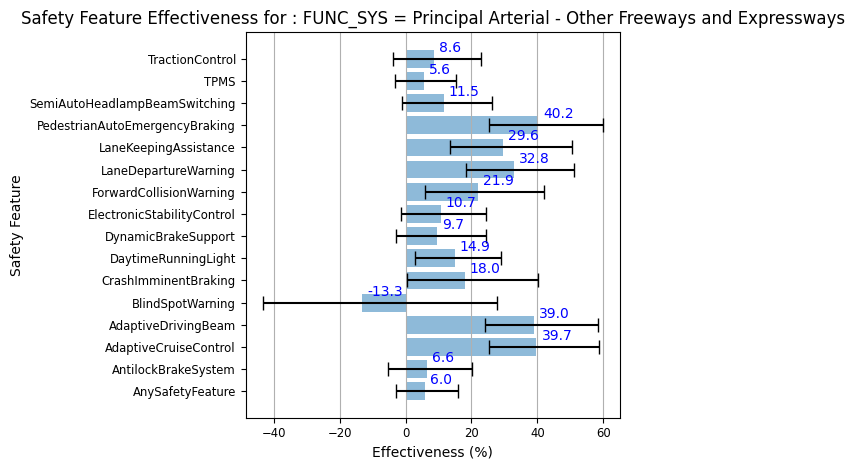

                                        E     DElow    DEhigh         R    SF    SN    NF    NN
------------------------------  ---------  --------  --------  --------  ----  ----  ----  ----
AnySafetyFeature                  5.9706    8.871     9.79509  0.940294   653   300   669   289
AntilockBrakeSystem               6.60741  11.9466   13.6989   0.933926   197    93  1125   496
AdaptiveCruiseControl            39.7304   14.3977   18.9167   0.602696    33    24  1289   565
AdaptiveDrivingBeam              38.9552   14.8146   19.562    0.610448    32    23  1290   566
BlindSpotWarning                -13.2503   30.1071   41.0093   1.1325      38    15  1284   574
CrashImminentBraking             17.964    17.4928   22.2337   0.82036     52    28  1270   561
DaytimeRunningLight              14.9268   12.031    14.0127   0.850732   144    74  1178   515
DynamicBrakeSupport               9.69125  12.5469   14.5713   0.903087   156    76  1166   513
ElectronicStabilityControl       10.6833

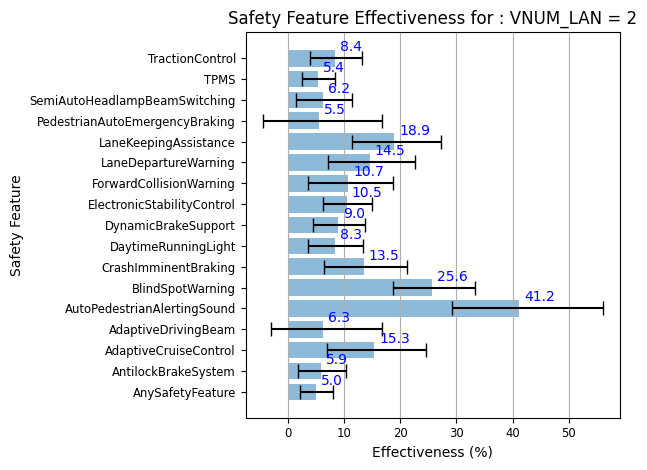

                                       E     DElow    DEhigh         R    SF    SN     NF    NN
------------------------------  --------  --------  --------  --------  ----  ----  -----  ----
AnySafetyFeature                 4.96755   2.90493   2.99653  0.950325  8679  2270  12311  3060
AntilockBrakeSystem              5.89663   4.17215   4.36571  0.941034  2652   710  18338  4620
AdaptiveCruiseControl           15.302     8.42383   9.35417  0.84698    405   121  20585  5209
AdaptiveDrivingBeam              6.28336   9.44662  10.5056   0.937166   425   115  20565  5215
AutoPedestrianAlertingSound     41.1794   11.9252   14.9577   0.588206    65    28  20925  5302
BlindSpotWarning                25.5887    6.99211   7.71727  0.744113   416   141  20574  5189
CrashImminentBraking            13.4604    7.07083   7.69997  0.865396   630   184  20360  5146
DaytimeRunningLight              8.28711   4.81074   5.07705  0.917129  1754   482  19236  4848
DynamicBrakeSupport              8.96099

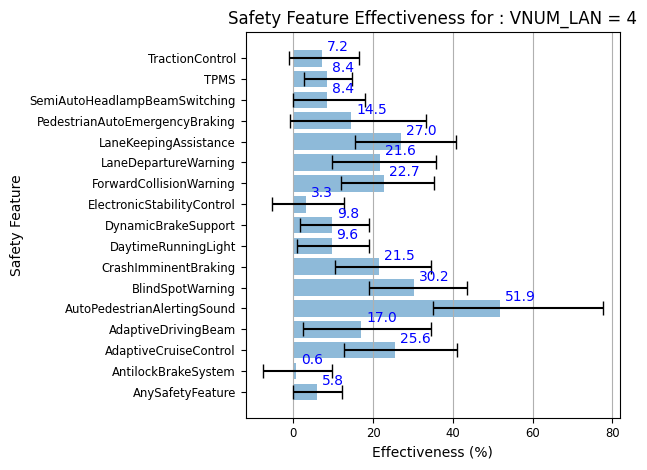

                                        E     DElow    DEhigh         R    SF    SN    NF    NN
------------------------------  ---------  --------  --------  --------  ----  ----  ----  ----
AnySafetyFeature                 5.83728    5.96708   6.37079  0.941627  1667   691  1591   621
AntilockBrakeSystem              0.611661   8.3193    9.07928  0.993883   546   221  2712  1091
AdaptiveCruiseControl           25.5954    12.863    15.5516   0.744046    82    44  3176  1268
AdaptiveDrivingBeam             16.9556    14.5772   17.6808   0.830444    85    41  3173  1271
AutoPedestrianAlertingSound     51.8669    16.8042   25.8176   0.481331    12    10  3246  1302
BlindSpotWarning                30.1994    11.2237   13.3742   0.698006    93    53  3165  1259
CrashImminentBraking            21.5344    11.1792   13.0365   0.784656   132    67  3126  1245
DaytimeRunningLight              9.57967    8.5825    9.48256  0.904203   375   165  2883  1147
DynamicBrakeSupport              9.79339

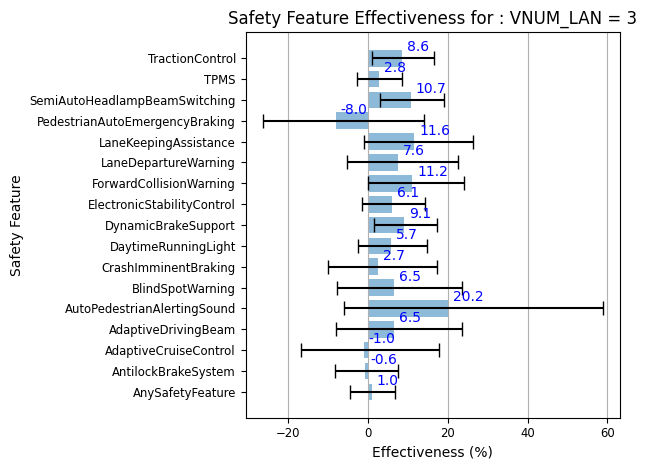

                                        E     DElow    DEhigh         R    SF    SN    NF    NN
------------------------------  ---------  --------  --------  --------  ----  ----  ----  ----
AnySafetyFeature                 0.984458   5.55495   5.88512  0.990155  1970   879  1933   854
AntilockBrakeSystem             -0.642617   7.5868    8.20535  1.00643    634   280  3269  1453
AdaptiveCruiseControl           -1.02259   15.8402   18.7858   1.01023    116    51  3787  1682
AdaptiveDrivingBeam              6.45142   14.4495   17.0891   0.935486   114    54  3789  1679
AutoPedestrianAlertingSound     20.1699    26.0752   38.7237   0.798301    18    10  3885  1723
BlindSpotWarning                 6.54728   14.3193   16.9104   0.934527   116    55  3787  1678
CrashImminentBraking             2.66209   12.7694   14.6975   0.973379   169    77  3734  1656
DaytimeRunningLight              5.69088    8.27165   9.06689  0.943091   419   196  3484  1537
DynamicBrakeSupport              9.12902

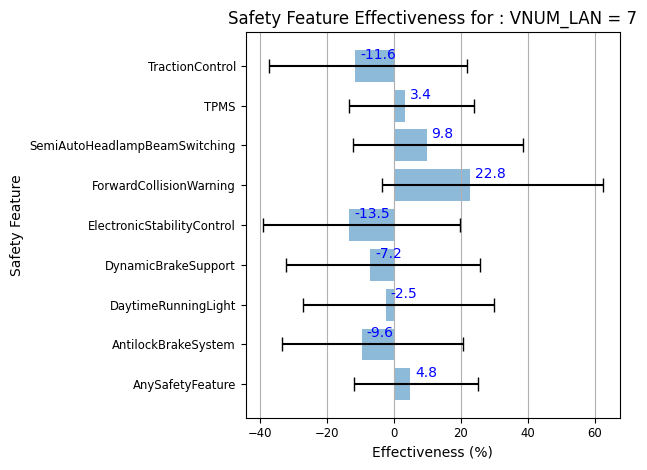

                                       E    DElow    DEhigh         R    SF    SN    NF    NN
-----------------------------  ---------  -------  --------  --------  ----  ----  ----  ----
AnySafetyFeature                 4.82759  16.7591   20.341   0.951724   186    93   145    69
AntilockBrakeSystem             -9.58491  23.7789   30.3686  1.09585     66    30   265   132
DaytimeRunningLight             -2.50422  24.5618   32.3018  1.02504     48    23   283   139
DynamicBrakeSupport             -7.16846  25.1798   32.9128  1.07168     52    24   279   138
ElectronicStabilityControl     -13.4615   25.7806   33.3609  1.13462     59    26   272   136
ForwardCollisionWarning         22.7937   26.2256   39.7167  0.772063    16    10   315   152
SemiAutoHeadlampBeamSwitching    9.76751  21.914    28.9432  0.902325    43    23   288   139
TPMS                             3.40775  16.9229   20.5176  0.965923   179    89   152    73
TractionControl                -11.5927   25.7453   33.4661 

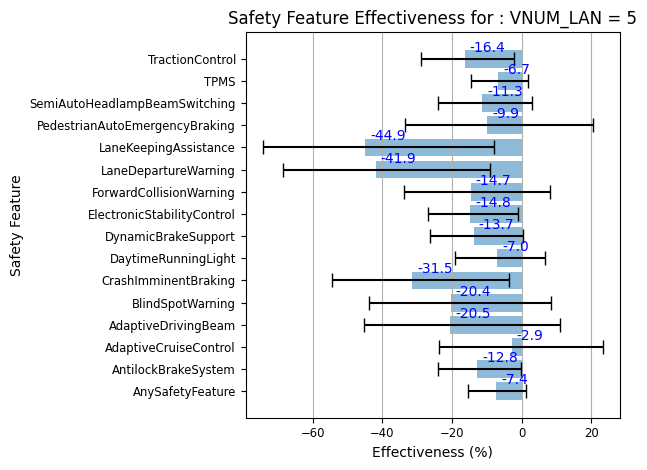

                                        E     DElow    DEhigh        R    SF    SN    NF    NN
------------------------------  ---------  --------  --------  -------  ----  ----  ----  ----
AnySafetyFeature                 -7.39611   7.95897   8.59601  1.07396  1378   487  1154   438
AntilockBrakeSystem             -12.8096   11.2601   12.5087   1.1281    433   143  2099   782
AdaptiveCruiseControl            -2.91953  20.9345   26.28     1.0292     76    27  2456   898
AdaptiveDrivingBeam             -20.4898   24.9253   31.4264   1.2049     82    25  2450   900
BlindSpotWarning                -20.442    23.3705   28.9971   1.20442    95    29  2437   896
CrashImminentBraking            -31.4846   23.0448   27.9421   1.31485   128    36  2404   889
DaytimeRunningLight              -7.00251  12.0805   13.618    1.07003   308   106  2224   819
DynamicBrakeSupport             -13.747    12.5359   14.0886   1.13747   340   111  2192   814
ElectronicStabilityControl      -14.805    12.254 

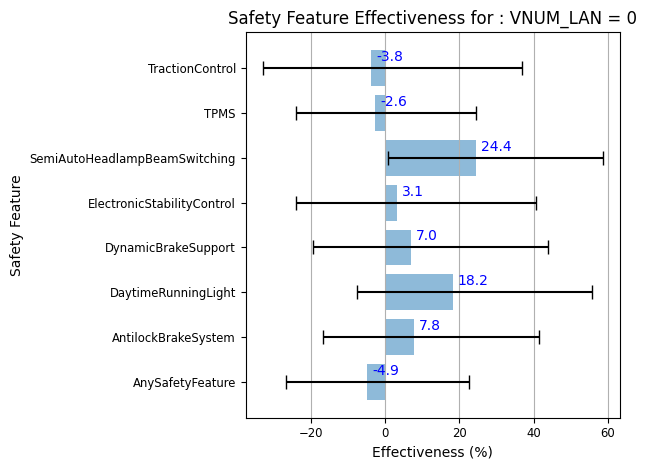

                                      E    DElow    DEhigh         R    SF    SN    NF    NN
-----------------------------  --------  -------  --------  --------  ----  ----  ----  ----
AnySafetyFeature               -4.89418  21.8473   27.5947  1.04894     52   108    56   122
AntilockBrakeSystem             7.80488  24.6019   33.5563  0.921951    18    41    90   189
DaytimeRunningLight            18.1885   25.6774   37.4229  0.818115    11    28    97   202
DynamicBrakeSupport             7.02087  26.4386   36.9435  0.929791    15    34    93   196
ElectronicStabilityControl      3.10559  27.0404   37.5077  0.968944    16    35    92   195
SemiAutoHeadlampBeamSwitching  24.3986   23.5668   34.2404  0.756014    11    30    97   200
TPMS                           -2.62726  21.4136   27.0597  1.02627     50   105    58   125
TractionControl                -3.82082  29.1645   40.5575  1.03821     16    33    92   197


VNUM_LAN 1 SIZE:  577 --------------------


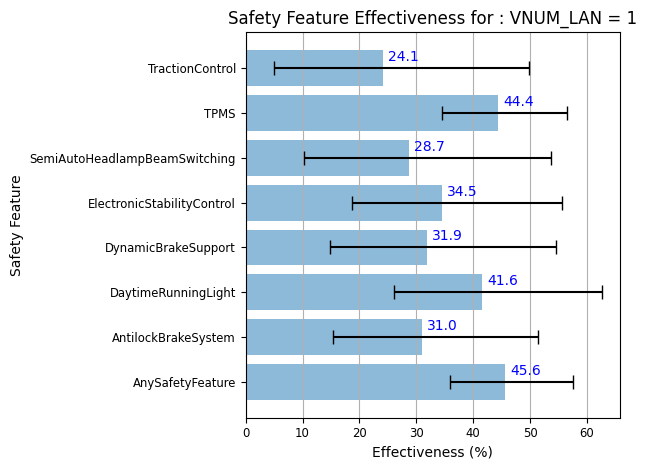

                                     E     DElow    DEhigh         R    SF    SN    NF    NN
-----------------------------  -------  --------  --------  --------  ----  ----  ----  ----
AnySafetyFeature               45.6493   9.72806   11.8488  0.543507   189    81   249    58
AntilockBrakeSystem            31.0134  15.694     20.3157  0.689866    60    26   378   113
DaytimeRunningLight            41.6184  15.4767    21.0594  0.583816    35    18   403   121
DynamicBrakeSupport            31.8702  17.0687    22.7745  0.681298    45    20   393   119
ElectronicStabilityControl     34.5455  15.8963    20.9951  0.654545    48    22   390   117
SemiAutoHeadlampBeamSwitching  28.7037  18.4923    24.9685  0.712963    42    18   396   121
TPMS                           44.401    9.91907   12.0729  0.55599    182    78   256    61
TractionControl                24.0813  19.1798    25.6632  0.759187    47    19   391   120


VNUM_LAN 6 SIZE:  800 --------------------


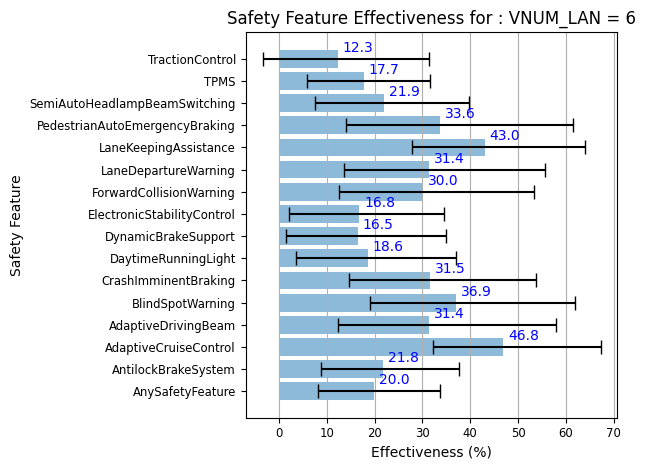

                                      E    DElow    DEhigh         R    SF    SN    NF    NN
------------------------------  -------  -------  --------  --------  ----  ----  ----  ----
AnySafetyFeature                19.9502  11.6962   13.6976  0.800498   318   150   241    91
AntilockBrakeSystem             21.8439  13.0784   15.7068  0.781561   113    59   446   182
AdaptiveCruiseControl           46.8387  14.7365   20.3882  0.531613    23    18   536   223
AdaptiveDrivingBeam             31.4024  19.1597   26.585   0.685976    26    16   533   225
BlindSpotWarning                36.9159  17.8395   24.8735  0.630841    24    16   535   225
CrashImminentBraking            31.4792  16.8544   22.3526  0.685208    36    22   523   219
DaytimeRunningLight             18.595   15.0108   18.4045  0.81405     86    44   473   197
DynamicBrakeSupport             16.4882  15.1173   18.4587  0.835118    92    46   467   195
ElectronicStabilityControl      16.7756  14.6367   17.7602  0.832244  

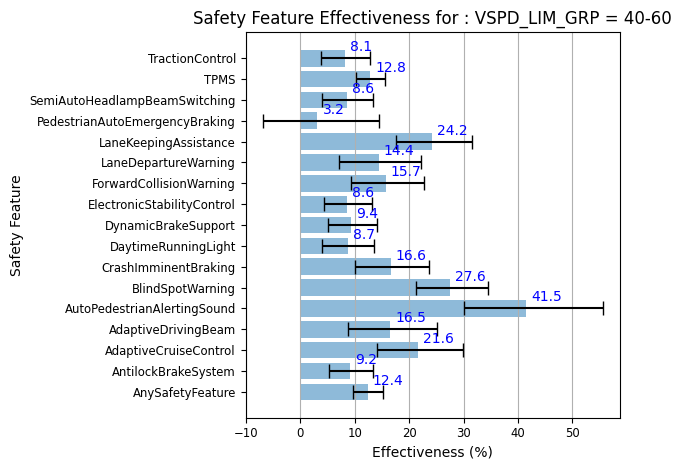

                                       E     DElow    DEhigh         R    SF    SN     NF    NN
------------------------------  --------  --------  --------  --------  ----  ----  -----  ----
AnySafetyFeature                12.3502    2.68088   2.76547  0.876498  8274  2566  10297  2799
AntilockBrakeSystem              9.21083   3.90596   4.08156  0.907892  2533   795  16038  4570
AdaptiveCruiseControl           21.6186    7.46146   8.24648  0.783814   382   140  18189  5225
AdaptiveDrivingBeam             16.5303    7.80942   8.61549  0.834697   415   143  18156  5222
AutoPedestrianAlertingSound     41.4641   11.3955   14.1501   0.585359    65    32  18506  5333
BlindSpotWarning                27.5658    6.36356   6.97646  0.724342   430   170  18141  5195
CrashImminentBraking            16.5779    6.46223   7.00486  0.834221   625   215  17946  5150
DaytimeRunningLight              8.72202   4.64385   4.89277  0.91278   1702   534  16869  4831
DynamicBrakeSupport              9.40395

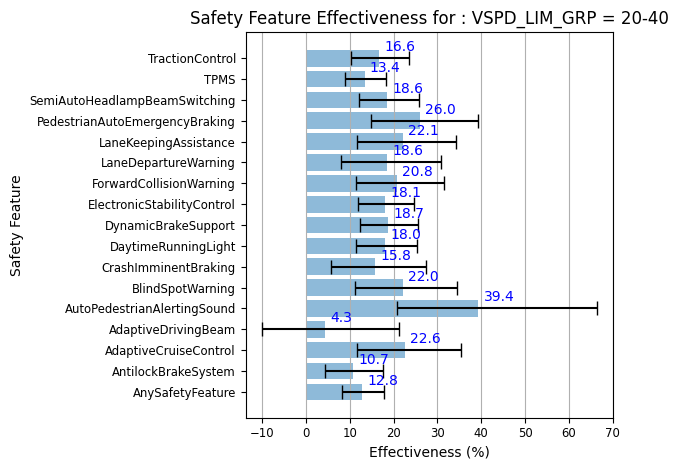

                                       E     DElow    DEhigh         R    SF    SN    NF    NN
------------------------------  --------  --------  --------  --------  ----  ----  ----  ----
AnySafetyFeature                12.8398    4.59179   4.84715  0.871602  3021   939  3060   829
AntilockBrakeSystem             10.721     6.31197   6.79217  0.89279    916   293  5165  1475
AdaptiveCruiseControl           22.5822   11.0316   12.8648   0.774178   161    60  5920  1708
AdaptiveDrivingBeam              4.34636  14.3228   16.8452   0.956536   168    51  5913  1717
AutoPedestrianAlertingSound     39.3574   18.6535   26.9404   0.606426    23    11  6058  1757
BlindSpotWarning                22.0358   10.7837   12.5147   0.779642   173    64  5908  1704
CrashImminentBraking            15.8385   10.2174   11.6292   0.841615   245    84  5836  1684
DaytimeRunningLight             18.0328    6.68563   7.27937  0.819672   605   210  5476  1558
DynamicBrakeSupport             18.6917    6.34457

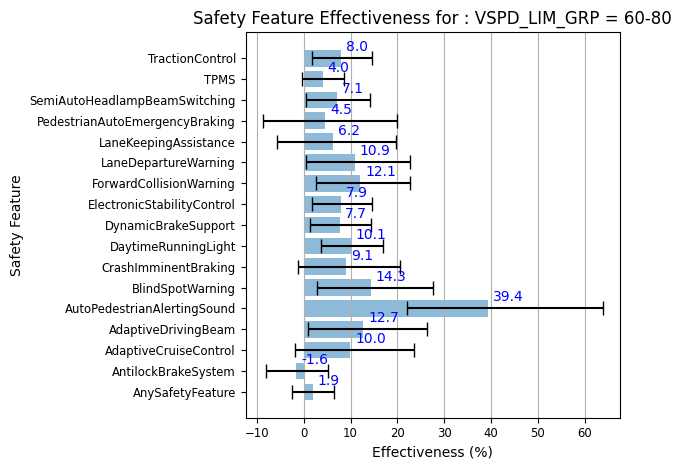

                                       E     DElow    DEhigh         R    SF    SN    NF    NN
------------------------------  --------  --------  --------  --------  ----  ----  ----  ----
AnySafetyFeature                 1.91692   4.4111    4.61882  0.980831  3012  1125  4160  1524
AntilockBrakeSystem             -1.60683   6.39905   6.82914  1.01607   1032   376  6140  2273
AdaptiveCruiseControl            9.95807  11.9025   13.7155   0.900419   176    72  6996  2577
AdaptiveDrivingBeam             12.7046   11.7347   13.5571   0.872954   166    70  7006  2579
AutoPedestrianAlertingSound     39.4471   17.4421   24.499    0.605529    23    14  7149  2635
BlindSpotWarning                14.3189   11.5461   13.3444   0.856811   163    70  7009  2579
CrashImminentBraking             9.06664  10.2522   11.5549   0.909334   252   102  6920  2547
DaytimeRunningLight             10.0709    6.42507   6.91943  0.899291   704   286  6468  2363
DynamicBrakeSupport              7.67529   6.33943

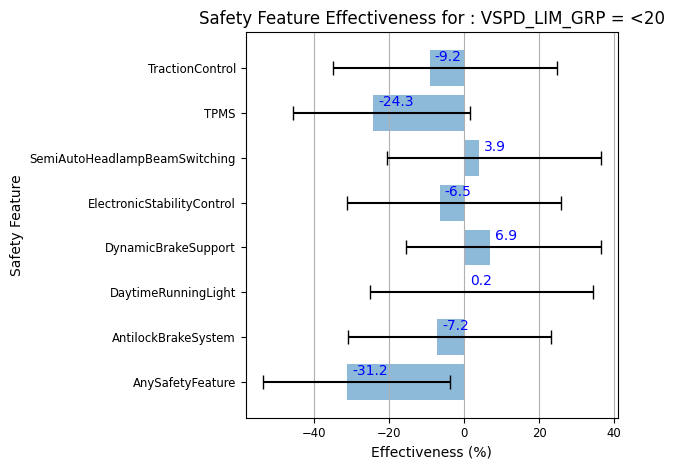

                                        E    DElow    DEhigh         R    SF    SN    NF    NN
-----------------------------  ----------  -------  --------  --------  ----  ----  ----  ----
AnySafetyFeature               -31.2249    22.6017   27.3045  1.31225    108   123    91   136
AntilockBrakeSystem             -7.20363   23.7224   30.4635  1.07204     35    43   164   216
DaytimeRunningLight              0.246212  25.4632   34.1907  0.997538    23    30   176   229
DynamicBrakeSupport              6.9043    22.4954   29.6631  0.930957    26    36   173   223
ElectronicStabilityControl      -6.50888   24.8803   32.4638  1.06509     30    37   169   222
SemiAutoHeadlampBeamSwitching    3.88563   24.4054   32.7116  0.961144    23    31   176   228
TPMS                           -24.2795    21.3841   25.8282  1.2428     103   120    96   139
TractionControl                 -9.17647   25.9105   33.9733  1.09176     29    35   170   224


VSPD_LIM_GRP 4 SIZE:  127 --------------------
E

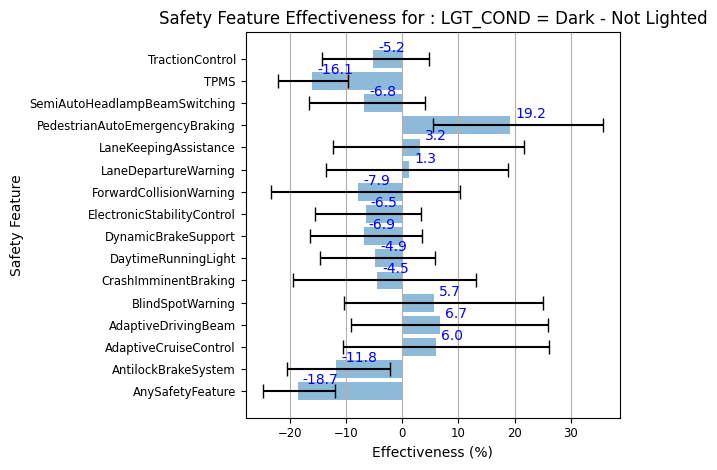

                                        E     DElow    DEhigh         R    SF    SN    NF    NN
------------------------------  ---------  --------  --------  --------  ----  ----  ----  ----
AnySafetyFeature                -18.6897    6.23543   6.58118  1.1869    4026   669  5192  1024
AntilockBrakeSystem             -11.7975    8.81416   9.56855  1.11798   1177   196  8041  1497
AdaptiveCruiseControl             5.9794   16.6641   20.2539   0.940206   164    32  9054  1661
AdaptiveDrivingBeam               6.7244   15.8951   19.1602   0.932756   178    35  9040  1658
BlindSpotWarning                  5.65549  16.0642   19.3608   0.943445   180    35  9038  1658
CrashImminentBraking             -4.45758  15.0609   17.5982   1.04458    284    50  8934  1643
DaytimeRunningLight              -4.89099   9.72627  10.7203   1.04891    768   135  8450  1558
DynamicBrakeSupport              -6.93206   9.4635   10.3823   1.06932    868   150  8350  1543
ElectronicStabilityControl       -6.5300

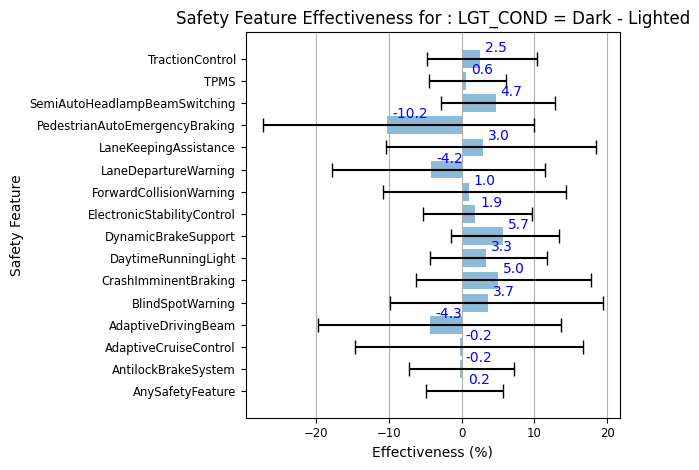

                                         E     DElow    DEhigh         R    SF    SN    NF    NN
------------------------------  ----------  --------  --------  --------  ----  ----  ----  ----
AnySafetyFeature                  0.232421   5.18612   5.47049  0.997676  3328  1003  2787   838
AntilockBrakeSystem              -0.225179   6.94163   7.45819  1.00225   1005   302  5110  1539
AdaptiveCruiseControl            -0.177159  14.4803   16.9271   1.00177    183    55  5932  1786
AdaptiveDrivingBeam              -4.34191   15.4036   18.0714   1.04342    180    52  5935  1789
BlindSpotWarning                  3.67127   13.547    15.7639   0.963287   189    59  5926  1782
CrashImminentBraking              5.00261   11.3024   12.8287   0.949974   272    86  5843  1755
DaytimeRunningLight               3.33799    7.70148   8.36822  0.96662    693   215  5422  1626
DynamicBrakeSupport               5.73675    7.13154   7.71524  0.942633   773   245  5342  1596
ElectronicStabilityControl    

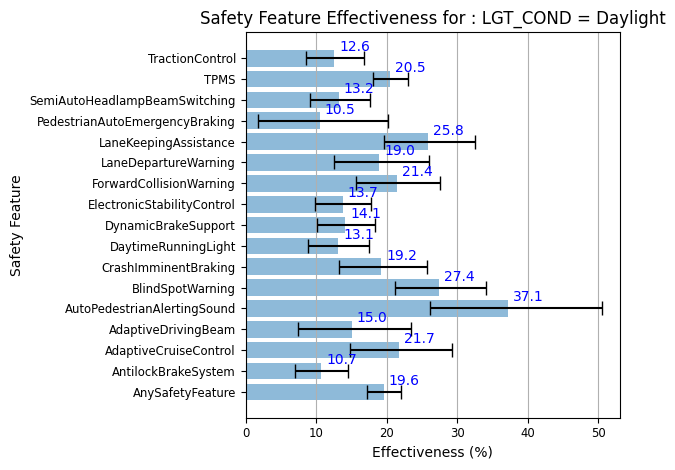

                                      E     DElow    DEhigh         R    SF    SN     NF    NN
------------------------------  -------  --------  --------  --------  ----  ----  -----  ----
AnySafetyFeature                19.5988   2.42858   2.50422  0.804012  6324  2866   8634  3146
AntilockBrakeSystem             10.6818   3.7167    3.87808  0.893182  2129   942  12829  5070
AdaptiveCruiseControl           21.6898   6.94653   7.6227   0.783102   353   180  14605  5832
AdaptiveDrivingBeam             15.0441   7.62468   8.37646  0.849559   363   171  14595  5841
AutoPedestrianAlertingSound     37.1421  11.0603   13.422    0.628579    69    44  14889  5968
BlindSpotWarning                27.3571   6.13772   6.70416  0.726429   374   205  14584  5807
CrashImminentBraking            19.2166   6.00431   6.48642  0.807834   529   261  14429  5751
DaytimeRunningLight             13.1234   4.21508   4.43002  0.868766  1443   658  13515  5354
DynamicBrakeSupport             14.1371   3.9761  

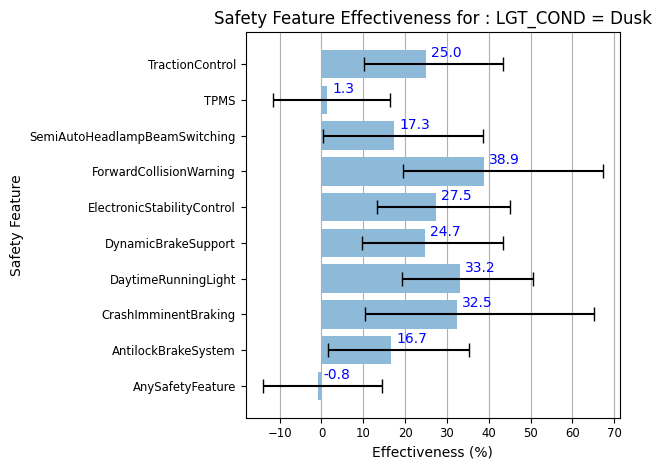

                                       E    DElow    DEhigh         R    SF    SN    NF    NN
-----------------------------  ---------  -------  --------  --------  ----  ----  ----  ----
AnySafetyFeature               -0.838792  13.211    15.2027  1.00839    353   120   458   157
AntilockBrakeSystem            16.6667    15.212    18.609   0.833333   100    40   711   237
CrashImminentBraking           32.4905    21.9711   32.5716  0.675095    20    10   791   267
DaytimeRunningLight            33.1637    13.8054   17.3994  0.668363    63    31   748   246
DynamicBrakeSupport            24.6542    14.9743   18.6884  0.753458    75    33   736   244
ElectronicStabilityControl     27.4659    14.1444   17.5707  0.725341    77    35   734   242
ForwardCollisionWarning        38.8576    19.4135   28.4452  0.611424    20    11   791   266
SemiAutoHeadlampBeamSwitching  17.3315    16.8928   21.2312  0.826685    74    30   737   247
TPMS                            1.3222    12.9857   14.9535 

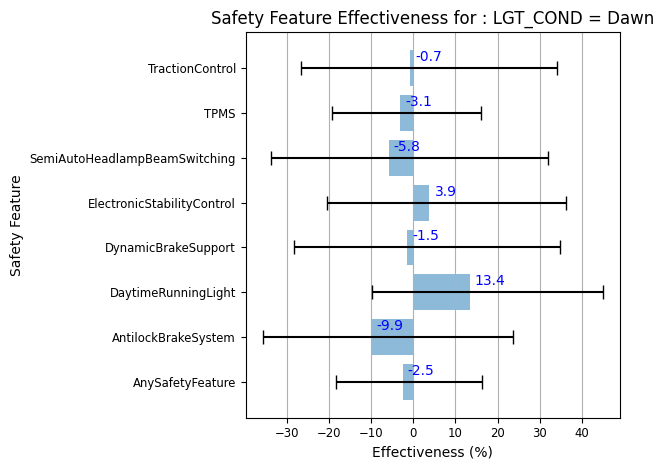

                                      E    DElow    DEhigh         R    SF    SN    NF    NN
-----------------------------  --------  -------  --------  --------  ----  ----  ----  ----
AnySafetyFeature               -2.50101  15.8539   18.7547  1.02501    252    74   402   121
AntilockBrakeSystem            -9.93976  25.7374   33.6043  1.0994      73    20   581   175
DaytimeRunningLight            13.4426   23.1221   31.5501  0.865574    44    15   610   180
DynamicBrakeSupport            -1.49254  26.7368   36.2993  1.01493     51    15   603   180
ElectronicStabilityControl      3.85937  24.226    32.387   0.961406    55    17   599   178
SemiAutoHeadlampBeamSwitching  -5.82363  27.7839   37.6755  1.05824     53    15   601   180
TPMS                           -3.09965  16.1587   19.1619  1.031      236    69   418   126
TractionControl                -0.6875   25.8802   34.8336  1.00687     54    16   600   179


LGT_COND 6 SIZE:  276 --------------------
E    DElow    DEhigh    R

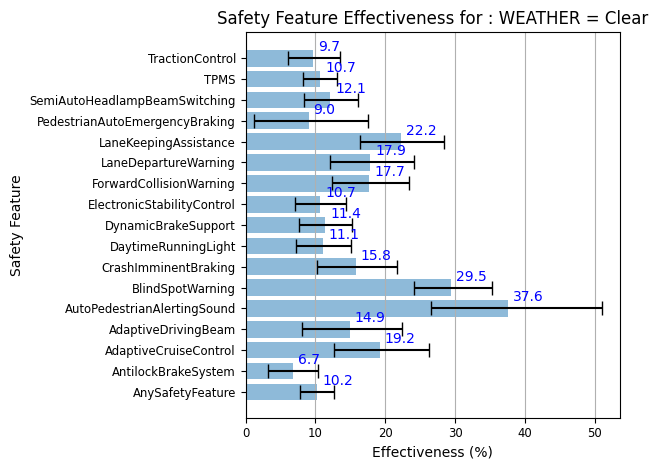

                                       E     DElow    DEhigh         R    SF    SN     NF    NN
------------------------------  --------  --------  --------  --------  ----  ----  -----  ----
AnySafetyFeature                10.235     2.42606   2.49345  0.89765   9931  3415  11870  3664
AntilockBrakeSystem              6.71804   3.50843   3.64555  0.93282   3123  1076  18678  6003
AdaptiveCruiseControl           19.195     6.49433   7.0619   0.80805    513   205  21288  6874
AdaptiveDrivingBeam             14.9032    6.85702   7.45798  0.850968   529   201  21272  6878
AutoPedestrianAlertingSound     37.6262   11.0702   13.4589   0.623738    77    40  21724  7039
BlindSpotWarning                29.4882    5.38468   5.82989  0.705118   522   238  21279  6841
CrashImminentBraking            15.753     5.58186   5.97794  0.84247    802   307  20999  6772
DaytimeRunningLight             11.0836    3.88627   4.06389  0.889164  2109   761  19692  6318
DynamicBrakeSupport             11.3949 

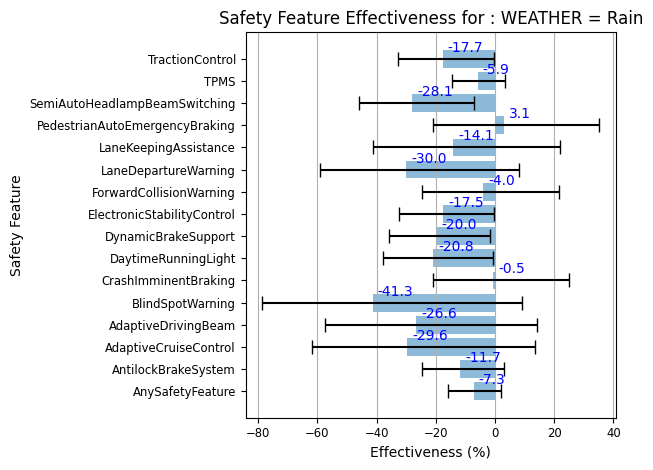

                                         E     DElow    DEhigh         R    SF    SN    NF    NN
------------------------------  ----------  --------  --------  --------  ----  ----  ----  ----
AnySafetyFeature                 -7.26009    8.57302   9.31777  1.0726    1230   322  1510   424
AntilockBrakeSystem             -11.6841    12.9653   14.6681   1.11684    380    94  2360   652
AdaptiveCruiseControl           -29.6391    32.3646   43.1327   1.29639     71    15  2669   731
AdaptiveDrivingBeam             -26.641     30.8179   40.7293   1.26641     74    16  2666   730
BlindSpotWarning                -41.3307    37.2483   50.5785   1.41331     67    13  2673   733
CrashImminentBraking             -0.546957  20.2622   25.376    1.00547     96    26  2644   720
DaytimeRunningLight             -20.8287    17.1433   19.9777   1.20829    249    57  2491   689
DynamicBrakeSupport             -19.9574    15.913    18.3467   1.19957    290    67  2450   679
ElectronicStabilityControl    

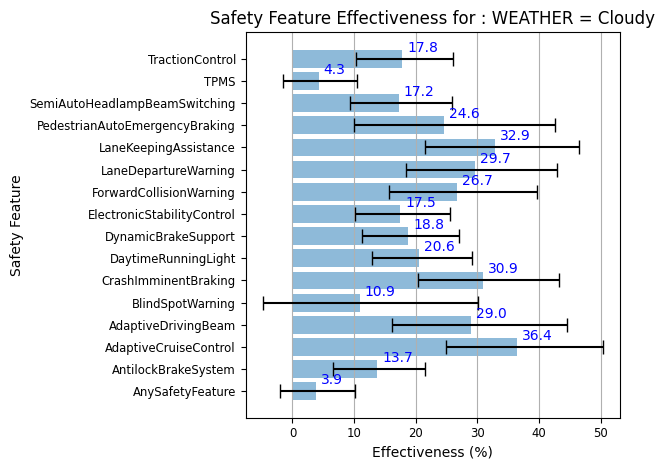

                                       E     DElow    DEhigh         R    SF    SN    NF    NN
------------------------------  --------  --------  --------  --------  ----  ----  ----  ----
AnySafetyFeature                 3.86961   5.83712   6.21447  0.961304  1995   607  2489   728
AntilockBrakeSystem             13.7242    7.1519    7.79835  0.862758   625   211  3859  1124
AdaptiveCruiseControl           36.42     11.461    13.9812   0.6358      82    38  4402  1297
AdaptiveDrivingBeam             28.9598   12.7693   15.5676   0.710402    89    37  4395  1298
BlindSpotWarning                10.9461   15.7792   19.1772   0.890539   108    36  4376  1299
CrashImminentBraking            30.8533   10.5492   12.4483   0.691467   127    54  4357  1281
DaytimeRunningLight             20.5836    7.67129   8.49154  0.794164   404   148  4080  1187
DynamicBrakeSupport             18.7722    7.49926   8.26204  0.812278   458   164  4026  1171
ElectronicStabilityControl      17.5221    7.36784

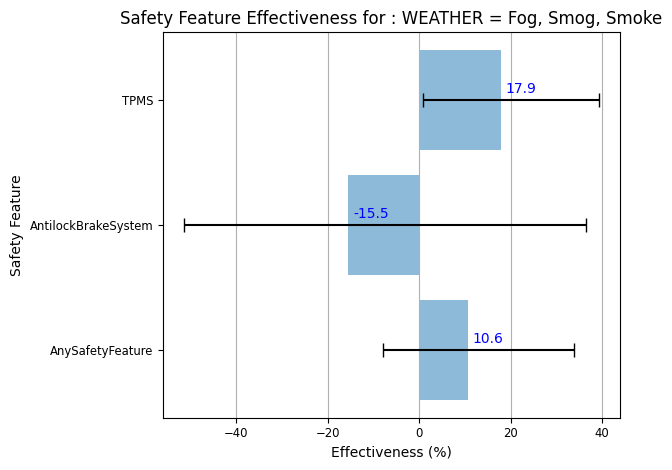

                            E    DElow    DEhigh         R    SF    SN    NF    NN
-------------------  --------  -------  --------  --------  ----  ----  ----  ----
AnySafetyFeature      10.6196  18.4869   23.3078  0.893804   131    39   233    62
AntilockBrakeSystem  -15.5108  35.8927   52.0735  1.15511     41    10   323    91
TPMS                  17.8632  17.0316   21.4871  0.821368   124    39   240    62


WEATHER 12 SIZE:  57 --------------------
E    DElow    DEhigh    R    SF    SN    NF    NN
---  -------  --------  ---  ----  ----  ----  ----


WEATHER 4 SIZE:  442 --------------------


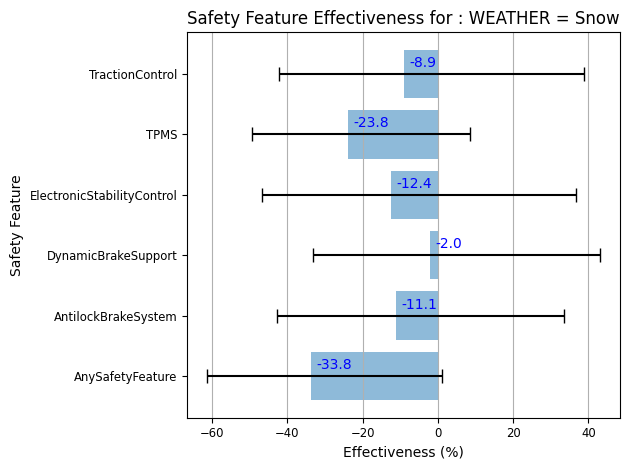

                                    E    DElow    DEhigh        R    SF    SN    NF    NN
--------------------------  ---------  -------  --------  -------  ----  ----  ----  ----
AnySafetyFeature            -33.7734   27.6696   34.8853  1.33773   128    36   202    76
AntilockBrakeSystem         -11.0577   31.8591   44.675   1.11058    42    13   288    99
DynamicBrakeSupport          -2.0202   31.3195   45.1936  1.0202     33    11   297   101
ElectronicStabilityControl  -12.4304   34.2491   49.2526  1.1243     36    11   294   101
TPMS                        -23.8248   25.663    32.3721  1.23825   122    36   208    76
TractionControl              -8.93683  33.2662   47.8906  1.08937    35    11   295   101


WEATHER 11 SIZE:  41 --------------------
E    DElow    DEhigh    R    SF    SN    NF    NN
---  -------  --------  ---  ----  ----  ----  ----


WEATHER 3 SIZE:  36 --------------------
E    DElow    DEhigh    R    SF    SN    NF    NN
---  -------  --------  ---  ----  ----  

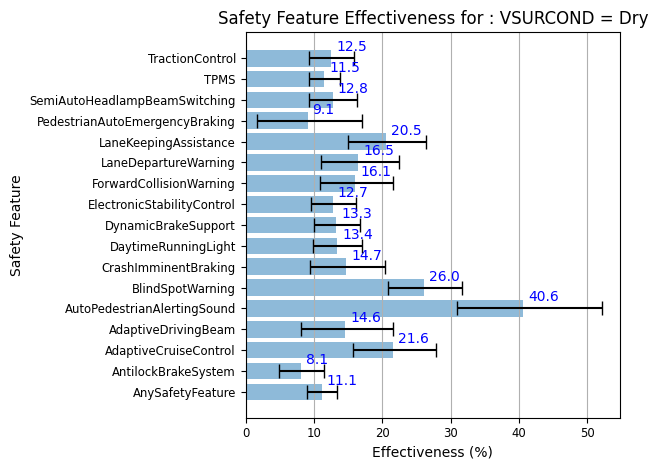

                                       E    DElow    DEhigh         R     SF    SN     NF    NN
------------------------------  --------  -------  --------  --------  -----  ----  -----  ----
AnySafetyFeature                11.1204   2.21193   2.26838  0.888796  12075  3995  14572  4285
AntilockBrakeSystem              8.10452  3.18169   3.2958   0.918955   3785  1264  22862  7016
AdaptiveCruiseControl           21.574    5.84286   6.31321  0.78426     607   239  26040  8041
AdaptiveDrivingBeam             14.5902   6.4228    6.94507  0.854098    632   229  26015  8051
AutoPedestrianAlertingSound     40.5837   9.71311  11.6113   0.594163     92    48  26555  8232
BlindSpotWarning                26.0403   5.22654   5.62397  0.739597    653   272  25994  8008
CrashImminentBraking            14.7437   5.28213   5.631    0.852563    958   347  25689  7933
DaytimeRunningLight             13.3992   3.47378   3.61895  0.866008   2554   903  24093  7377
DynamicBrakeSupport             13.2697 

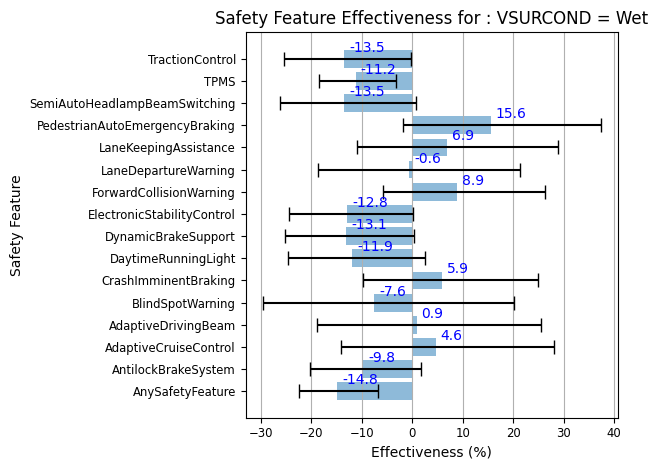

                                         E     DElow    DEhigh         R    SF    SN    NF    NN
------------------------------  ----------  --------  --------  --------  ----  ----  ----  ----
AnySafetyFeature                -14.8286     7.56902   8.10314  1.14829   1961   463  2368   642
AntilockBrakeSystem              -9.75199   10.448    11.5472   1.09752    603   142  3726   963
AdaptiveCruiseControl             4.6235    18.7832   23.3894   0.953765   101    27  4228  1078
AdaptiveDrivingBeam               0.863292  19.7798   24.7099   0.991367   101    26  4228  1079
BlindSpotWarning                 -7.59717   22.0758   27.7743   1.07597    101    24  4228  1081
CrashImminentBraking              5.94982   15.7866   18.9709   0.940502   144    39  4185  1066
DaytimeRunningLight             -11.8818    12.7998   14.4533   1.11882    395    91  3934  1014
DynamicBrakeSupport             -13.1431    12.1249   13.5802   1.13143    464   106  3865   999
ElectronicStabilityControl    

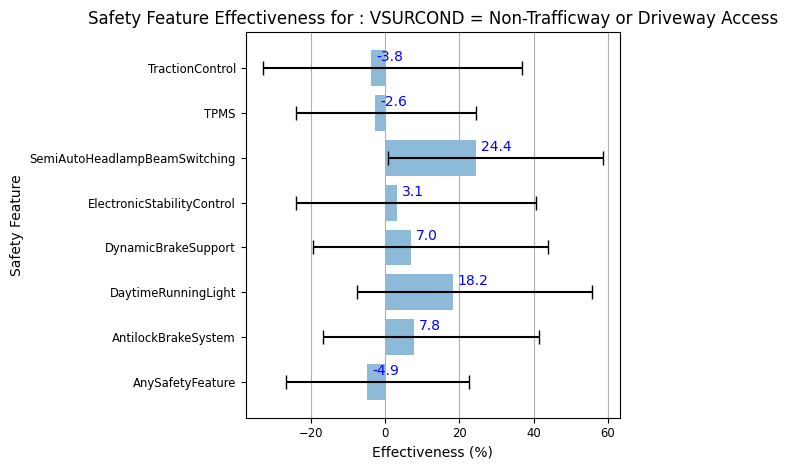

                                      E    DElow    DEhigh         R    SF    SN    NF    NN
-----------------------------  --------  -------  --------  --------  ----  ----  ----  ----
AnySafetyFeature               -4.89418  21.8473   27.5947  1.04894     52   108    56   122
AntilockBrakeSystem             7.80488  24.6019   33.5563  0.921951    18    41    90   189
DaytimeRunningLight            18.1885   25.6774   37.4229  0.818115    11    28    97   202
DynamicBrakeSupport             7.02087  26.4386   36.9435  0.929791    15    34    93   196
ElectronicStabilityControl      3.10559  27.0404   37.5077  0.968944    16    35    92   195
SemiAutoHeadlampBeamSwitching  24.3986   23.5668   34.2404  0.756014    11    30    97   200
TPMS                           -2.62726  21.4136   27.0597  1.02627     50   105    58   125
TractionControl                -3.82082  29.1645   40.5575  1.03821     16    33    92   197


VSURCOND 4 SIZE:  329 --------------------
E    DElow    DEhigh    R

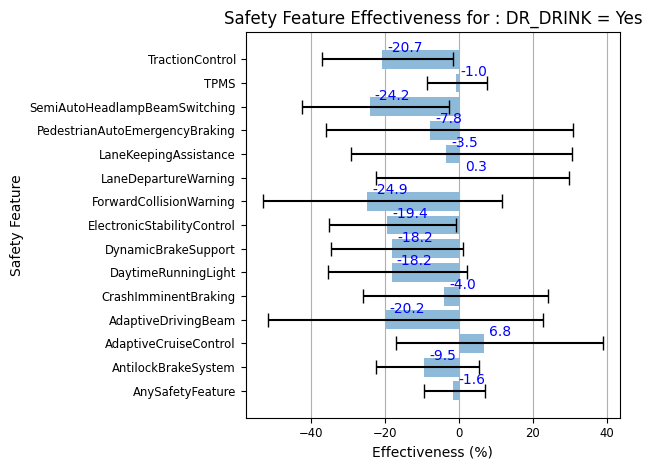

                                         E     DElow    DEhigh         R    SF    SN    NF    NN
------------------------------  ----------  --------  --------  --------  ----  ----  ----  ----
AnySafetyFeature                 -1.61414    7.86005   8.51902  1.01614   2616   291  3698   418
AntilockBrakeSystem              -9.4667    13.0427   14.8069   1.09467    743    77  5571   632
AdaptiveCruiseControl             6.82962   23.8906   32.1292   0.931704   108    13  6206   696
AdaptiveDrivingBeam             -20.1854    31.5528   42.7855   1.20185    128    12  6186   697
CrashImminentBraking             -3.98515   22.0884   28.0458   1.03985    185    20  6129   689
DaytimeRunningLight             -18.2424    17.2939   20.2565   1.18242    489    47  5825   662
DynamicBrakeSupport             -18.1623    16.5529   19.2495   1.18162    540    52  5774   657
ElectronicStabilityControl      -19.3806    15.9616   18.425    1.19381    607    58  5707   651
ForwardCollisionWarning       

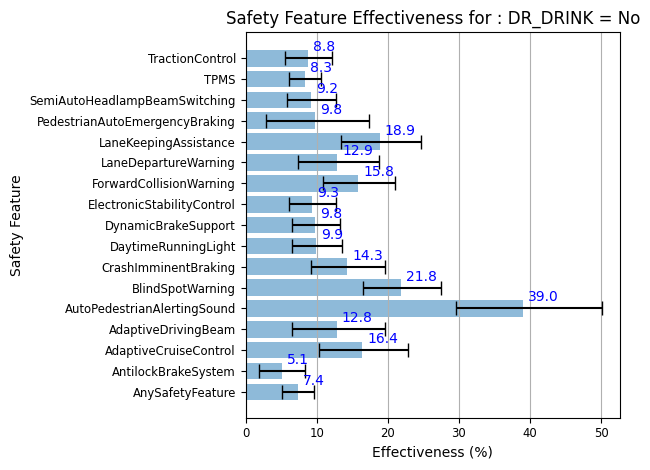

                                       E    DElow    DEhigh         R     SF    SN     NF    NN
------------------------------  --------  -------  --------  --------  -----  ----  -----  ----
AnySafetyFeature                 7.36013  2.21229   2.26642  0.926399  11823  4468  13982  4895
AntilockBrakeSystem              5.05584  3.14395   3.25162  0.949442   3779  1433  22026  7930
AdaptiveCruiseControl           16.3653   5.99504   6.45795  0.836347    616   266  25189  9097
AdaptiveDrivingBeam             12.8118   6.28134   6.76901  0.871882    627   260  25178  9103
AutoPedestrianAlertingSound     39.0359   9.40988  11.1274   0.609641     96    57  25709  9306
BlindSpotWarning                21.806    5.30689   5.69328  0.78194     662   305  25143  9058
CrashImminentBraking            14.2815   5.07282   5.39191  0.857185    946   398  24859  8965
DaytimeRunningLight              9.93149  3.46678   3.60556  0.900685   2547  1015  23258  8348
DynamicBrakeSupport              9.79819

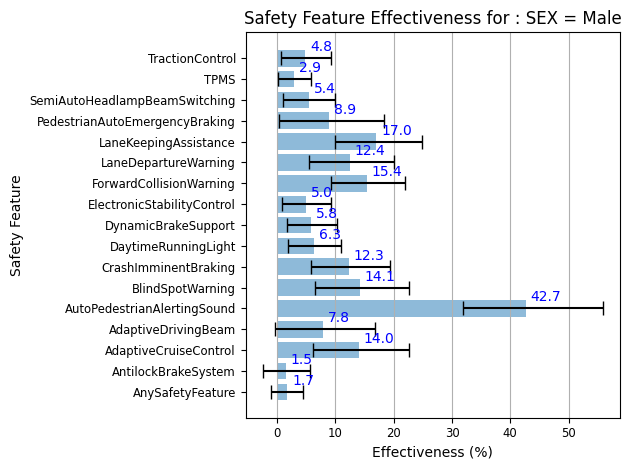

                                       E     DElow    DEhigh         R    SF    SN     NF    NN
------------------------------  --------  --------  --------  --------  ----  ----  -----  ----
AnySafetyFeature                 1.68696   2.72863   2.80653  0.98313   9144  2693  14295  4139
AntilockBrakeSystem              1.47601   3.97245   4.13935  0.98524   2970   877  20469  5955
AdaptiveCruiseControl           13.993     7.85484   8.64431  0.86007    441   149  22998  6683
AdaptiveDrivingBeam              7.79724   8.2274    9.03347  0.922028   488   154  22951  6678
AutoPedestrianAlertingSound     42.6624   10.7665   13.2555   0.573376    69    35  23370  6797
BlindSpotWarning                14.1421    7.6766    8.43036  0.858579   461   156  22978  6676
CrashImminentBraking            12.3087    6.46198   6.97604  0.876913   710   235  22729  6597
DaytimeRunningLight              6.25011   4.41408   4.63217  0.937499  1999   618  21440  6214
DynamicBrakeSupport              5.8462 

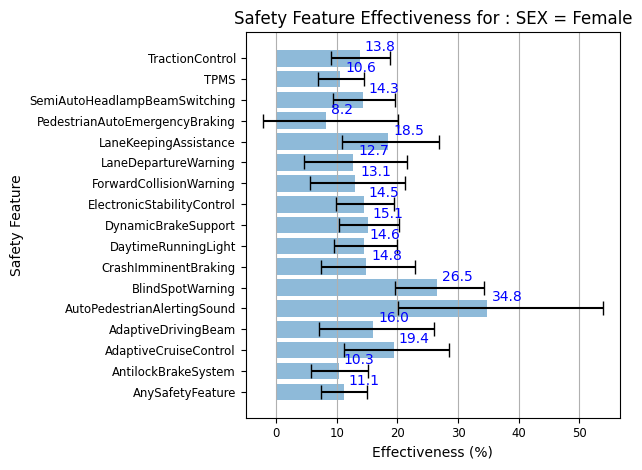

                                       E     DElow    DEhigh         R    SF    SN    NF    NN
------------------------------  --------  --------  --------  --------  ----  ----  ----  ----
AnySafetyFeature                11.1116    3.71245   3.87426  0.888884  5295  2066  3385  1174
AntilockBrakeSystem             10.3271    4.57968   4.82615  0.896729  1552   633  7128  2607
AdaptiveCruiseControl           19.3732    8.2548    9.19635  0.806268   283   130  8397  3110
AdaptiveDrivingBeam             16.0325    8.9353    9.99938  0.839675   267   118  8413  3122
AutoPedestrianAlertingSound     34.846    14.7516   19.0691   0.65154     42    24  8638  3216
BlindSpotWarning                26.5452    6.97275   7.70407  0.734548   315   158  8365  3082
CrashImminentBraking            14.8472    7.40977   8.116    0.851528   421   183  8259  3057
DaytimeRunningLight             14.5585    5.04564   5.36231  0.854415  1037   444  7643  2796
DynamicBrakeSupport             15.1315    4.77759

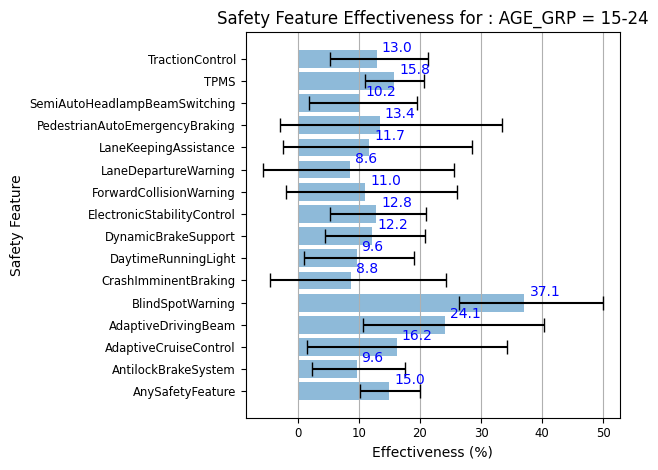

                                       E     DElow    DEhigh         R    SF    SN    NF    NN
------------------------------  --------  --------  --------  --------  ----  ----  ----  ----
AnySafetyFeature                14.9864    4.73362   5.01273  0.850136  3008   787  3273   728
AntilockBrakeSystem              9.636     7.29185   7.9319   0.90364    782   206  5499  1309
AdaptiveCruiseControl           16.2387   14.7653   17.9252   0.837613   122    35  6159  1480
AdaptiveDrivingBeam             24.0555   13.3522   16.2004   0.759445   114    36  6167  1479
BlindSpotWarning                37.1014   10.6607   12.8363   0.628986   108    41  6173  1474
CrashImminentBraking             8.80648  13.2606   15.5169   0.911935   201    53  6080  1462
DaytimeRunningLight              9.63962   8.54565   9.43826  0.903604   533   141  5748  1374
DynamicBrakeSupport             12.2362    7.82212   8.5875   0.877638   601   163  5680  1352
ElectronicStabilityControl      12.8086    7.47561

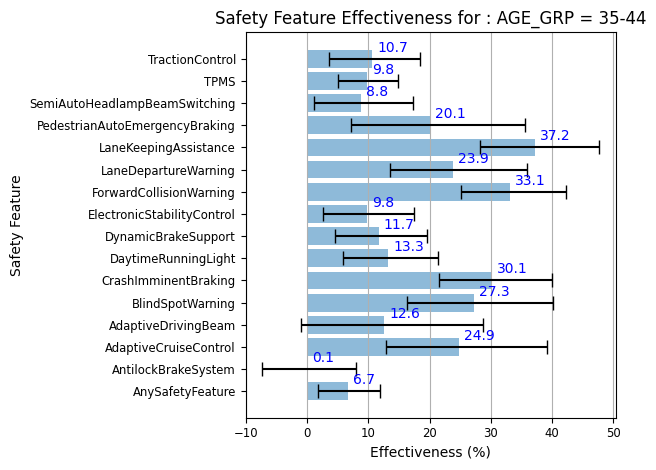

                                         E     DElow    DEhigh         R    SF    SN    NF    NN
------------------------------  ----------  --------  --------  --------  ----  ----  ----  ----
AnySafetyFeature                 6.73887     4.89784   5.16932  0.932611  2511   831  3240  1000
AntilockBrakeSystem              0.0673725   7.32769   7.90752  0.999326   835   266  4916  1565
AdaptiveCruiseControl           24.878      12.0094   14.2947   0.75122    114    48  5637  1783
AdaptiveDrivingBeam             12.5785     13.5919   16.0942   0.874215   135    49  5616  1782
BlindSpotWarning                27.2707     10.8976   12.8182   0.727293   129    56  5622  1775
CrashImminentBraking            30.1146      8.59435   9.79946  0.698854   196    88  5555  1743
DaytimeRunningLight             13.2712      7.42355   8.11844  0.867288   522   189  5229  1642
DynamicBrakeSupport             11.7315      7.19844   7.83761  0.882685   593   211  5158  1620
ElectronicStabilityControl    

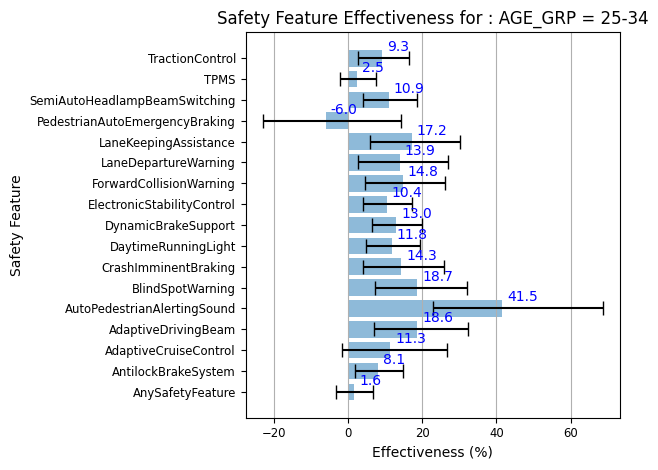

                                       E     DElow    DEhigh         R    SF    SN    NF    NN
------------------------------  --------  --------  --------  --------  ----  ----  ----  ----
AnySafetyFeature                 1.64585   4.84998   5.10155  0.983541  3667   985  3770   996
AntilockBrakeSystem              8.07168   6.22567   6.67792  0.919283  1080   309  6357  1672
AdaptiveCruiseControl           11.3114   13.0121   15.2494   0.886886   177    53  7260  1928
AdaptiveDrivingBeam             18.6167   11.7533   13.7373   0.813833   172    56  7265  1925
AutoPedestrianAlertingSound     41.5212   18.5763   27.2244   0.584788    22    10  7415  1971
BlindSpotWarning                18.6993   11.5588   13.4745   0.813007   178    58  7259  1923
CrashImminentBraking            14.2684   10.2602   11.655    0.857316   272    84  7165  1897
DaytimeRunningLight             11.8174    6.88951   7.47339  0.881826   738   220  6699  1761
DynamicBrakeSupport             13.0029    6.48227

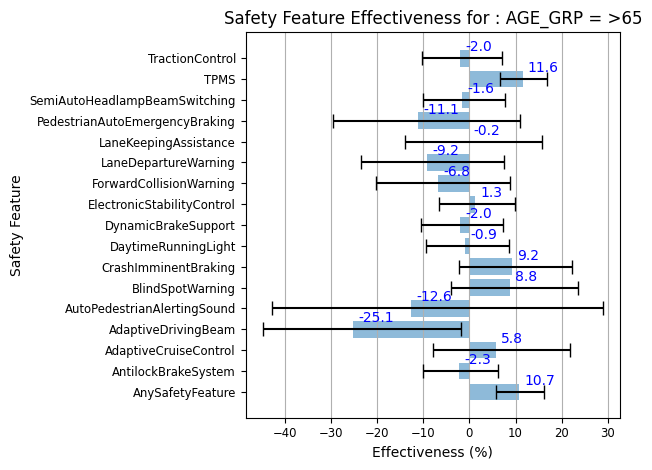

                                         E     DElow    DEhigh         R    SF    SN    NF    NN
------------------------------  ----------  --------  --------  --------  ----  ----  ----  ----
AnySafetyFeature                 10.7455     5.03266   5.33339  0.892545  1915   841  2143   840
AntilockBrakeSystem              -2.25785    7.72855   8.36043  1.02258    669   272  3389  1409
AdaptiveCruiseControl             5.80568   13.6375   15.9462   0.941943   139    61  3919  1620
AdaptiveDrivingBeam             -25.1468    19.6689   23.3366   1.25147    141    47  3917  1634
AutoPedestrianAlertingSound     -12.5551    30.3311   41.5197   1.12555     38    14  4020  1667
BlindSpotWarning                  8.81704   12.7161   14.7768   0.91183    148    67  3910  1614
CrashImminentBraking              9.18662   11.4593   13.1141   0.908134   185    84  3873  1597
DaytimeRunningLight              -0.885318   8.61929   9.42448  1.00885    489   201  3569  1480
DynamicBrakeSupport           

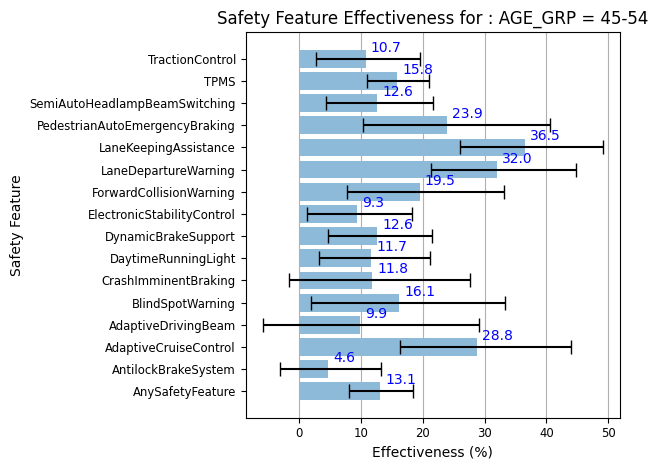

                                       E     DElow    DEhigh         R    SF    SN    NF    NN
------------------------------  --------  --------  --------  --------  ----  ----  ----  ----
AnySafetyFeature                13.1096    5.01885   5.32652  0.868904  1792   681  2662   879
AntilockBrakeSystem              4.62052   7.82196   8.52074  0.953795   592   216  3862  1344
AdaptiveCruiseControl           28.785    12.4894   15.1455   0.71215     84    41  4370  1519
AdaptiveDrivingBeam              9.89077  15.8461   19.2273   0.901092    98    38  4356  1522
BlindSpotWarning                16.1399   14.2338   17.1437   0.838601   101    42  4353  1518
CrashImminentBraking            11.8021   13.4156   15.8223   0.881979   134    53  4320  1507
DaytimeRunningLight             11.671     8.52341   9.43373  0.88329    380   149  4074  1411
DynamicBrakeSupport             12.6272    7.98115   8.78348  0.873728   430   170  4024  1390
ElectronicStabilityControl       9.33969   8.05362

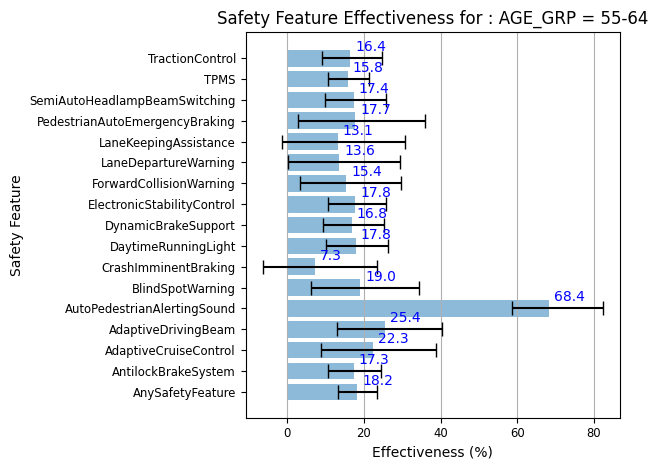

                                       E     DElow    DEhigh         R    SF    SN    NF    NN
------------------------------  --------  --------  --------  --------  ----  ----  ----  ----
AnySafetyFeature                18.1722    4.8842    5.19424  0.818278  1531   629  2573   865
AntilockBrakeSystem             17.2671    6.6534    7.23526  0.827329   561   240  3543  1254
AdaptiveCruiseControl           22.3448   13.5369   16.3949   0.776552    88    41  4016  1453
AdaptiveDrivingBeam             25.407    12.4261   14.9099   0.74593     95    46  4009  1448
AutoPedestrianAlertingSound     68.3802    9.71809  14.0301   0.316198    14    16  4090  1478
BlindSpotWarning                18.9739   12.8607   15.2871   0.810261   112    50  3992  1444
CrashImminentBraking             7.29524  13.7558   16.1525   0.927048   143    56  3961  1438
DaytimeRunningLight             17.7998    7.77483   8.58702  0.822002   373   162  3731  1332
DynamicBrakeSupport             16.8283    7.55095

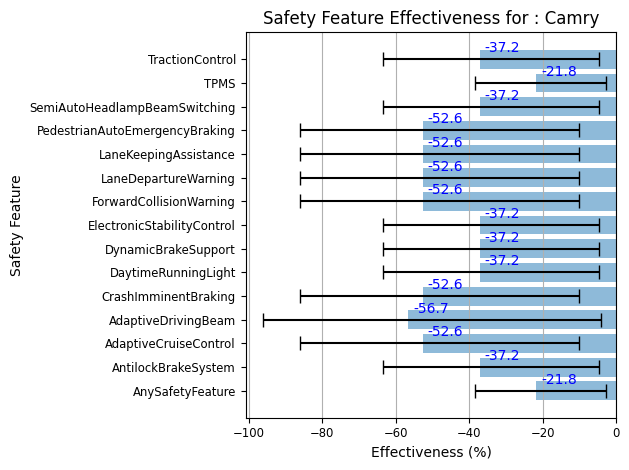

                                       E    DElow    DEhigh        R    SF    SN    NF    NN
------------------------------  --------  -------  --------  -------  ----  ----  ----  ----
AnySafetyFeature                -21.8012  16.5188   19.1107  1.21801   375   127   320   132
AntilockBrakeSystem             -37.2063  26.2457   32.4536  1.37206   116    33   579   226
AdaptiveCruiseControl           -52.641   33.2788   42.5571  1.52641    90    23   605   236
AdaptiveDrivingBeam             -56.6964  39.3423   52.5316  1.56696    65    16   630   243
CrashImminentBraking            -52.641   33.2788   42.5571  1.52641    90    23   605   236
DaytimeRunningLight             -37.2063  26.2457   32.4536  1.37206   116    33   579   226
DynamicBrakeSupport             -37.2063  26.2457   32.4536  1.37206   116    33   579   226
ElectronicStabilityControl      -37.2063  26.2457   32.4536  1.37206   116    33   579   226
ForwardCollisionWarning         -52.641   33.2788   42.5571  1.52641  

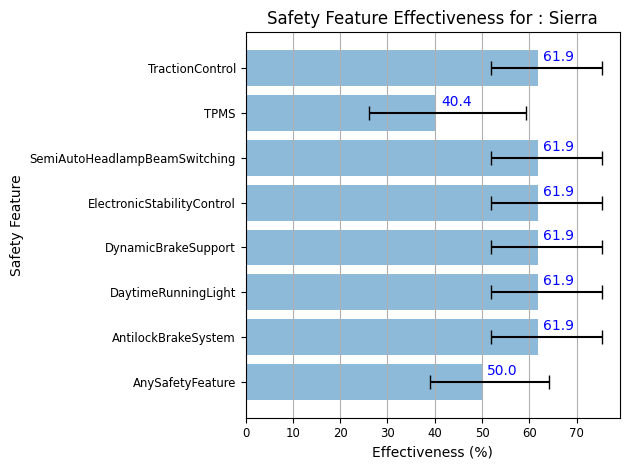

                                     E    DElow    DEhigh         R    SF    SN    NF    NN
-----------------------------  -------  -------  --------  --------  ----  ----  ----  ----
AnySafetyFeature               50.0418  10.9938   14.0958  0.499582    69    28   513   104
AntilockBrakeSystem            61.9455   9.9508   13.4741  0.380545    35    19   547   113
DaytimeRunningLight            61.9455   9.9508   13.4741  0.380545    35    19   547   113
DynamicBrakeSupport            61.9455   9.9508   13.4741  0.380545    35    19   547   113
ElectronicStabilityControl     61.9455   9.9508   13.4741  0.380545    35    19   547   113
SemiAutoHeadlampBeamSwitching  61.9455   9.9508   13.4741  0.380545    35    19   547   113
TPMS                           40.3715  14.3252   18.8549  0.596285    59    21   523   111
TractionControl                61.9455   9.9508   13.4741  0.380545    35    19   547   113


Tacoma SIZE:  396 --------------------
E    DElow    DEhigh    R    SF    SN  

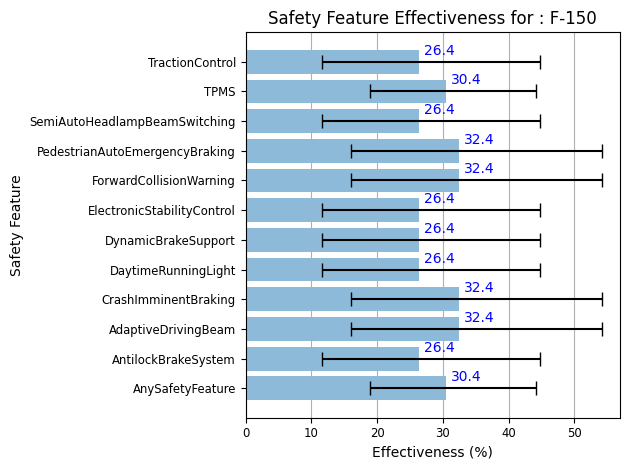

                                      E    DElow    DEhigh         R    SF    SN    NF    NN
------------------------------  -------  -------  --------  --------  ----  ----  ----  ----
AnySafetyFeature                30.4437  11.4819   13.752   0.695563   159    48  1062   223
AntilockBrakeSystem             26.3692  14.7016   18.3694  0.736308    99    29  1122   242
AdaptiveDrivingBeam             32.4368  16.4839   21.8035  0.675632    56    18  1165   253
CrashImminentBraking            32.4368  16.4839   21.8035  0.675632    56    18  1165   253
DaytimeRunningLight             26.3692  14.7016   18.3694  0.736308    99    29  1122   242
DynamicBrakeSupport             26.3692  14.7016   18.3694  0.736308    99    29  1122   242
ElectronicStabilityControl      26.3692  14.7016   18.3694  0.736308    99    29  1122   242
ForwardCollisionWarning         32.4368  16.4839   21.8035  0.675632    56    18  1165   253
PedestrianAutoEmergencyBraking  32.4368  16.4839   21.8035  0.675632  

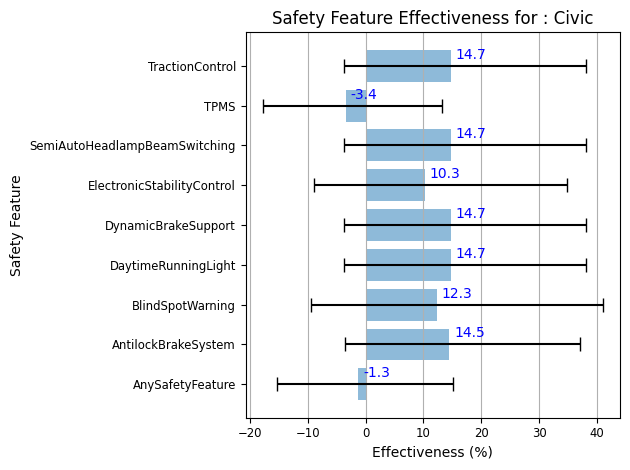

                                      E    DElow    DEhigh         R    SF    SN    NF    NN
-----------------------------  --------  -------  --------  --------  ----  ----  ----  ----
AnySafetyFeature               -1.26984  14.0912   16.3688  1.0127     352   128   315   116
AntilockBrakeSystem            14.4562   17.926    22.6783  0.855438    69    29   598   215
BlindSpotWarning               12.2807   21.6603   28.7626  0.877193    46    19   621   225
DaytimeRunningLight            14.6981   18.3855   23.4369  0.853019    64    27   603   217
DynamicBrakeSupport            14.6981   18.3855   23.4369  0.853019    64    27   603   217
ElectronicStabilityControl     10.2531   19.2429   24.495   0.897469    67    27   600   217
SemiAutoHeadlampBeamSwitching  14.6981   18.3855   23.4369  0.853019    64    27   603   217
TPMS                           -3.39993  14.3799   16.7027  1.034      350   126   317   118
TractionControl                14.6981   18.3855   23.4369  0.853019  

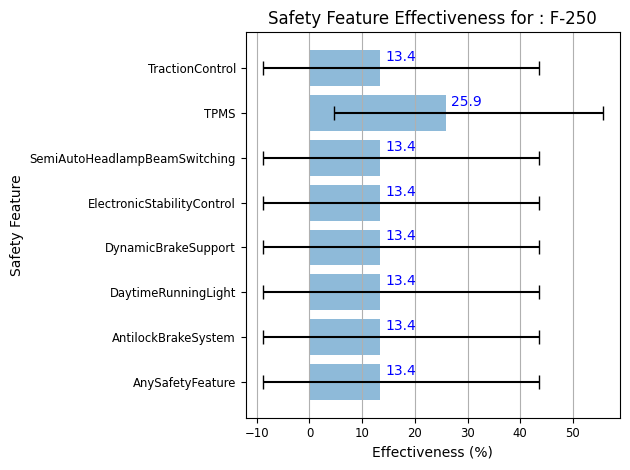

                                     E    DElow    DEhigh         R    SF    SN    NF    NN
-----------------------------  -------  -------  --------  --------  ----  ----  ----  ----
AnySafetyFeature               13.4295  22.3096   30.0548  0.865705    65    17   371    84
AntilockBrakeSystem            13.4295  22.3096   30.0548  0.865705    65    17   371    84
DaytimeRunningLight            13.4295  22.3096   30.0548  0.865705    65    17   371    84
DynamicBrakeSupport            13.4295  22.3096   30.0548  0.865705    65    17   371    84
ElectronicStabilityControl     13.4295  22.3096   30.0548  0.865705    65    17   371    84
SemiAutoHeadlampBeamSwitching  13.4295  22.3096   30.0548  0.865705    65    17   371    84
TPMS                           25.9346  21.23     29.7606  0.740654    43    13   393    88
TractionControl                13.4295  22.3096   30.0548  0.865705    65    17   371    84


Impala SIZE:  549 --------------------


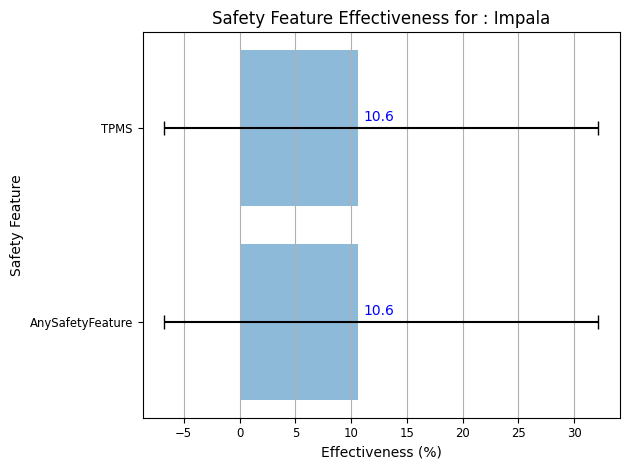

                        E    DElow    DEhigh         R    SF    SN    NF    NN
----------------  -------  -------  --------  --------  ----  ----  ----  ----
AnySafetyFeature  10.6164  17.3547   21.5362  0.893836   261    73   172    43
TPMS              10.6164  17.3547   21.5362  0.893836   261    73   172    43


Explorer SIZE:  536 --------------------


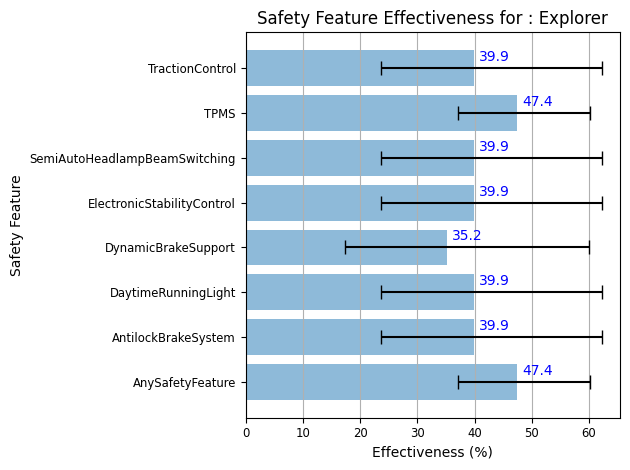

                                     E    DElow    DEhigh         R    SF    SN    NF    NN
-----------------------------  -------  -------  --------  --------  ----  ----  ----  ----
AnySafetyFeature               47.433   10.2953   12.8027  0.52567    157    56   272    51
AntilockBrakeSystem            39.9001  16.325    22.4132  0.600999    41    16   388    91
DaytimeRunningLight            39.9001  16.325    22.4132  0.600999    41    16   388    91
DynamicBrakeSupport            35.189   17.9022   24.7344  0.64811     41    15   388    92
ElectronicStabilityControl     39.9001  16.325    22.4132  0.600999    41    16   388    91
SemiAutoHeadlampBeamSwitching  39.9001  16.325    22.4132  0.600999    41    16   388    91
TPMS                           47.433   10.2953   12.8027  0.52567    157    56   272    51
TractionControl                39.9001  16.325    22.4132  0.600999    41    16   388    91


CR-V SIZE:  398 --------------------


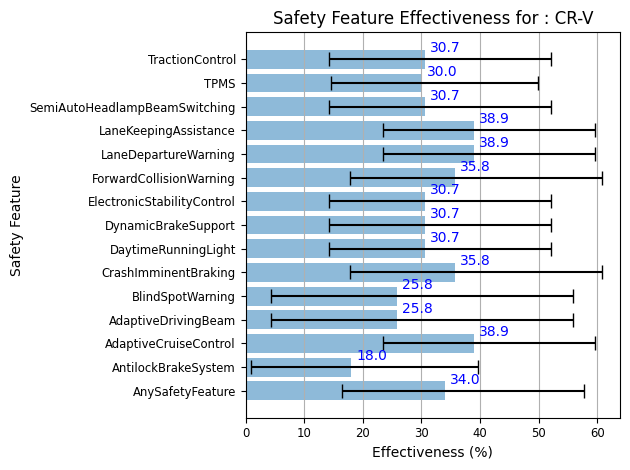

                                     E    DElow    DEhigh         R    SF    SN    NF    NN
-----------------------------  -------  -------  --------  --------  ----  ----  ----  ----
AnySafetyFeature               33.9636  17.5228   23.8519  0.660364   227   100    55    16
AntilockBrakeSystem            18.0203  17.1377   21.6672  0.819797    85    40   197    76
AdaptiveCruiseControl          38.9352  15.4694   20.7178  0.610648    37    23   245    93
AdaptiveDrivingBeam            25.7743  21.4421   30.1524  0.742257    28    15   254   101
BlindSpotWarning               25.7743  21.4421   30.1524  0.742257    28    15   254   101
CrashImminentBraking           35.8036  18.0214   25.0549  0.641964    28    17   254    99
DaytimeRunningLight            30.6787  16.41     21.4994  0.693213    49    27   233    89
DynamicBrakeSupport            30.6787  16.41     21.4994  0.693213    49    27   233    89
ElectronicStabilityControl     30.6787  16.41     21.4994  0.693213    49    27 

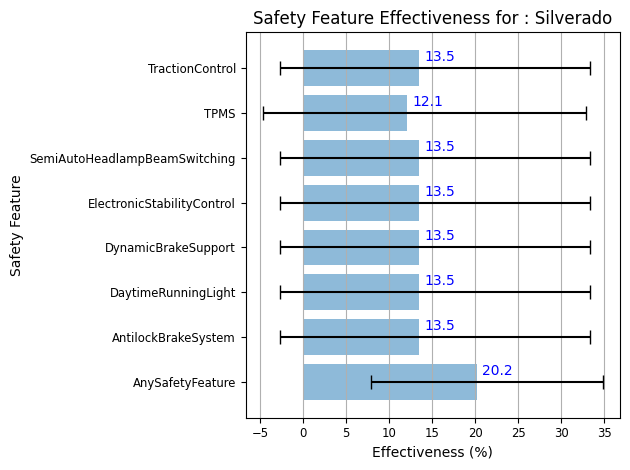

                                     E    DElow    DEhigh         R    SF    SN    NF    NN
-----------------------------  -------  -------  --------  --------  ----  ----  ----  ----
AnySafetyFeature               20.2308  12.3378   14.5952  0.797692   194    54  1207   268
AntilockBrakeSystem            13.4545  16.1201   19.81    0.865455   126    33  1275   289
DaytimeRunningLight            13.4545  16.1201   19.81    0.865455   126    33  1275   289
DynamicBrakeSupport            13.4545  16.1201   19.81    0.865455   126    33  1275   289
ElectronicStabilityControl     13.4545  16.1201   19.81    0.865455   126    33  1275   289
SemiAutoHeadlampBeamSwitching  13.4545  16.1201   19.81    0.865455   126    33  1275   289
TPMS                           12.0647  16.776    20.731   0.879353   120    31  1281   291
TractionControl                13.4545  16.1201   19.81    0.865455   126    33  1275   289


Accord SIZE:  1079 --------------------


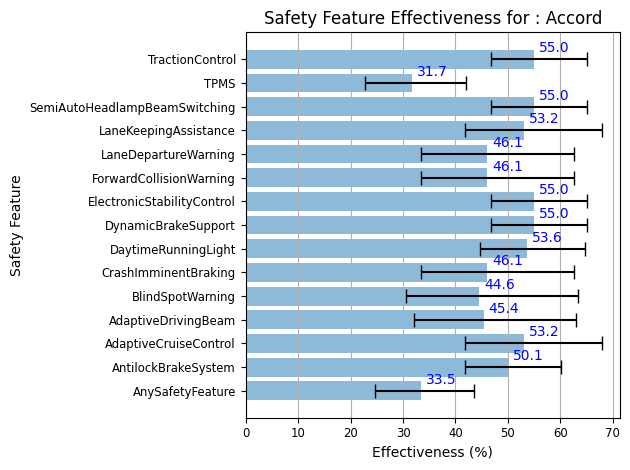

                                     E     DElow    DEhigh         R    SF    SN    NF    NN
-----------------------------  -------  --------  --------  --------  ----  ----  ----  ----
AnySafetyFeature               33.4895   8.75183  10.078    0.665105   369   152   438   120
AntilockBrakeSystem            50.0992   8.31878   9.98301  0.499008    98    59   709   213
AdaptiveCruiseControl          53.152   11.2597   14.8222   0.46848     35    24   772   248
AdaptiveDrivingBeam            45.3955  13.2895   17.5643   0.546045    37    22   770   250
BlindSpotWarning               44.5796  13.9923   18.7181   0.554204    34    20   773   252
CrashImminentBraking           46.1104  12.6828   16.5863   0.538896    40    24   767   248
DaytimeRunningLight            53.629    8.89647  11.0085   0.46371     63    42   744   230
DynamicBrakeSupport            54.9819   8.22829  10.0686   0.450181    71    48   736   224
ElectronicStabilityControl     54.9819   8.22829  10.0686   0.450181  

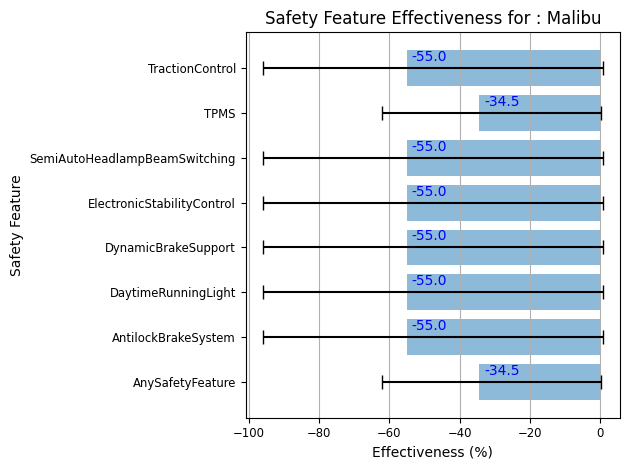

                                      E    DElow    DEhigh        R    SF    SN    NF    NN
-----------------------------  --------  -------  --------  -------  ----  ----  ----  ----
AnySafetyFeature               -34.4612  27.6287   34.774   1.34461   290    95    84    37
AntilockBrakeSystem            -55       41.0296   55.8003  1.55       62    15   312   117
DaytimeRunningLight            -55       41.0296   55.8003  1.55       62    15   312   117
DynamicBrakeSupport            -55       41.0296   55.8003  1.55       62    15   312   117
ElectronicStabilityControl     -55       41.0296   55.8003  1.55       62    15   312   117
SemiAutoHeadlampBeamSwitching  -55       41.0296   55.8003  1.55       62    15   312   117
TPMS                           -34.4612  27.6287   34.774   1.34461   290    95    84    37
TractionControl                -55       41.0296   55.8003  1.55       62    15   312   117


Cascadia SIZE:  456 --------------------
E    DElow    DEhigh    R    SF    SN

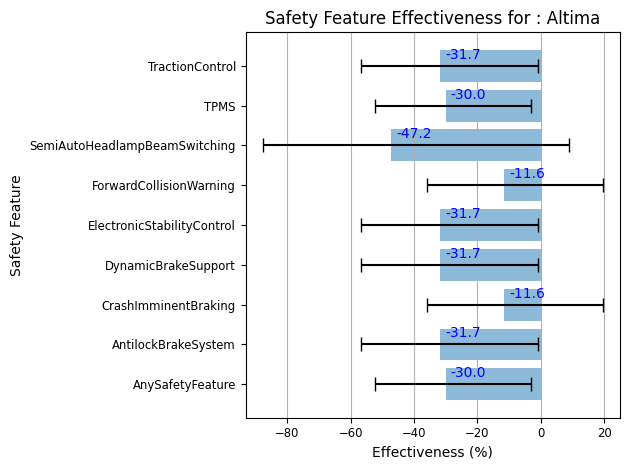

                                      E    DElow    DEhigh        R    SF    SN    NF    NN
-----------------------------  --------  -------  --------  -------  ----  ----  ----  ----
AnySafetyFeature               -29.9942  22.1926   26.7613  1.29994   449   157   121    55
AntilockBrakeSystem            -31.7496  24.9176   30.7294  1.3175    121    36   449   176
CrashImminentBraking           -11.5968  24.4007   31.229   1.11597    74    25   496   187
DynamicBrakeSupport            -31.7496  24.9176   30.7294  1.3175    121    36   449   176
ElectronicStabilityControl     -31.7496  24.9176   30.7294  1.3175    121    36   449   176
ForwardCollisionWarning        -11.5968  24.4007   31.229   1.11597    74    25   496   187
SemiAutoHeadlampBeamSwitching  -47.1893  40.5525   55.974   1.47189    50    13   520   199
TPMS                           -29.9942  22.1926   26.7613  1.29994   449   157   121    55
TractionControl                -31.7496  24.9176   30.7294  1.3175    121    36 

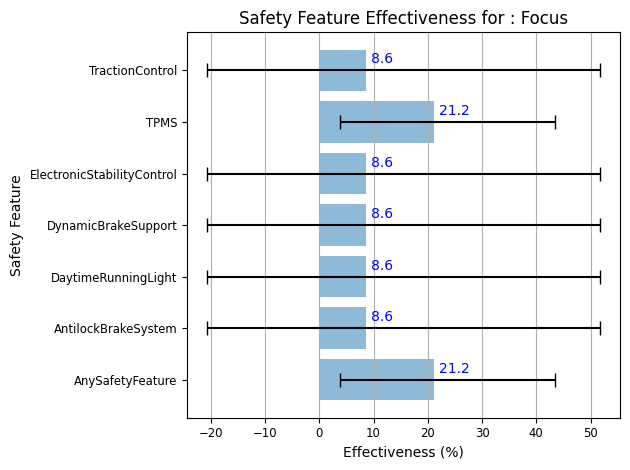

                                   E    DElow    DEhigh         R    SF    SN    NF    NN
--------------------------  --------  -------  --------  --------  ----  ----  ----  ----
AnySafetyFeature            21.1795   17.3918   22.3158  0.788205   212    75   104    29
AntilockBrakeSystem          8.61111  29.332    43.1961  0.913889    28    10   288    94
DaytimeRunningLight          8.61111  29.332    43.1961  0.913889    28    10   288    94
DynamicBrakeSupport          8.61111  29.332    43.1961  0.913889    28    10   288    94
ElectronicStabilityControl   8.61111  29.332    43.1961  0.913889    28    10   288    94
TPMS                        21.1795   17.3918   22.3158  0.788205   212    75   104    29
TractionControl              8.61111  29.332    43.1961  0.913889    28    10   288    94


Grand Cherokee SIZE:  511 --------------------
E    DElow    DEhigh    R    SF    SN    NF    NN
---  -------  --------  ---  ----  ----  ----  ----


Corolla SIZE:  687 ------------------

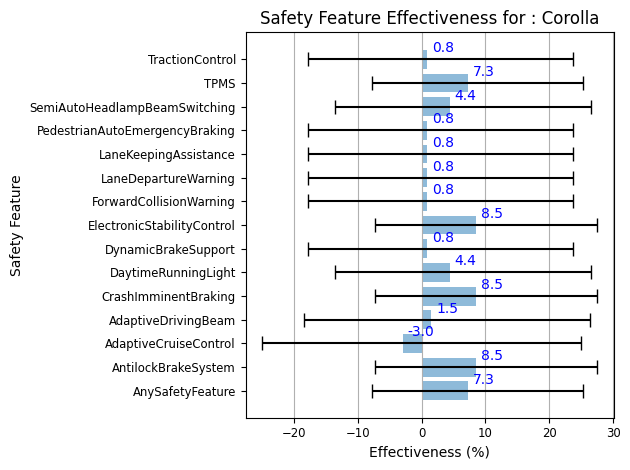

                                        E    DElow    DEhigh         R    SF    SN    NF    NN
------------------------------  ---------  -------  --------  --------  ----  ----  ----  ----
AnySafetyFeature                 7.31066   15.0562   17.9762  0.926893   311   124   184    68
AntilockBrakeSystem              8.48317   15.7687   19.0513  0.915168   133    55   362   137
AdaptiveCruiseControl           -2.95215   21.9841   27.9531  1.02952     74    28   421   164
AdaptiveDrivingBeam              1.52621   19.8941   24.9307  0.984738    84    33   411   159
CrashImminentBraking             8.48317   15.7687   19.0513  0.915168   133    55   362   137
DaytimeRunningLight              4.41259   17.9688   22.1286  0.955874   102    41   393   151
DynamicBrakeSupport              0.844278  18.5891   22.8781  0.991557   105    41   390   151
ElectronicStabilityControl       8.48317   15.7687   19.0513  0.915168   133    55   362   137
ForwardCollisionWarning          0.844278  18.5891

In [113]:
# dictionary to hold results
effectivenessRes = {}

# loop through 5 type of tests 
for i in range(0,4):
    if i==0:
        # 1. Any vehicle, any accident condition
        print("Overall Safety Feature Effectiveness",20*"-")
        effectivenessRes[i] = CalculateEffectiveness(farsAccVehMergeLight,"Overall Safety Feature Effectiveness")
        print(tabulate(effectivenessRes[i],headers="keys"))
        print()
        print()
    elif i==1:
        # 2. Any vehicle, each accident condition
        # initialize dictionary to hold results
        effectivenessRes[i]= {}
        for cond in roadConditionsToCheck:
            # initialize dictionary to hold results
            effectivenessRes[i][cond] = {}
            # VNUM_LAN is numerical
            if cond == "VNUM_LAN":
                cats = farsAccVehMergeLight["VNUM_LAN"].unique()
            else: # the others are FARS categorical
                cats = farsCategories[cond].keys()
            for option in cats:
                # features to skip
                if cond == "RUR_URB" and option in [6,9,8]:
                    continue
                elif cond == "FUNC_SYS" and option in [96,98,99]:
                    continue
                elif cond == "LGT_COND" and option in [7,8,9]:
                    continue
                elif cond == "WEATHER" and option in [8,98,99]:
                    continue
                elif cond == "VSURCOND" and option in [8,98,99]:
                    continue
                if cond == "VNUM_LAN":
                    title = "Safety Feature Effectiveness for : " + cond + " = " +str(option)
                else:
                    title = "Safety Feature Effectiveness for : " + cond + " = " + farsCategories[cond][option]
                roadConditionDf = farsAccVehMergeLight[farsAccVehMergeLight[cond]==option]
                print(cond,option,"SIZE: ",len(roadConditionDf),20*"-")
                effectivenessRes[i][cond][option] = CalculateEffectiveness(roadConditionDf,title)
                print(tabulate(effectivenessRes[i][cond][option],headers="keys"))
                print()
                print()
    elif i==2:
        # 3. Any vehicle, each driver condition
        # initialize dictionary to hold results
        effectivenessRes[i]= {}
        for cond in driverConditionsToCheck:
            # initialize dictionary to hold results
            effectivenessRes[i][cond] = {}
            cats = farsCategories[cond].keys()
            for option in cats:
                driverConditionDf = farsAccVehMergeLight[farsAccVehMergeLight[cond]==option]
                print(cond,option,"SIZE: ",len(driverConditionDf),20*"-")
                if len(driverConditionDf) == 0:
                    continue
                title = "Safety Feature Effectiveness for : " + cond + " = " + farsCategories[cond][option]
                effectivenessRes[i][cond][option] = CalculateEffectiveness(driverConditionDf,title)
                print(tabulate(effectivenessRes[i][cond][option],headers="keys"))
                print()
                print()
        print()
    elif i==3:
        # 4. Top vehicles, any accident condition
        # initialize dictionary to hold results
        effectivenessRes[i]= {}
        for modelId in farsAccVehMergeLightTopMod["ModelId"].unique():
            modelConditionDf = farsAccVehMergeLight[farsAccVehMergeLight["ModelId"]==modelId]
            print(farsCategories["ModelId"][modelId],"SIZE: ",len(modelConditionDf),20*"-")
            if len(modelConditionDf) == 0:
                continue
            title = "Safety Feature Effectiveness for : " + farsCategories["ModelId"][modelId]
            effectivenessRes[i][modelId] = CalculateEffectiveness(modelConditionDf,title)
            print(tabulate(effectivenessRes[i][modelId],headers="keys"))
            print()
            print()
 


## Compare overall effectiveness of safety features between top vehicle models

                   E     DElow    DEhigh
---------  ---------  --------  --------
Sierra      50.0418   10.9938    14.0958
Explorer    47.433    10.2953    12.8027
CR-V        33.9636   17.5228    23.8519
Accord      33.4895    8.75183   10.078
F-150       30.4437   11.4819    13.752
Focus       21.1795   17.3918    22.3158
Silverado   20.2308   12.3378    14.5952
F-250       13.4295   22.3096    30.0548
Impala      10.6164   17.3547    21.5362
Corolla      7.31066  15.0562    17.9762
Civic       -1.26984  14.0912    16.3688
Camry      -21.8012   16.5188    19.1107
Altima     -29.9942   22.1926    26.7613
Malibu     -34.4612   27.6287    34.774


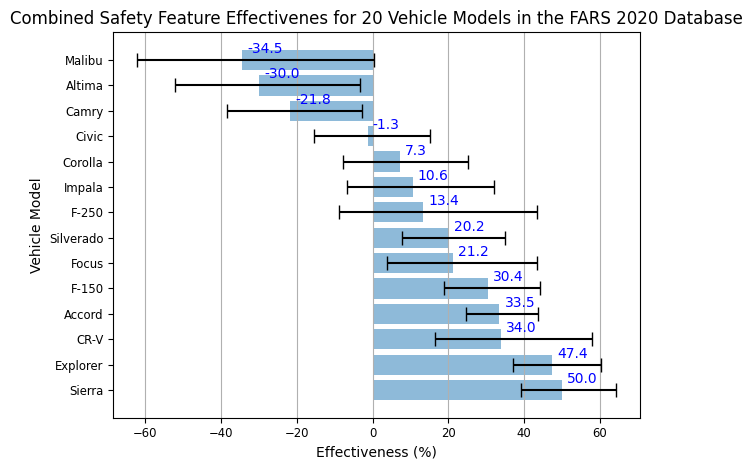

In [114]:
effectTopVeh      = pd.DataFrame(columns=["E","DElow", "DEhigh"])

# populate E values
for modelId in effectivenessRes[3].keys():
    if len(effectivenessRes[3][modelId]) == 0:
        #effectTopVeh.loc[farsCategories["ModelId"][modelId]] = np.array([np.nan,np.nan,np.nan])
        continue
    effectTopVeh.loc[farsCategories["ModelId"][modelId]] = effectivenessRes[3][modelId].loc["AnySafetyFeature"]

effectTopVeh.sort_values(by="E",ascending=False,inplace=True)

print(tabulate(effectTopVeh,headers="keys"))

# plot barh graph
fig, ax = plt.subplots()
bars = ax.barh(effectTopVeh.index, effectTopVeh.E.values, xerr = effectTopVeh[["DElow", "DEhigh"]].transpose().values, align='center', alpha=0.5, ecolor='black', capsize=5)
ax.set_xlabel("Effectiveness (%)")
ax.set_ylabel("Vehicle Model")
ax.set_title("Combined Safety Feature Effectivenes for 20 Vehicle Models in the FARS 2020 Database")
trans_offset = mtransforms.offset_copy(ax.transData, fig=fig,x=0.05, y=+0.07, units='inches')
ax.tick_params(labelsize="small")
for i in range(len(effectTopVeh)):
    plt.text(x= effectTopVeh.E[i],y= i,s= np.round(effectTopVeh.E[i],1), c='b', transform=trans_offset)
ax.xaxis.grid(True)
plt.tight_layout()
plt.show()